# NBA Clustering

    By Charlie Marshall
    
    1 April 2020

Notes:
- Need to look into if Salary and Advanced are merging correctly, especially because the number of players drops from 509 to 475 when salaries are added (this might mean that some of the players that logged minutes/statsa dont have salary data, which could be fine if they barely played (would be dropped by minutes restriction anyways), but not okay if they wouldn't have been dropped by minutes restriction)
- There are sometimes repeats of players once salary is added i.e. Avery Bradley

In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
pergame=pd.read_csv('PerGame.csv')

In [3]:
pergame.head()

Player Pos  Age   Tm   G  GS    MP   FG   FGA  \
0              Steven Adams\adamsst01   C   26  OKC  58  58  27.0  4.5   7.6   
1               Bam Adebayo\adebaba01  PF   22  MIA  65  65  34.4  6.3  11.1   
2         LaMarcus Aldridge\aldrila01   C   34  SAS  53  53  33.1  7.4  15.0   
3  Nickeil Alexander-Walker\alexani01  SG   21  NOP  41   0  12.2  1.9   5.5   
4             Grayson Allen\allengr01  SG   24  MEM  30   0  16.6  2.6   5.9   

     FG%  ...    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.591  ...  0.590  3.4  6.0   9.4  2.4  0.9  1.1  1.5  1.9  10.9  
1  0.567  ...  0.690  2.5  8.0  10.5  5.1  1.2  1.3  2.8  2.5  16.2  
2  0.493  ...  0.827  1.9  5.5   7.4  2.4  0.7  1.6  1.4  2.4  18.9  
3  0.339  ...  0.607  0.2  1.8   2.0  1.8  0.3  0.2  1.0  1.1   5.1  
4  0.449  ...  0.857  0.2  2.0   2.2  1.4  0.2  0.0  0.8  1.2   7.4  

[5 rows x 29 columns]

In [4]:
advanced=pd.read_csv('Advanced.csv')

In [5]:
advanced.head()

Player Pos  Age   Tm   G    MP   PER    TS%  \
0              Steven Adams\adamsst01   C   26  OKC  58  1564  20.8  0.605   
1               Bam Adebayo\adebaba01  PF   22  MIA  65  2235  20.6  0.606   
2         LaMarcus Aldridge\aldrila01   C   34  SAS  53  1754  19.8  0.571   
3  Nickeil Alexander-Walker\alexani01  SG   21  NOP  41   501   7.6  0.441   
4             Grayson Allen\allengr01  SG   24  MEM  30   498  11.4  0.577   

    3PAr    FTr  ...  Unnamed: 18  OWS  DWS   WS  WS/48  Unnamed: 23  OBPM  \
0  0.007  0.413  ...          NaN  3.7  2.5  6.2  0.190          NaN   2.1   
1  0.018  0.476  ...          NaN  4.6  3.6  8.1  0.175          NaN   1.6   
2  0.198  0.241  ...          NaN  3.1  1.4  4.4  0.122          NaN   1.8   
3  0.515  0.123  ...          NaN -0.7  0.4 -0.4 -0.034          NaN  -3.5   
4  0.517  0.199  ...          NaN  0.5  0.3  0.7  0.070          NaN  -1.0   

   DBPM  BPM  VORP  
0   1.1  3.2   2.0  
1   2.1  3.6   3.2  
2  -0.5  1.3   1.5  
3  -1.4 -4.9  -0.4  
4  -1.5 -2.6  -0.1  

[5 rows x 28 columns]

In [6]:
salary = pd.read_csv('Salary.csv')

In [7]:
salary.head()

Rk                       Player   Tm    2019-20    2020-21    2021-22  \
0   1      Stephen Curry\curryst01  GSW  $40231758  $43006362  $45780966   
1   2          Chris Paul\paulch01  OKC  $38506482  $41358814  $44211146   
2   3  Russell Westbrook\westbru01  HOU  $38178000  $41006000  $43848000   
3   4           John Wall\walljo01  WAS  $37800000  $40824000  $43848000   
4   5       James Harden\hardeja01  HOU  $37800000  $40824000  $43848000   

     2022-23 2023-24 2024-25 Signed Using  Guaranteed  
0        NaN     NaN     NaN  Bird Rights  $129019086  
1        NaN     NaN     NaN  Bird Rights   $79865296  
2  $46662000     NaN     NaN  Bird Rights  $123032000  
3  $46872000     NaN     NaN  Bird Rights  $122472000  
4  $46872000     NaN     NaN  Bird Rights  $122472000

## Preprocessing

In [8]:
pergame=pergame.dropna()

In [9]:
pergame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 513
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  460 non-null    object 
 1   Pos     460 non-null    object 
 2   Age     460 non-null    int64  
 3   Tm      460 non-null    object 
 4   G       460 non-null    int64  
 5   GS      460 non-null    int64  
 6   MP      460 non-null    float64
 7   FG      460 non-null    float64
 8   FGA     460 non-null    float64
 9   FG%     460 non-null    float64
 10  3P      460 non-null    float64
 11  3PA     460 non-null    float64
 12  3P%     460 non-null    float64
 13  2P      460 non-null    float64
 14  2PA     460 non-null    float64
 15  2P%     460 non-null    float64
 16  eFG%    460 non-null    float64
 17  FT      460 non-null    float64
 18  FTA     460 non-null    float64
 19  FT%     460 non-null    float64
 20  ORB     460 non-null    float64
 21  DRB     460 non-null    float64
 22  TR

In [10]:
advanced=advanced.drop(['Unnamed: 18', 'Unnamed: 23'], axis=1)

In [11]:
advanced=advanced.dropna()

In [12]:
advanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 0 to 513
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  509 non-null    object 
 1   Pos     509 non-null    object 
 2   Age     509 non-null    int64  
 3   Tm      509 non-null    object 
 4   G       509 non-null    int64  
 5   MP      509 non-null    int64  
 6   PER     509 non-null    float64
 7   TS%     509 non-null    float64
 8   3PAr    509 non-null    float64
 9   FTr     509 non-null    float64
 10  ORB%    509 non-null    float64
 11  DRB%    509 non-null    float64
 12  TRB%    509 non-null    float64
 13  AST%    509 non-null    float64
 14  STL%    509 non-null    float64
 15  BLK%    509 non-null    float64
 16  TOV%    509 non-null    float64
 17  USG%    509 non-null    float64
 18  OWS     509 non-null    float64
 19  DWS     509 non-null    float64
 20  WS      509 non-null    float64
 21  WS/48   509 non-null    float64
 22  OB

In [13]:
pergame=pergame.replace({'C-PF':'C', 'PF-SF':'PF', 'SF-PF':'SF', 'SF-SG':'SF'})

In [14]:
set(pergame.Pos)

{'C', 'PF', 'PG', 'SF', 'SG'}

In [15]:
advanced=advanced.replace({'C-PF':'C', 'PF-SF':'PF', 'SF-PF':'SF', 'SF-SG':'SF'})

In [16]:
set(advanced.Pos)

{'C', 'PF', 'PG', 'SF', 'SG'}

In [17]:
advanced=advanced.replace({'C':5,'PF':4,'SF':3,'SG':2,'PG':1})

In [18]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rk            545 non-null    int64 
 1   Player        545 non-null    object
 2   Tm            545 non-null    object
 3   2019-20       545 non-null    object
 4   2020-21       343 non-null    object
 5   2021-22       204 non-null    object
 6   2022-23       94 non-null     object
 7   2023-24       21 non-null     object
 8   2024-25       3 non-null      object
 9   Signed Using  440 non-null    object
 10  Guaranteed    545 non-null    object
dtypes: int64(1), object(10)
memory usage: 47.0+ KB


In [19]:
salary = salary.drop(['Rk','Tm','2020-21','2021-22','2022-23','2023-24','2024-25','Signed Using'],axis=1)

In [20]:
advanced = pd.merge(advanced,salary,on='Player')

In [21]:
advanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 0 to 472
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Player      473 non-null    object 
 1   Pos         473 non-null    int64  
 2   Age         473 non-null    int64  
 3   Tm          473 non-null    object 
 4   G           473 non-null    int64  
 5   MP          473 non-null    int64  
 6   PER         473 non-null    float64
 7   TS%         473 non-null    float64
 8   3PAr        473 non-null    float64
 9   FTr         473 non-null    float64
 10  ORB%        473 non-null    float64
 11  DRB%        473 non-null    float64
 12  TRB%        473 non-null    float64
 13  AST%        473 non-null    float64
 14  STL%        473 non-null    float64
 15  BLK%        473 non-null    float64
 16  TOV%        473 non-null    float64
 17  USG%        473 non-null    float64
 18  OWS         473 non-null    float64
 19  DWS         473 non-null    f

In [22]:
advanced['2019-20']=advanced['2019-20'].str.replace('$','').astype(float)

In [23]:
advanced['Guaranteed']=advanced['Guaranteed'].str.replace('$','').astype(float)

In [24]:
advanced[advanced.MP > 150].shape[0]/advanced.shape[0]

0.8816067653276956

In [25]:
advanced=advanced[advanced.MP > 150].reset_index(drop=True)

## Splitting Per Game By Position

In [190]:
pg=advanced[advanced.Pos == 1].reset_index(drop=True)

In [191]:
pg.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0  Ryan Arcidiacono\arcidry01    1   25  CHI  58   930   9.0  0.551  0.627   
1     D.J. Augustin\augusdj01    1   32  ORL  49  1215  14.2  0.548  0.438   
2         Lonzo Ball\balllo01    1   22  NOP  56  1817  13.7  0.529  0.578   
3        J.J. Barea\bareajo01    1   35  DAL  26   391  14.9  0.519  0.425   
4  Patrick Beverley\beverpa01    1   31  LAC  48  1299  12.3  0.554  0.609   

     FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  Guaranteed  \
0  0.173  ...  0.7  1.4  0.070  -2.7  -0.1 -2.8  -0.2   3000000.0   6000000.0   
1  0.395  ...  0.8  2.6  0.101  -0.3  -1.0 -1.4   0.2   7250000.0   7250000.0   
2  0.107  ...  1.9  2.6  0.068   0.4   0.6  1.0   1.3   8719320.0  19723102.0   
3  0.101  ...  0.2  0.7  0.084   1.8  -2.7 -1.0   0.1   2564753.0   2564753.0   
4  0.126  ...  2.0  3.4  0.126  -0.5   2.6  2.1   1.3  12345679.0  40000000.0   

   Clusters  
0         5  
1        10  
2        13  
3         9  
4         2  

[5 rows x 29 columns]

In [28]:
sg=advanced[advanced.Pos == 2].reset_index(drop=True)

In [29]:
sg.head()

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0  Nickeil Alexander-Walker\alexani01    2   21  NOP  41   501   7.6  0.441   
1             Grayson Allen\allengr01    2   24  MEM  30   498  11.4  0.577   
2              Dwayne Bacon\bacondw01    2   24  CHO  39   687   6.1  0.419   
3                RJ Barrett\barrerj01    2   19  NYK  56  1704  10.7  0.479   
4               Bradley Beal\bealbr01    2   26  WAS  57  2053  23.1  0.579   

    3PAr    FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.515  0.123  ... -0.7  0.4 -0.4 -0.034  -3.5  -1.4 -4.9  -0.4   2964840.0   
1  0.517  0.199  ...  0.5  0.3  0.7  0.070  -1.0  -1.5 -2.6  -0.1   2429400.0   
2  0.275  0.217  ... -1.2  0.4 -0.8 -0.053  -5.9  -0.9 -6.8  -0.8   1618520.0   
3  0.271  0.349  ... -1.6  1.1 -0.5 -0.015  -2.8  -1.5 -4.3  -1.0   7839960.0   
4  0.369  0.351  ...  4.6  0.5  5.1  0.119   5.3  -2.4  2.9   2.5  27093019.0   

   Guaranteed  
0   6078000.0  
1   4974720.0  
2   1618520.0  
3  16071720.0  
4  90346924.0  

[5 rows x 28 columns]

In [30]:
sf=advanced[advanced.Pos == 3].reset_index(drop=True)

In [31]:
sf.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0        OG Anunoby\anunoog01    3   22  TOR  63  1897  13.2  0.598  0.408   
1      Trevor Ariza\arizatr01    3   34  TOT  53  1493  11.0  0.593  0.639   
2       Will Barton\bartowi01    3   29  DEN  58  1916  15.7  0.549  0.390   
3  Keita Bates-Diop\bateske01    3   24  TOT  39   665  12.6  0.541  0.452   
4     Nicolas Batum\batumni01    3   31  CHO  22   505   9.2  0.463  0.605   

     FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.163  ...  1.8  3.3  5.1  0.130  -0.9   1.8  0.9   1.4   2281800.0   
1  0.228  ...  1.3  1.3  2.6  0.084  -1.5   0.9 -0.5   0.6  12200000.0   
2  0.180  ...  2.4  2.1  4.5  0.113   1.2  -0.1  1.2   1.5  12960000.0   
3  0.332  ...  0.6  0.5  1.1  0.081  -0.8  -0.1 -0.8   0.2   1416852.0   
4  0.123  ...  0.2  0.4  0.6  0.055  -2.7   0.9 -1.9   0.0  25565217.0   

   Guaranteed  
0   6154015.0  
1  14000000.0  
2  26880000.0  
3   1416852.0  
4  25565217.0  

[5 rows x 28 columns]

In [32]:
pf=advanced[advanced.Pos == 4].reset_index(drop=True)

In [33]:
pf.head()

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0            Bam Adebayo\adebaba01    4   22  MIA  65  2235  20.6  0.606   
1        Al-Farouq Aminu\aminual01    4   29  ORL  18   380   7.6  0.395   
2          Kyle Anderson\anderky01    4   26  MEM  59  1140  13.0  0.542   
3  Giannis Antetokounmpo\antetgi01    4   25  MIL  57  1763  31.6  0.608   
4        Carmelo Anthony\anthoca01    4   35  POR  50  1623  12.2  0.517   

    3PAr    FTr  ...  OWS  DWS    WS  WS/48  OBPM  DBPM   BPM  VORP  \
0  0.018  0.476  ...  4.6  3.6   8.1  0.175   1.6   2.1   3.6   3.2   
1  0.419  0.337  ... -0.4  0.5   0.1  0.016  -4.5   1.4  -3.1  -0.1   
2  0.221  0.236  ...  0.9  1.4   2.2  0.095  -1.3   1.9   0.6   0.7   
3  0.238  0.500  ...  5.6  4.8  10.4  0.282   7.4   4.1  11.5   6.0   
4  0.286  0.197  ...  0.1  0.9   1.0  0.029  -1.9  -1.8  -3.7  -0.7   

      2019-20  Guaranteed  
0   3454080.0   8569572.0  
1   9258000.0  29162700.0  
2   9073050.0  28515300.0  
3  25842697.0  53370787.0  
4   2159029.0   2159029.0  

[5 rows x 28 columns]

In [34]:
center=advanced[advanced.Pos == 5].reset_index(drop=True)

In [35]:
center.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0       Steven Adams\adamsst01    5   26  OKC  58  1564  20.8  0.605  0.007   
1  LaMarcus Aldridge\aldrila01    5   34  SAS  53  1754  19.8  0.571  0.198   
2      Jarrett Allen\allenja01    5   21  BRK  64  1647  20.3  0.658  0.012   
3      Deandre Ayton\aytonde01    5   21  PHO  30   996  20.4  0.571  0.006   
4        Aron Baynes\baynear01    5   33  PHO  42   934  15.1  0.581  0.441   

     FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.413  ...  3.7  2.5  6.2  0.190   2.1   1.1  3.2   2.0  25842697.0   
1  0.241  ...  3.1  1.4  4.4  0.122   1.8  -0.5  1.3   1.5  26000000.0   
2  0.574  ...  4.3  2.8  7.1  0.207   1.0   1.1  2.1   1.7   2376840.0   
3  0.168  ...  1.1  1.3  2.4  0.117   0.8  -0.4  0.5   0.6   9562920.0   
4  0.197  ...  1.3  0.7  2.0  0.103  -0.2  -0.9 -1.1   0.2   5453280.0   

   Guaranteed  
0  53370787.0  
1  50000000.0  
2   6286742.0  
3  19581120.0  
4   5453280.0  

[5 rows x 28 columns]

# Clustering

## All NBA Players

### Removing all factors except those which will be clustered on

In [36]:
advanced.head()

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0              Steven Adams\adamsst01    5   26  OKC  58  1564  20.8  0.605   
1               Bam Adebayo\adebaba01    4   22  MIA  65  2235  20.6  0.606   
2         LaMarcus Aldridge\aldrila01    5   34  SAS  53  1754  19.8  0.571   
3  Nickeil Alexander-Walker\alexani01    2   21  NOP  41   501   7.6  0.441   
4             Grayson Allen\allengr01    2   24  MEM  30   498  11.4  0.577   

    3PAr    FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.007  0.413  ...  3.7  2.5  6.2  0.190   2.1   1.1  3.2   2.0  25842697.0   
1  0.018  0.476  ...  4.6  3.6  8.1  0.175   1.6   2.1  3.6   3.2   3454080.0   
2  0.198  0.241  ...  3.1  1.4  4.4  0.122   1.8  -0.5  1.3   1.5  26000000.0   
3  0.515  0.123  ... -0.7  0.4 -0.4 -0.034  -3.5  -1.4 -4.9  -0.4   2964840.0   
4  0.517  0.199  ...  0.5  0.3  0.7  0.070  -1.0  -1.5 -2.6  -0.1   2429400.0   

   Guaranteed  
0  53370787.0  
1   8569572.0  
2  50000000.0  
3   6078000.0  
4   4974720.0  

[5 rows x 28 columns]

In [37]:
adv_clust=advanced.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [38]:
adv_clust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     417 non-null    int64  
 1   MP      417 non-null    int64  
 2   PER     417 non-null    float64
 3   TS%     417 non-null    float64
 4   3PAr    417 non-null    float64
 5   FTr     417 non-null    float64
 6   ORB%    417 non-null    float64
 7   DRB%    417 non-null    float64
 8   TRB%    417 non-null    float64
 9   AST%    417 non-null    float64
 10  STL%    417 non-null    float64
 11  BLK%    417 non-null    float64
 12  TOV%    417 non-null    float64
 13  USG%    417 non-null    float64
 14  OWS     417 non-null    float64
 15  DWS     417 non-null    float64
 16  WS      417 non-null    float64
 17  WS/48   417 non-null    float64
 18  OBPM    417 non-null    float64
 19  DBPM    417 non-null    float64
 20  BPM     417 non-null    float64
 21  VORP    417 non-null    float64
dtypes:

In [39]:
adv_clust.describe()

Age           MP         PER         TS%        3PAr  \
count  417.000000   417.000000  417.000000  417.000000  417.000000   
mean    26.247002  1099.014388   13.853717    0.556420    0.391873   
std      4.178574   583.985692    4.829625    0.059316    0.208266   
min     19.000000   151.000000    4.100000    0.370000    0.000000   
25%     23.000000   593.000000   10.400000    0.521000    0.271000   
50%     26.000000  1075.000000   13.000000    0.555000    0.408000   
75%     29.000000  1592.000000   16.900000    0.592000    0.527000   
max     43.000000  2243.000000   31.600000    0.726000    0.886000   

              FTr        ORB%        DRB%        TRB%        AST%  ...  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  ...   
mean     0.251252    4.841487   15.393285   10.118465   13.705516  ...   
std      0.127814    3.678051    6.016388    4.523520    8.690130  ...   
min      0.034000    0.500000    4.600000    3.400000    2.600000  ...   
25%      0.162000    2.200000   11.000000    6.600000    7.400000  ...   
50%      0.227000    3.400000   14.300000    9.000000   10.900000  ...   
75%      0.314000    6.300000   19.000000   12.300000   17.900000  ...   
max      0.736000   20.600000   37.500000   26.000000   49.700000  ...   

             TOV%        USG%         OWS         DWS          WS       WS/48  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean    12.685612   18.566906    1.228537    1.120863    2.350120    0.092266   
std      4.039360    5.468903    1.531379    0.848228    2.162321    0.060782   
min      3.500000    6.000000   -1.600000   -0.100000   -1.300000   -0.074000   
25%     10.100000   15.000000    0.200000    0.400000    0.700000    0.054000   
50%     12.400000   17.600000    0.800000    0.900000    1.800000    0.089000   
75%     14.700000   21.400000    2.000000    1.600000    3.500000    0.125000   
max     40.400000   37.400000    8.900000    4.800000   11.500000    0.282000   

             OBPM        DBPM         BPM        VORP  
count  417.000000  417.000000  417.000000  417.000000  
mean    -0.715348    0.011751   -0.701199    0.570504  
std      2.521390    1.252509    2.868316    1.073150  
min     -7.100000   -3.900000   -7.500000   -1.700000  
25%     -2.500000   -0.900000   -2.500000   -0.100000  
50%     -0.900000   -0.100000   -0.700000    0.200000  
75%      0.700000    0.900000    0.900000    1.000000  
max      7.900000    4.400000   11.500000    6.300000  

[8 rows x 22 columns]

In [40]:
scaler = preprocessing.StandardScaler().fit(adv_clust)
dfNorm = scaler.transform(adv_clust)

In [41]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [42]:
print(sse)

[6816.953103389873, 5880.054801733685, 5246.805304127229, 4878.189943511821, 4581.259823896399, 4323.770547922716, 4153.343143049721, 4010.6978305686225, 3885.3817667584335, 3760.4014317760902, 3723.1592062724512, 3610.639052649028, 3528.9603375469146, 3487.117507484819, 3418.3456055408096, 3327.4259465327423, 3285.968752610655, 3210.361750726437]


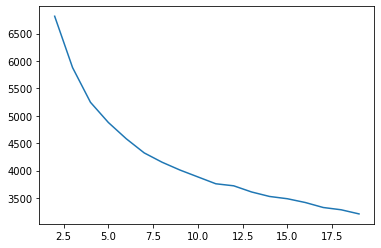

In [43]:
plt.plot(range(2,maxClusters),sse)

In [44]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [45]:
print(silh)

[0.2607349246577631, 0.24688865268175686, 0.1676057791677831, 0.1472765109175427, 0.1439070114694835, 0.1425797513525716, 0.1306312068692141, 0.12724271838112378, 0.12493962760390116, 0.11961098186482351, 0.11180977894879915, 0.11658844675182584, 0.11165444751767124, 0.10316079566165116, 0.10956840256069118, 0.10704097337485302, 0.1039410053282962, 0.10804670370457324]


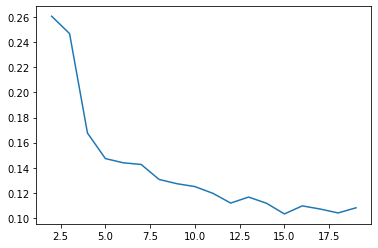

In [46]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 5 The average silhouette_score is : 0.1472765109175427
For n_clusters = 7 The average silhouette_score is : 0.1425797513525716
For n_clusters = 8 The average silhouette_score is : 0.13063120686921406
For n_clusters = 9 The average silhouette_score is : 0.12724271838112378
For n_clusters = 10 The average silhouette_score is : 0.12493962760390115
For n_clusters = 11 The average silhouette_score is : 0.11961098186482351
For n_clusters = 12 The average silhouette_score is : 0.11180977894879915
For n_clusters = 13 The average silhouette_score is : 0.11658844675182584
For n_clusters = 15 The average silhouette_score is : 0.10316079566165118
For n_clusters = 16 The average silhouette_score is : 0.10956840256069118
For n_clusters = 17 The average silhouette_score is : 0.10704097337485305
For n_clusters = 18 The average silhouette_score is : 0.1039410053282962


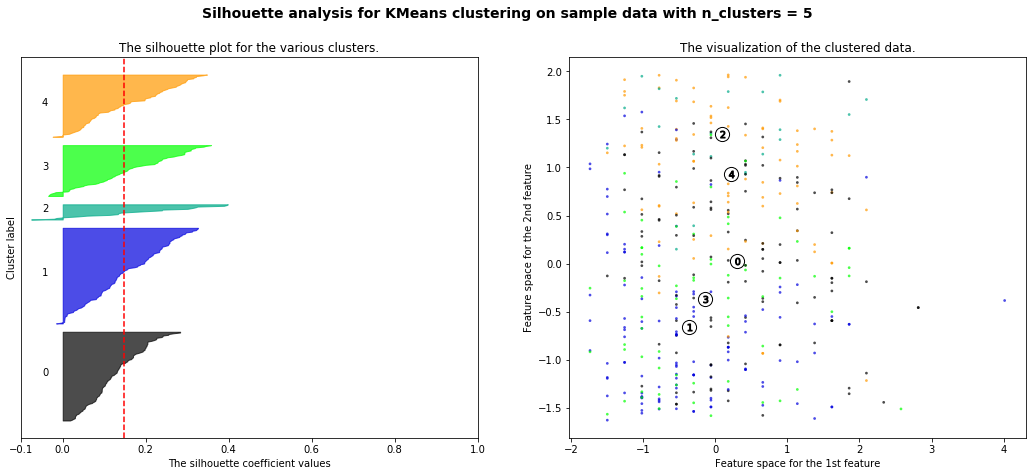

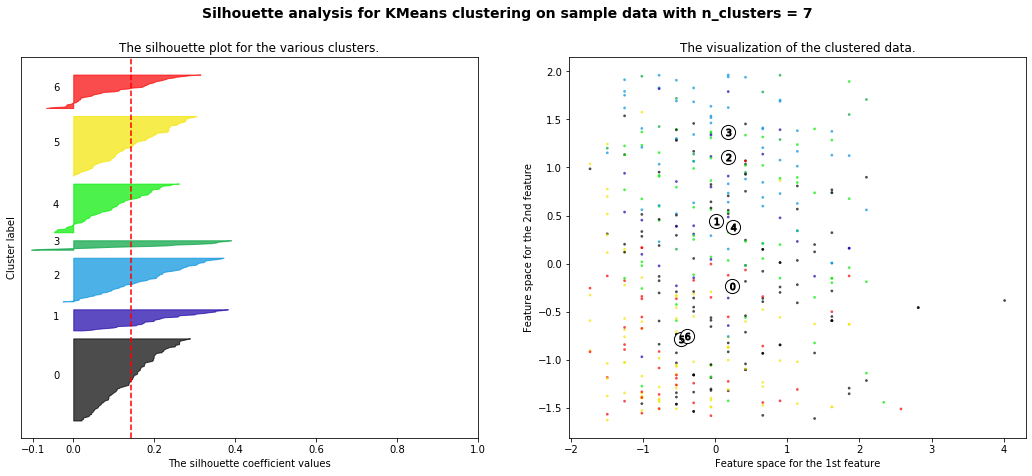

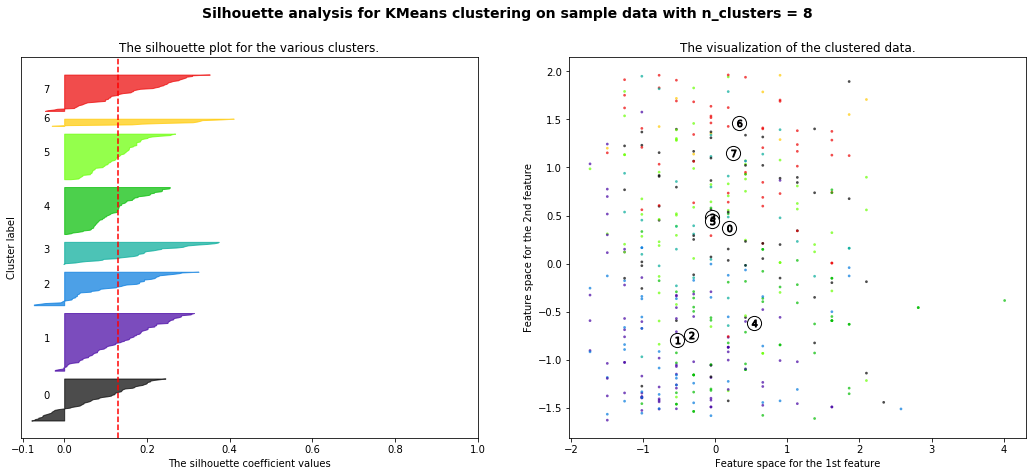

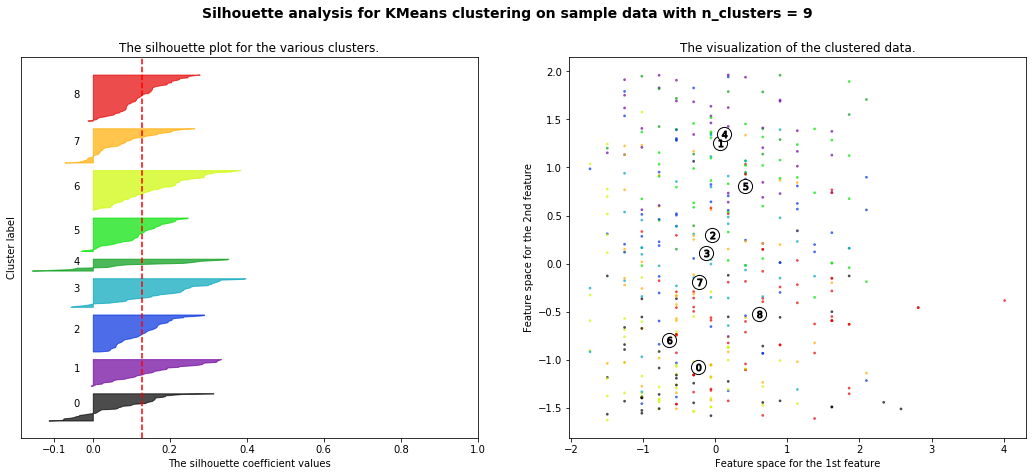

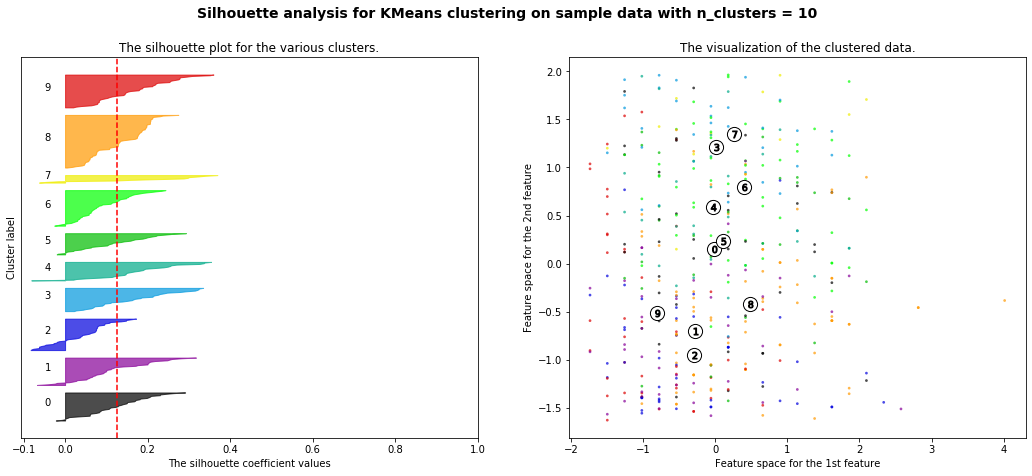

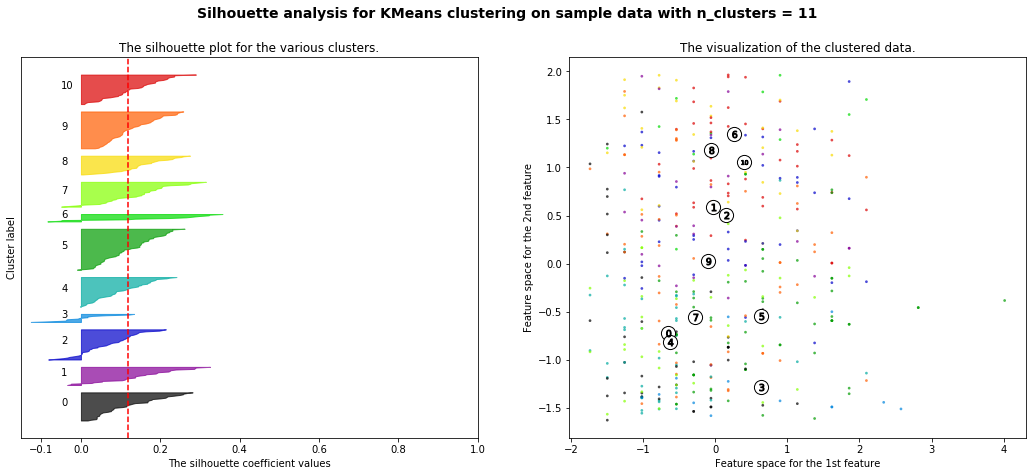

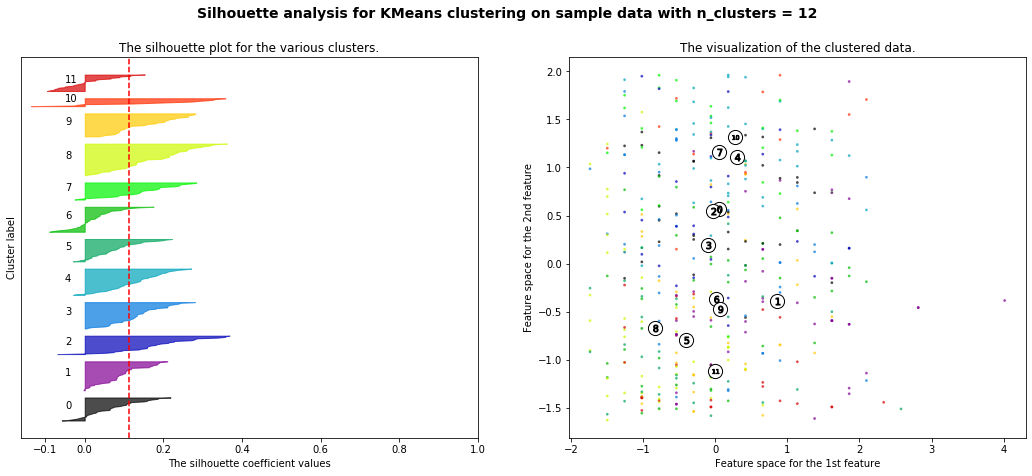

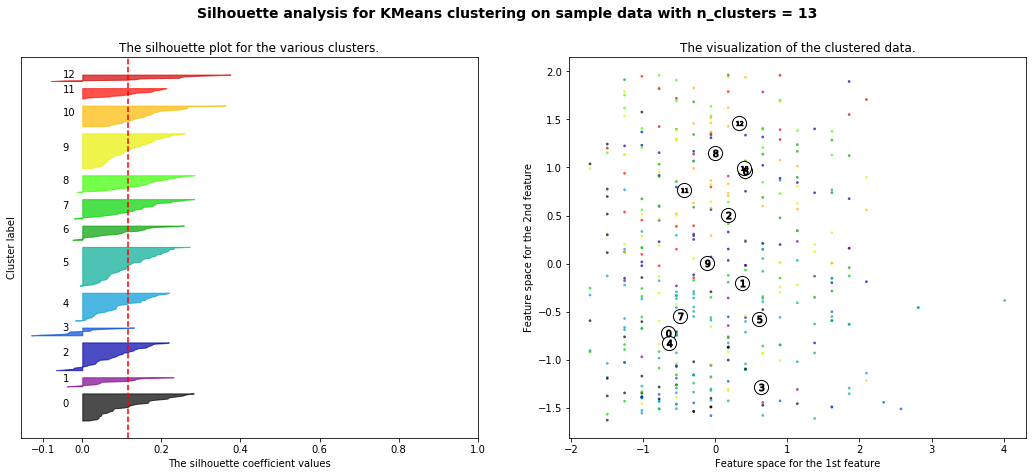

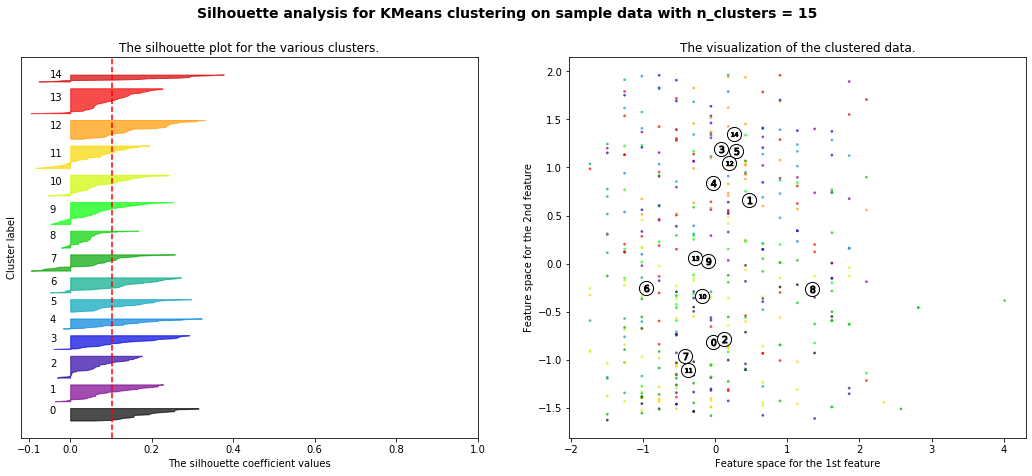

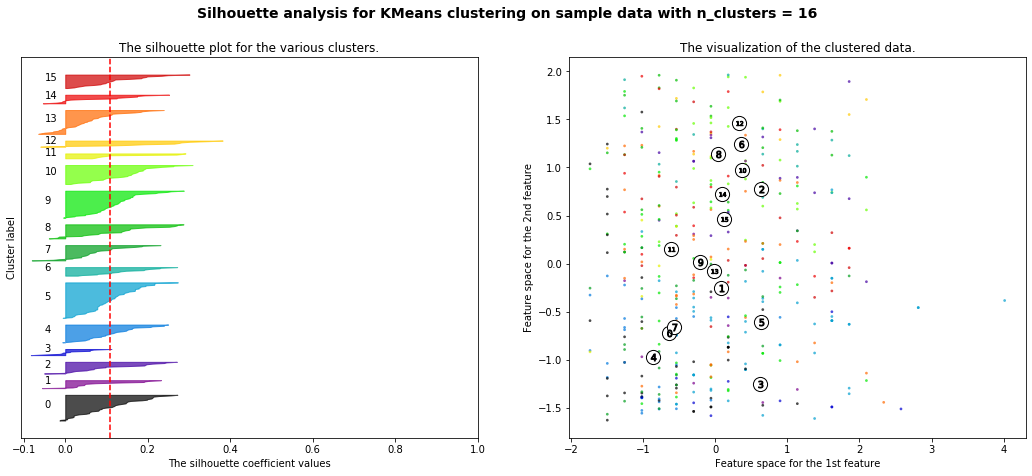

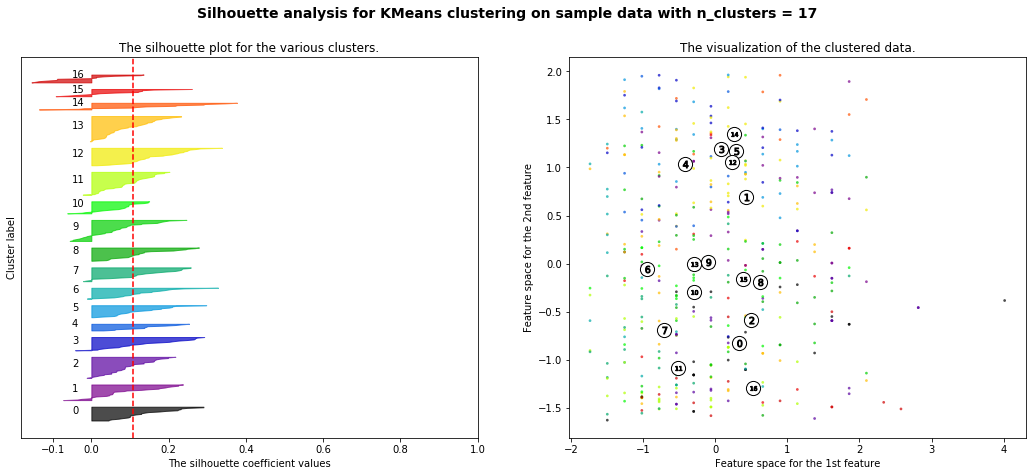

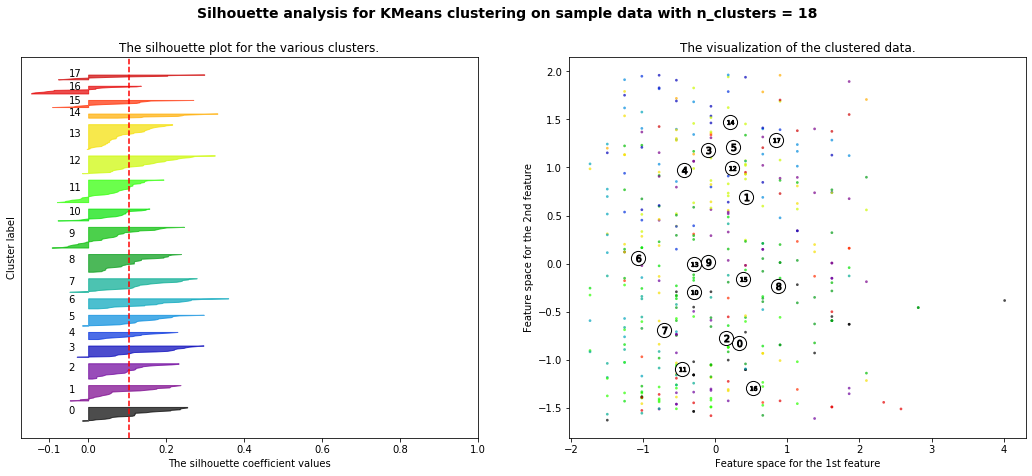

In [47]:
range_n_clusters = [5,7,8,9,10,11,12,13,15,16,17,18]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Overall Clustering

In [48]:
labels = KMeans(n_clusters=16, random_state=0).fit_predict(dfNorm)

In [49]:
adv_clust['Clusters'] = labels

In [50]:
advanced['Clusters'] = labels

In [51]:
adv_clust['Clusters'].value_counts()

5     59
9     45
0     43
13    40
10    32
4     30
7     26
8     24
15    23
2     20
14    15
6     15
1     14
12    11
3     11
11     9
Name: Clusters, dtype: int64

In [52]:
adv_clust.groupby('Clusters').mean()

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
0         23.558140   681.186047   7.595349  0.470349  0.456651  0.190721   
1         26.571429   952.285714  19.892857  0.586071  0.131786  0.294071   
2         28.900000  1552.350000  13.545000  0.582300  0.531500  0.190600   
3         28.818182   367.909091  10.581818  0.562091  0.128273  0.509455   
4         22.666667   534.333333  10.383333  0.506967  0.369867  0.231800   
5         28.898305   747.728814  10.425424  0.556746  0.611136  0.173746   
6         27.733333  1827.133333  18.346667  0.571867  0.371133  0.232733   
7         23.846154   717.346154  16.926923  0.621154  0.085462  0.397769   
8         26.416667  1766.041667  19.520833  0.565833  0.351167  0.309833   
9         25.355556  1109.466667  12.846667  0.539022  0.433333  0.194622   
10        27.812500  1668.156250  14.778125  0.582219  0.493156  0.223031   
11        23.666667  1187.000000  22.333333  0.648222  0.171778  0.351778   
12        27.636364  1950.363636  25.972727  0.601091  0.298727  0.423727   
13        26.150000  1054.250000  12.355000  0.528075  0.376150  0.220900   
14        26.666667  1522.800000  21.400000  0.655400  0.036867  0.466733   
15        26.782609  1370.739130  13.969565  0.570261  0.469870  0.217609   

               ORB%       DRB%       TRB%       AST%  ...       TOV%  \
Clusters                                              ...              
0          3.032558  11.541860   7.239535  11.725581  ...  13.481395   
1         14.035714  27.242857  20.571429   9.735714  ...  13.228571   
2          3.130000  13.825000   8.585000  13.445000  ...  12.335000   
3         10.090909  20.063636  15.054545   7.400000  ...  21.627273   
4          6.070000  17.753333  11.906667   8.740000  ...  13.983333   
5          3.067797  11.976271   7.564407   7.745763  ...   9.291525   
6          4.140000  20.006667  12.126667  15.086667  ...   9.873333   
7          9.976923  20.219231  15.003846  10.319231  ...  15.023077   
8          2.404167  12.329167   7.387500  31.029167  ...  13.687500   
9          2.553333  11.555556   7.022222  16.137778  ...  11.591111   
10         2.115625  10.415625   6.246875  14.637500  ...  10.109375   
11         9.355556  21.022222  15.100000  10.911111  ...  11.233333   
12         4.718182  20.309091  12.718182  33.600000  ...  13.554545   
13         3.575000  13.585000   8.517500  17.917500  ...  15.700000   
14        12.280000  27.366667  20.006667  10.280000  ...  14.326667   
15         5.660870  20.147826  12.934783  10.113043  ...  11.621739   

               USG%       OWS       DWS        WS     WS/48      OBPM  \
Clusters                                                                
0         16.974419 -0.425581  0.353488 -0.074419 -0.002953 -4.095349   
1         19.842857  1.507143  1.335714  2.842857  0.153786  0.492857   
2         15.265000  1.775000  2.255000  4.015000  0.128850 -0.300000   
3         12.600000  0.227273  0.345455  0.572727  0.070091 -3.709091   
4         16.050000 -0.020000  0.553333  0.543333  0.047867 -3.156667   
5         14.447458  0.549153  0.698305  1.254237  0.083169 -1.496610   
6         23.646667  2.833333  2.320000  5.153333  0.136933  2.066667   
7         16.007692  1.226923  0.853846  2.073077  0.139538 -1.061538   
8         28.504167  2.850000  1.529167  4.395833  0.122250  2.954167   
9         21.824444  0.528889  0.662222  1.188889  0.054044 -0.691111   
10        20.653125  2.253125  1.168750  3.418750  0.099375  0.846875   
11        21.955556  3.255556  1.377778  4.633333  0.183667  2.888889   
12        30.127273  6.109091  2.945455  9.072727  0.223182  5.772727   
13        16.207500  0.455000  1.142500  1.597500  0.074500 -1.812500   
14        17.946667  3.760000  2.633333  6.393333  0.203933  1.346667   
15        17.930435  1.300000  1.560870  2.852174  0.103609 -0.295652   

              DBP

In [53]:
advanced[advanced.Clusters == 0]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
3    Nickeil Alexander-Walker\alexani01    2   21  NOP  41   501   7.6  0.441   
15               Dwayne Bacon\bacondw01    2   24  CHO  39   687   6.1  0.419   
19                 RJ Barrett\barrerj01    2   19  NYK  56  1704  10.7  0.479   
45                  Ky Bowman\bowmaky01    1   22  GSW  45  1015   9.2  0.494   
62              Deonte Burton\burtode02    2   26  OKC  34   284   5.9  0.426   
90               Allen Crabbe\crabbal01    2   27  TOT  37   653   6.0  0.470   
93             Jarrett Culver\culveja01    2   20  MIN  63  1506   9.6  0.467   
101       Matthew Dellavedova\dellama01    1   29  CLE  57   821   8.1  0.463   
110           Sekou Doumbouya\doumbse01    3   19  DET  38   754   6.2  0.474   
115            Carsen Edwards\edwarca01    2   21  BOS  35   316   6.5  0.446   
119               Jacob Evans\evansja02    2   22  TOT  29   418   5.5  0.436   
123         Terrance Ferguson\fergute01    3   21  OKC  50  1170   4.1  0.504   
130               Tim Frazier\fraziti01    1   29  DET  27   355   9.8  0.464   
136            Darius Garland\garlada01    1   20  CLE  59  1824   8.5  0.498   
148            Treveon Graham\grahatr01    2   26  TOT  55   929   6.6  0.456   
158             Marko Guduric\gudurma01    2   24  MEM  42   476   8.8  0.515   
191           De'Andre Hunter\huntede01    3   22  ATL  63  2018   8.6  0.521   
201             Frank Jackson\jacksfr01    1   21  NOP  51   656   7.7  0.500   
208                 Ty Jerome\jeromty01    1   22  PHO  28   315   8.1  0.437   
211             Tyler Johnson\johnsty01    2   27  PHO  31   515   8.1  0.481   
220    Michael Kidd-Gilchrist\kiddgmi01    4   26  TOT  21   231   4.2  0.401   
221    Michael Kidd-Gilchrist\kiddgmi01    4   26  TOT  21   231   4.2  0.401   
223            Brandon Knight\knighbr03    1   28  TOT  25   462   8.5  0.503   
224                 Kevin Knox\knoxke01    3   20  NYK  65  1166   8.4  0.470   
233            Romeo Langford\langfro01    2   20  BOS  27   298   6.0  0.465   
235               Jake Layman\laymaja01    4   25  MIN  23   505  10.3  0.544   
255               Terance Mann\mannte01    2   23  LAC  35   271   7.1  0.472   
268          Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493   
269          Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493   
270          Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493   
289             Mychal Mulder\muldemy01    2   25  GSW   7   204   7.8  0.533   
290             Mychal Mulder\muldemy01    2   25  GSW   7   204   7.8  0.533   
293                Džanan Musa\musadz01    3   20  BRK  35   404   8.4  0.467   
301             Jaylen Nowell\nowelja01    2   20  MIN  15   151  10.5  0.471   
322               Theo Pinson\pinsoth01    2   24  BRK  33   365   5.2  0.370   
325              Jordan Poole\poolejo01    2   20  GSW  57  1274   7.2  0.454   
332               Cam Reddish\reddica01    3   20  ATL  58  1551   9.0  0.500   
338           Jerome Robinson\robinje01    2   22  TOT  55   748   6.0  0.439   
350         Admiral Schofield\schofad01    3   22  WAS  27   293   6.8  0.514   
356             Iman Shumpert\shumpim01    2   29  BRK  13   241   5.3  0.403   
360           Anfernee Simons\simonan01    2   20  POR  65  1400   9.3  0.506   
365             Edmond Sumner\sumneed01    1   24  IND  25   345  10.0  0.485   
381               Evan Turner\turneev01    1   31  ATL  19   251   6.8  0.424   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
3    0.515  0.123  ...  0.4 -0.4 -0.034  -3.5  -1.4 -4.9  -0.4   2964840.0   
15   0.275  0.217  ...  0.4 -0.8 -0.053  -5.9  -0.9 -6.8  -0.8   1618520.0   
19   0.271  0.349  ...  1.1 -0.5 -0.015  -2.8  -1.5 -4.3  -1.0   7839960.0   
45   0.333  0.128  ...  0.6 -0.1 -0.003  -4.0  -0.3 -4.3  -0.6    350189.0   
62   0.438  0.114  ...  0.3 -0.3 -0.046  -5.5  -0.4 -5.8  -0.3   1416852.0   


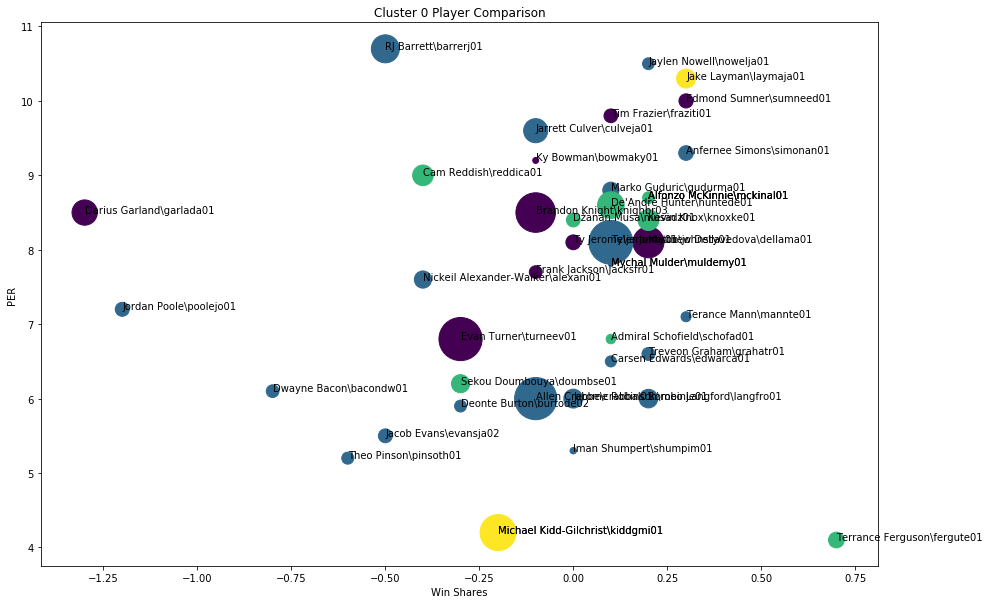

In [54]:
plt.figure(figsize=(15,10))
x = advanced[advanced.Clusters == 0].WS
y = advanced[advanced.Clusters == 0].PER
colors = advanced[advanced.Clusters == 0].Pos
area = advanced[advanced.Clusters == 0]['2019-20']/10000

ax = plt.scatter(x, y, c=colors, s=area)
plt.xlabel('Win Shares')
plt.ylabel('PER')
plt.title('Cluster 0 Player Comparison')

z = advanced[advanced.Clusters == 0].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 0].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 0].reset_index(drop=True).Player):
    plt.annotate(txt, (z[i], y[i]))

plt.show()

Text(0.5, 1.0, 'Cluster 0 Player Comparison')

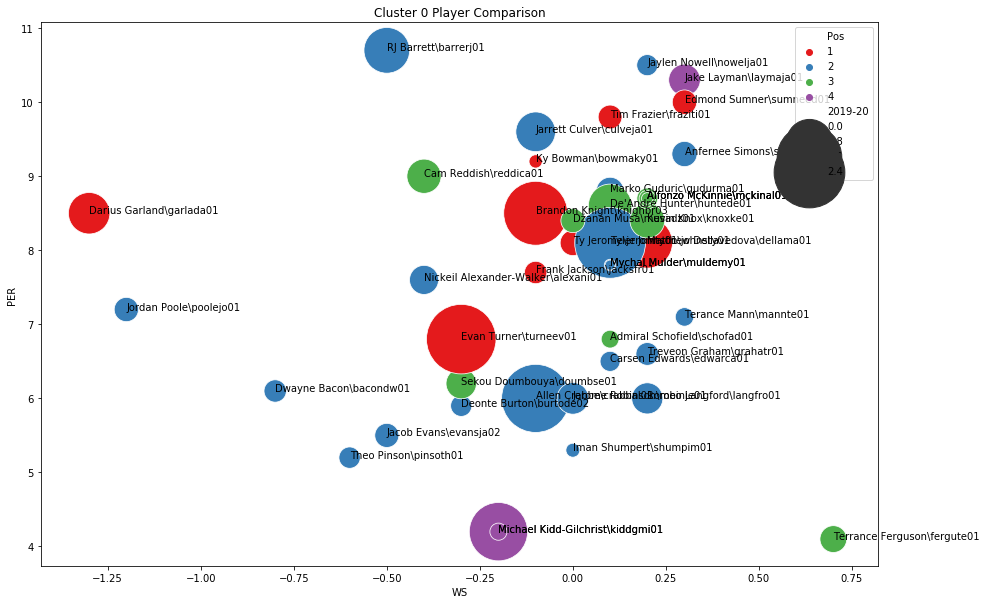

In [55]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,5000),data=advanced[advanced.Clusters == 0])

z = advanced[advanced.Clusters == 0].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 0].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 0].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Cluster 0 Player Comparison')

In [56]:
advanced[advanced.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
14       Deandre Ayton\aytonde01    5   21  PHO  30   996  20.4  0.571  0.006   
44       Chris Boucher\bouchch01    4   27  TOR  55   724  19.8  0.570  0.381   
48        Tony Bradley\bradlto01    5   22  UTA  50   535  21.8  0.675  0.006   
66        Clint Capela\capelca01    5   25  HOU  39  1279  20.7  0.626  0.000   
105       Gorgui Dieng\dienggo01    5   30  TOT  58  1012  17.4  0.564  0.414   
112     Andre Drummond\drumman01    5   26  TOT  57  1879  22.0  0.553  0.045   
121     Derrick Favors\favorde01    5   28  NOP  45  1089  19.0  0.624  0.023   
173  Willy Hernangómez\hernawi01    5   25  CHO  31   375  19.2  0.576  0.158   
218        Enes Kanter\kanteen01    5   27  BOS  51   891  22.0  0.594  0.023   
239             Alex Len\lenal01    5   26  TOT  49   895  18.0  0.596  0.185   
256   Boban Marjanović\marjabo01    5   31  DAL  37   337  24.5  0.599  0.087   
306       Kyle O'Quinn\oquinky01    5   29  PHI  26   258  18.1  0.541  0.319   
373   Tristan Thompson\thomptr01    5   28  CLE  57  1721  16.8  0.540  0.041   
414        Cody Zeller\zelleco01    5   27  CHO  58  1341  18.8  0.576  0.157   

       FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
14   0.168  ...  1.3  2.4  0.117   0.8  -0.4  0.5   0.6   9562920.0   
44   0.396  ...  1.5  3.2  0.214   0.4   1.0  1.4   0.6   1588231.0   
48   0.258  ...  0.9  2.7  0.242   0.9   0.4  1.3   0.4   1962360.0   
66   0.268  ...  2.1  5.0  0.186   1.1   0.4  1.5   1.1  16456522.0   
105  0.242  ...  1.6  2.7  0.128   0.0   1.8  1.8   0.9  16229213.0   
112  0.375  ...  3.6  4.3  0.109  -0.1   1.1  1.0   1.4  27093019.0   
121  0.203  ...  1.4  3.8  0.168   0.8   0.4  1.2   0.9  17650000.0   
173  0.424  ...  0.4  0.8  0.107   0.6  -0.5  0.1   0.2   1676735.0   
218  0.286  ...  1.7  3.8  0.207   1.6  -0.1  1.5   0.8   4767000.0   
239  0.301  ...  0.9  2.3  0.122  -0.2  -0.2 -0.5   0.3   4160000.0   
256  0.272  ...  0.5  1.3  0.184   1.7  -1.7  0.0   0.2   3500000.0   
306  0.264  ...  0.5  0.8  0.155  -0.7   2.2  1.5   0.2   2028594.0   
373  0.286  ...  1.1  3.1  0.085  -0.2  -1.3 -1.5   0.2  18539130.0   
414  0.374  ...  1.2  3.6  0.129   0.2  -0.8 -0.6   0.5  14471910.0   

     Guaranteed  Clusters  
14   19581120.0         1  
44    1588231.0         1  
48    5504420.0         1  
66   72086957.0         1  
105  33516853.0         1  
112  27093019.0         1  
121  17650000.0         1  
173   1676735.0         1  
218   4767000.0         1  
239   4160000.0         1  
256   7000000.0         1  
306   2028594.0         1  
373  18539130.0         1  
414  29887640.0         1  

[14 rows x 29 columns]

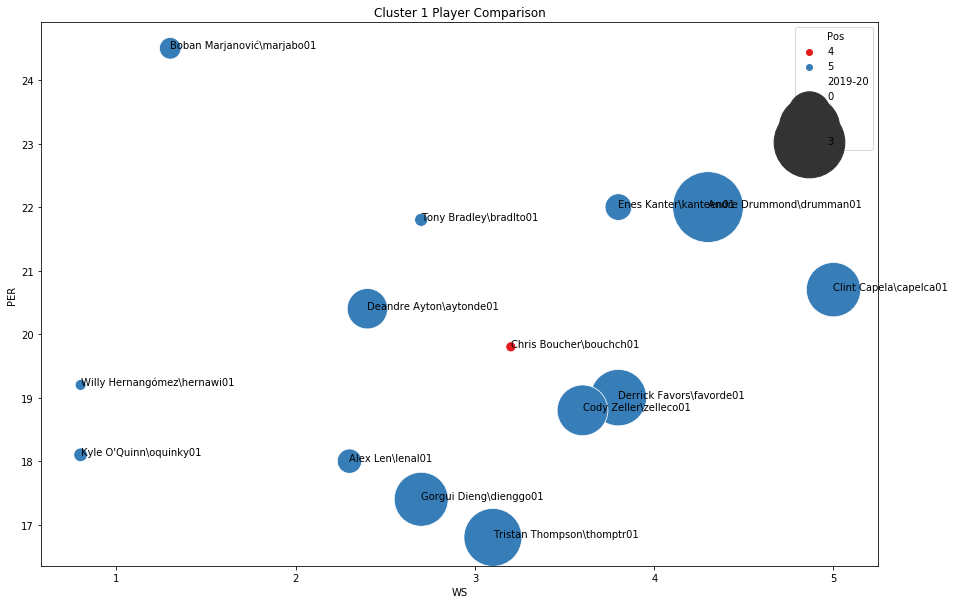

In [57]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,5000),data=advanced[advanced.Clusters == 1])

z = advanced[advanced.Clusters == 1].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 1].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 1].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Cluster 1 Player Comparison')
plt.show()

In [58]:
advanced[advanced.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
10         OG Anunoby\anunoog01    3   22  TOR  63  1897  13.2  0.598  0.408   
12       Trevor Ariza\arizatr01    3   34  TOT  53  1493  11.0  0.593  0.639   
34   Patrick Beverley\beverpa01    1   31  LAC  48  1299  12.3  0.554  0.609   
49      Mikal Bridges\bridgmi01    3   23  PHO  65  1772  13.0  0.623  0.391   
89   Robert Covington\covinro01    4   29  TOT  62  1867  13.6  0.571  0.654   
107  Donte DiVincenzo\divindo01    2   23  MIL  59  1362  15.0  0.570  0.489   
137        Marc Gasol\gasolma01    5   35  TOR  36   990  11.9  0.546  0.538   
150       Danny Green\greenda02    2   32  LAL  61  1529  11.1  0.564  0.704   
177        George Hill\hillge01    1   33  MIL  52  1103  17.5  0.668  0.452   
178        George Hill\hillge01    1   33  MIL  52  1103  17.5  0.668  0.452   
182    Justin Holiday\holidju01    2   30  IND  65  1617  12.7  0.598  0.667   
196        Joe Ingles\inglejo01    3   32  UTA  64  1916  12.5  0.588  0.628   
232        Jeremy Lamb\lambje01    2   27  IND  46  1291  14.1  0.547  0.330   
246       Brook Lopez\lopezbr01    5   31  MIL  61  1622  14.0  0.537  0.497   
305     Royce O'Neale\onealro01    4   26  UTA  64  1862   9.3  0.584  0.657   
330     Norman Powell\powelno01    2   26  TOR  44  1269  17.4  0.629  0.457   
361      Marcus Smart\smartma01    2   25  BOS  53  1721  14.0  0.519  0.582   
380       P.J. Tucker\tuckepj01    4   34  HOU  64  2203   8.7  0.580  0.687   
385     Fred VanVleet\vanvlfr01    1   25  TOR  48  1719  16.0  0.546  0.482   
411      Delon Wright\wrighde01    2   27  DAL  65  1412  16.1  0.563  0.307   

       FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
10   0.163  ...  3.3  5.1  0.130  -0.9   1.8  0.9   1.4   2281800.0   
12   0.228  ...  1.3  2.6  0.084  -1.5   0.9 -0.5   0.6  12200000.0   
34   0.126  ...  2.0  3.4  0.126  -0.5   2.6  2.1   1.3  12345679.0   
49   0.258  ...  1.9  4.1  0.111  -0.7   1.5  0.8   1.3   4161000.0   
89   0.167  ...  2.4  3.3  0.085  -1.0   1.1  0.1   1.0  11301219.0   
107  0.173  ...  3.1  4.5  0.158  -0.6   2.7  2.1   1.4   2905800.0   
137  0.153  ...  1.8  2.7  0.128  -0.9   2.7  1.8   0.9  25595700.0   
150  0.104  ...  2.4  3.4  0.108  -0.8   1.7  0.9   1.1  14634146.0   
177  0.247  ...  1.9  5.1  0.220   1.8   1.4  3.2   1.5   9133907.0   
178  0.247  ...  1.9  5.1  0.220   1.8   1.4  3.2   1.5   1000000.0   
182  0.137  ...  2.2  4.0  0.117   0.0   1.7  1.6   1.5   4767000.0   
196  0.170  ...  2.0  4.3  0.108   0.0   0.7  0.7   1.3  11954546.0   
232  0.230  ...  1.8  2.7  0.099  -1.1   0.7 -0.4   0.5  10500000.0   
246  0.212  ...  3.9  4.6  0.137  -1.1   2.8  1.8   1.5  12093024.0   
305  0.153  ...  2.2  4.0  0.104  -1.3   2.1  0.8   1.3   1618520.0   
330  0.252  ...  1.9  4.2  0.157   1.4   0.9  2.3   1.4  10116576.0   
361  0.201  ...  2.4  4.1  0.115   0.2   1.3  1.6   1.5  12553471.0   
380  0.118  ...  2.2  3.9  0.086  -2.2   0.6 -1.6   0.2   8349039.0   
385  0.237  ...  2.7  4.9  0.136   1.0   1.3  2.3   1.8   9000000.0   
411  0.236  ...  1.8  4.3  0.148   0.4   2.0  2.4   1.6   9473684.0   

     Guaranteed  Clusters  
10    6154015.0         2  
12   14000000.0         2  
34   40000000.0         2  
49    8520000.0         2  
89   36415035.0         2  
107   5949960.0         2  
137  25595700.0         2  
150  30000000.0         2  
177  21000000.0         2  
178  21000000.0         2  
182   4767000.0         2  
196  36818183.0         2  
232  31500000.0         2  
246  52000000.0         2  
305  37618520.0         2  
330  20982528.0         2  
361  40339184.0         2  
380  16318576.0         2  
385   9000000.0         2  
411  27000000.0         2  

[20 rows x 29 columns]

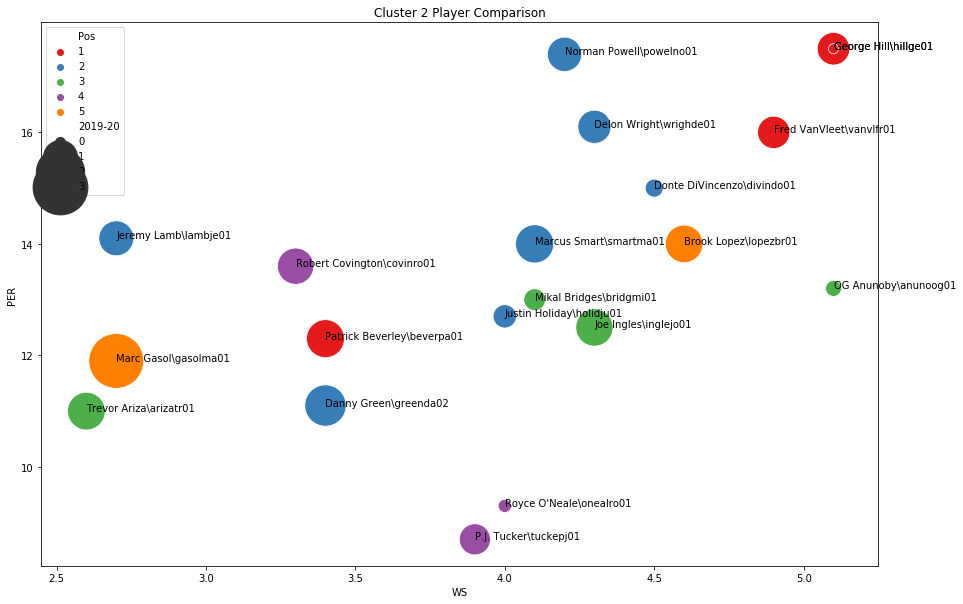

In [59]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,3000),data=advanced[advanced.Clusters == 2])

z = advanced[advanced.Clusters == 2].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 2].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 2].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Cluster 2 Player Comparison')
plt.show()

In [60]:
advanced[advanced.Clusters == 3]

Player  Pos  Age   Tm   G   MP   PER    TS%   3PAr  \
29          Jordan Bell\belljo01    5   25  TOT  29  256  13.9  0.577  0.179   
35          Khem Birch\birchkh01    5   27  ORL  40  777  10.1  0.529  0.009   
67     DeMarre Carroll\carrode01    3   33  TOT  21  231   8.5  0.523  0.500   
68     DeMarre Carroll\carrode01    3   33  TOT  21  231   8.5  0.523  0.500   
74      Tyson Chandler\chandty01    5   37  HOU  26  219  10.8  0.717  0.000   
98            Ed Davis\davised01    5   30  UTA  25  268   7.3  0.425  0.000   
122  Cristiano Felício\feliccr01    4   27  CHI  22  386  12.8  0.671  0.037   
253        Ian Mahinmi\mahinia01    5   33  WAS  38  808  14.1  0.545  0.124   
316   Anžejs Pasečņiks\pasecan01    5   24  WAS  24  405  11.6  0.555  0.019   
321       Norvel Pelle\pelleno01    5   26  PHI  20  178  11.2  0.521  0.000   
366     Caleb Swanigan\swanica01    4   22  TOT  27  288   7.6  0.597  0.043   

       FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
29   0.463  ...  0.2  0.4  0.070  -1.4  -1.1 -2.5   0.0   1620564.0   
35   0.583  ...  0.8  1.5  0.092  -3.3   0.3 -3.0  -0.2   3000000.0   
67   0.667  ...  0.1  0.1  0.026  -3.4  -1.1 -4.5  -0.1   6842307.0   
68   0.667  ...  0.1  0.1  0.026  -3.4  -1.1 -4.5  -0.1    811447.0   
74   0.722  ...  0.3  0.6  0.130  -2.5   1.1 -1.4   0.0   2564753.0   
98   0.324  ...  0.5  0.4  0.074  -5.5   1.7 -3.9  -0.1   4767000.0   
122  0.426  ...  0.3  1.0  0.126  -1.4  -1.6 -3.0  -0.1   8156500.0   
253  0.538  ...  0.7  1.4  0.082  -2.7   0.0 -2.7  -0.2  15450051.0   
316  0.509  ...  0.2  0.5  0.056  -3.8  -1.6 -5.4  -0.3    482144.0   
321  0.343  ...  0.4  0.3  0.082  -7.1   3.1 -4.1  -0.1    350189.0   
366  0.362  ...  0.2  0.0  0.007  -6.3   0.2 -6.0  -0.3   2033160.0   

     Guaranteed  Clusters  
29    1620564.0         3  
35    6000000.0         3  
67   14262321.0         3  
68     811447.0         3  
74    2564753.0         3  
98    9772350.0         3  
122  15685520.0         3  
253  15450051.0         3  
316    482144.0         3  
321    350189.0         3  
366   2033160.0         3  

[11 rows x 29 columns]

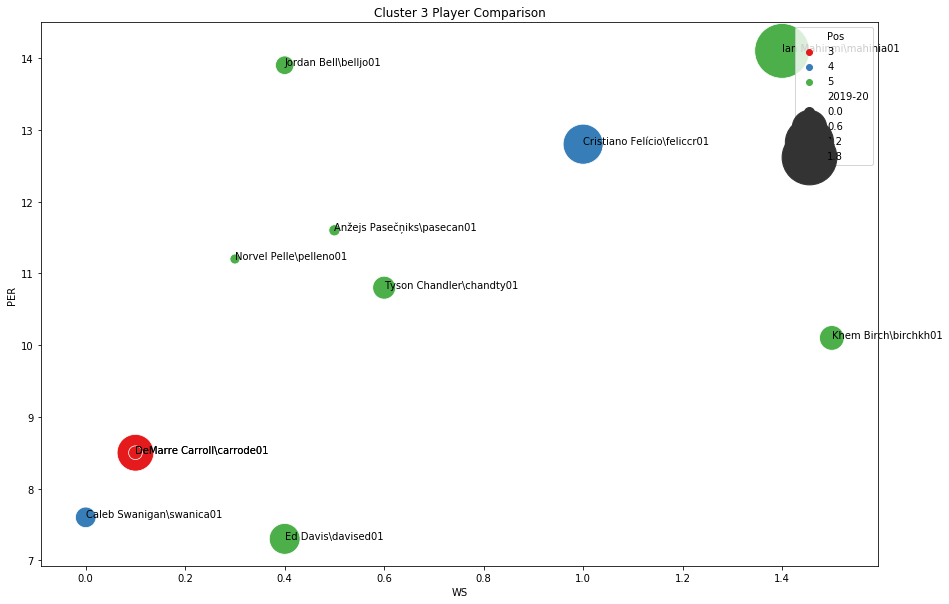

In [61]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,3000),data=advanced[advanced.Clusters == 3])

z = advanced[advanced.Clusters == 3].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 3].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 3].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Cluster 3 Player Comparison')
plt.show()

In [62]:
advanced[advanced.Clusters == 4]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
6          Al-Farouq Aminu\aminual01    4   29  ORL  18   380   7.6  0.395   
25           Darius Bazley\bazleda01    4   19  OKC  53   909   8.1  0.475   
31           Dragan Bender\bendedr01    3   22  TOT  16   286  11.0  0.545   
32           Dragan Bender\bendedr01    3   22  TOT  16   286  11.0  0.545   
36            Goga Bitadze\bitadgo01    5   20  IND  49   410  12.2  0.530   
42             Isaac Bonga\bongais01    3   20  WAS  58  1025  10.7  0.627   
56          Sterling Brown\brownst02    3   24  MIL  45   665   9.3  0.478   
64           Bruno Caboclo\cabocbr01    3   24  TOT  27   220  13.4  0.455   
100         Dewayne Dedmon\dedmode01    5   30  TOT  44   774   9.4  0.473   
104         Hamidou Diallo\diallha01    3   21  OKC  38   699   8.4  0.488   
120              Dante Exum\exumda01    2   24  TOT  35   485  10.4  0.576   
124         Bruno Fernando\fernabr01    5   21  ATL  56   713  11.9  0.542   
132         Wenyen Gabriel\gabriwe01    4   22  TOT  28   210   9.6  0.547   
172       Juan Hernangómez\hernaju01    4   24  TOT  48   833  10.4  0.518   
175          Mario Hezonja\hezonma01    4   24  POR  47   767   9.5  0.532   
192     Chandler Hutchison\hutchch01    3   23  CHI  28   527  12.4  0.521   
206           Justin James\jamesju01    2   23  SAC  34   218  11.5  0.487   
229         Rodions Kurucs\kurucro01    4   21  BRK  39   501   8.4  0.554   
236               T.J. Leaf\leaftj01    4   22  IND  25   193  13.8  0.485   
244          Nassir Little\littlna01    4   19  POR  48   573   9.7  0.505   
245           Kevon Looney\looneke01    5   23  GSW  20   262   9.4  0.403   
264        Jalen McDaniels\mcdanja01    4   22  CHO  16   293  10.7  0.574   
334                Naz Reid\reidna01    5   20  MIN  30   495  15.3  0.505   
364         Omari Spellman\spellom01    4   22  GSW  49   886  14.4  0.551   
377  Juan Toscano-Anderson\toscaju01    3   26  GSW  13   272   9.4  0.529   
390          Lonnie Walker\walkelo01    2   21  SAS  53   767  11.0  0.515   
401         Grant Williams\willigr01    4   21  BOS  62   970   8.0  0.508   
402       Kenrich Williams\willike04    4   25  NOP  35   779   7.6  0.430   
408            D.J. Wilson\wilsodj01    4   23  MIL  31   280   8.4  0.476   
409        Justise Winslow\winslju01    3   23  MIA  11   352   8.6  0.440   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
6    0.419  0.337  ...  0.5  0.1  0.016  -4.5   1.4 -3.1  -0.1   9258000.0   
25   0.435  0.204  ...  1.2  0.4  0.019  -3.1   0.6 -2.5  -0.1   2284800.0   
31   0.467  0.152  ...  0.3  0.3  0.053  -3.0   0.1 -2.9  -0.1   1678854.0   
32   0.467  0.152  ...  0.3  0.3  0.053  -3.0   0.1 -2.9  -0.1    189702.0   
36   0.279  0.256  ...  0.7  0.6  0.069  -4.0   1.5 -2.5   0.0   2816760.0   
42   0.299  0.348  ...  0.4  1.7  0.081  -2.4   0.0 -2.4  -0.1   1416852.0   
56   0.523  0.161  ...  1.3  1.0  0.071  -3.1   1.0 -2.0   0.0   1618520.0   
64   0.364  0.065  ...  0.4  0.3  0.070  -2.5   1.1 -1.4   0.0   1845301.0   
100  0.420  0.141  ...  1.1  0.1  0.006  -5.8   0.0 -5.8  -0.7  13333334.0   
104  0.160  0.205  ...  0.8  0.2  0.014  -5.0   0.3 -4.8  -0.5   1416852.0   
120  0.361  0.361  ...  0.2  0.4  0.043  -2.5  -0.4 -2.9  -0.1   9600000.0   
124  0.186  0.256  ...  0.4  0.8  0.055  -3.2  -1.0 -4.1  -0.4   1400000.0   
132  0.435  0.435  ...  0.2  0.2  0.043  -3.9   0.0 -3.9  -0.1    898310.0   
172  0.522  0.287  ...  0.7  1.0  0.055  -2.2  -1.1 -3.3  -0.3   3321030.0   
175  0.339  0.270  ...  0.6  0.7  0.046  -3.1   0.2 -2.9  -0.2   1737145.0   
192  0.217  0.446  ...  0.7  0.7  0.060  -2.7   0.1 -2.6  -0.1   2332320.0   
206  0.333  0.269  ...  0.2  0.2  0.037  -1.0   0.2 -0.7   0.1    898310.0   
229  0.485  0.209  ...  0.6  0.5  0.048  -3.9   0.9 -2.9  -0.1   1699236.0   
236  0.203  0.174  ...  0.3  0.4  0.088  -1.4  -0.1 -1.5   0.0   2813280.0   
244  0.391  0.291  ...  0.3  0.6  0.050  -2.9  -0.6

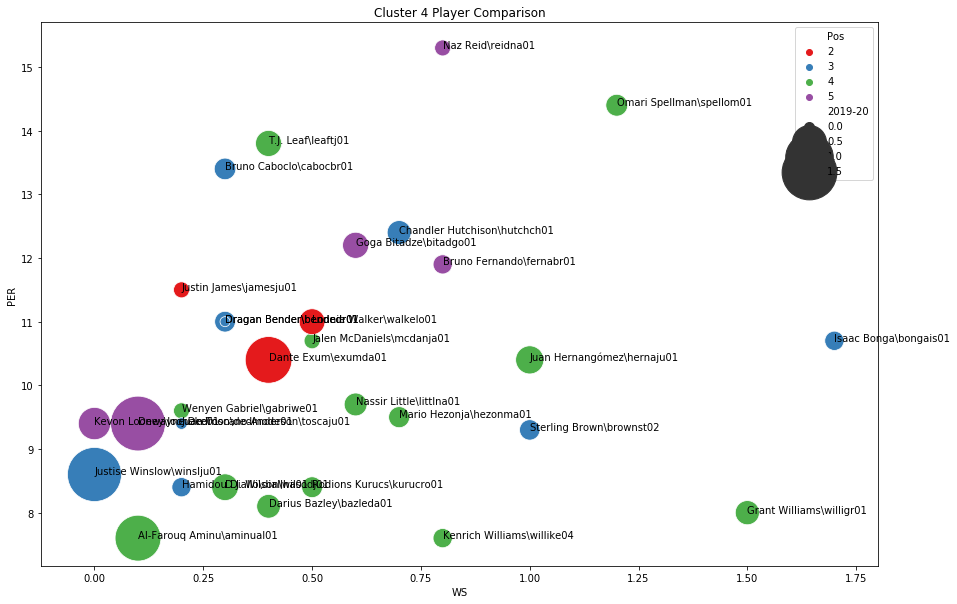

In [63]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,3000),data=advanced[advanced.Clusters == 4])

z = advanced[advanced.Clusters == 4].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 4].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 4].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Cluster 4 Player Comparison')
plt.show()

In [64]:
advanced[advanced.Clusters == 5]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
11          Ryan Arcidiacono\arcidry01    1   25  CHI  58   930   9.0  0.551   
21          Keita Bates-Diop\bateske01    3   24  TOT  39   665  12.6  0.541   
28           Marco Belinelli\belinma01    2   33  SAS  52   779  10.2  0.521   
46             Avery Bradley\bradlav01    2   29  LAL  49  1186   8.9  0.537   
47             Avery Bradley\bradlav01    2   29  LAL  49  1186   8.9  0.537   
51            Ryan Broekhoff\broekry01    2   29  DAL  17   180  13.1  0.568   
59            Reggie Bullock\bullore01    2   28  NYK  29   684   9.3  0.502   
70              Vince Carter\cartevi01    3   43  ATL  60   876   7.6  0.470   
75           Wilson Chandler\chandwi01    3   32  BRK  35   734   7.4  0.531   
78                Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
79                Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
80                Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
91              Torrey Craig\craigto01    3   29  DEN  50   869  10.4  0.559   
95              Troy Daniels\danietr01    2   28  TOT  42   457   8.9  0.524   
96              Troy Daniels\danietr01    2   28  TOT  42   457   8.9  0.524   
109           Damyean Dotson\dotsoda01    2   25  NYK  48   836  10.9  0.527   
113             Jared Dudley\dudleja01    3   34  LAL  40   311   7.4  0.570   
116          Wayne Ellington\ellinwa01    2   32  NYK  36   558   8.5  0.509   
118              James Ennis\ennisja01    3   29  TOT  61  1053  11.5  0.557   
154               Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
155               Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
156               Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
179              Solomon Hill\hillso01    3   28  TOT  54   992   9.8  0.542   
185               Rodney Hood\hoodro01    3   27  POR  21   619  12.2  0.625   
200            Wesley Iwundu\iwundwe01    3   25  ORL  45   810   9.9  0.521   
203           Justin Jackson\jacksju01    4   24  DAL  58   929  10.0  0.498   
209          Cameron Johnson\johnsca02    4   23  PHO  49   996  12.2  0.576   
226              Luke Kornet\kornelu01    5   24  CHI  36   559  12.7  0.539   
227              Kyle Korver\korveky01    3   38  MIL  50   833  11.2  0.613   
228              Kyle Korver\korveky01    3   38  MIL  50   833  11.2  0.613   
237               Courtney Lee\leeco01    2   34  DAL  24   345  10.9  0.629   
247              Robin Lopez\lopezro01    5   31  MIL  60   862  11.1  0.565   
250  Timothé Luwawu-Cabarrot\luwawti01    2   24  BRK  39   671   8.9  0.563   
251  Timothé Luwawu-Cabarrot\luwawti01    2   24  BRK  39   671   8.9  0.563   
260          Wesley Matthews\matthwe02    2   33  MIL  62  1529   8.4  0.545   
267          Rodney McGruder\mcgruro01    2   28  LAC  50   749   6.5  0.472   
273             Nicolò Melli\mellini01    5   29  NOP  52   889  12.3  0.583   
276               C.J. Miles\milescj01    2   32  WAS  10   161  11.0  0.472   
294             Mike Muscala\muscami01    5   28  OKC  41   492  12.2  0.560   
296              Abdel Nader\naderab01    3   26  OKC  48   756  11.2  0.580   
299            Georges Niang\niangge01    4   26  UTA  58   772  12.4  0.612   
304              David Nwaba\nwabada01    3   27  BRK  20   268  14.0  0.627   
307             Semi Ojeleye\ojelese01    4   25  BOS  61   891   7.6  0.557   
317        Patrick Patterson\pattepa01    4   30  LAC  51   607  11.7  0.576   
318        Patrick Patterson\pattepa01    4   30  LAC  51   607  11.7  0.576   
326              Otto Porter\porteot01    3   26  CHI  14   331  15.8  0.550   
336            Austin Rivers\riverau01    2   27  HOU  60  1402  10.3  0.538   
347           JaKarr Sampson\sampsja02    3   26  IND  26   340  11.8  0.607   
352               Mike Scott\scottmi01    4   31  PHI  63  1119  10.2  0.539   
355            Landry Shamet\sha

In [65]:
advanced[advanced.Clusters == 6]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
2          LaMarcus Aldridge\aldrila01    5   34  SAS  53  1754  19.8  0.571   
20               Will Barton\bartowi01    3   29  DEN  58  1916  15.7  0.549   
38           Nemanja Bjelica\bjeline01    4   31  SAC  64  1821  15.6  0.597   
55              Jaylen Brown\brownja02    3   23  BOS  50  1702  17.1  0.589   
134         Danilo Gallinari\gallida01    4   31  OKC  55  1690  19.4  0.611   
142  Shai Gilgeous-Alexander\gilgesh01    2   21  OKC  63  2214  17.8  0.566   
165            Tobias Harris\harrito02    4   27  PHI  65  2243  16.8  0.557   
170           Gordon Hayward\haywago01    3   29  BOS  45  1501  18.2  0.593   
186               Al Horford\horfoal01    5   33  PHI  60  1848  15.6  0.526   
248                Kevin Love\loveke01    4   31  CLE  56  1780  17.9  0.599   
275          Khris Middleton\middlkh01    3   28  MIL  55  1653  21.4  0.619   
328       Kristaps Porziņģis\porzikr01    4   24  DAL  51  1597  19.3  0.540   
357            Pascal Siakam\siakapa01    4   25  TOR  53  1882  18.7  0.559   
367             Jayson Tatum\tatumja01    4   21  BOS  59  2043  20.3  0.562   
387           Nikola Vučević\vucevni01    5   29  ORL  54  1763  21.6  0.540   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
2    0.198  0.241  ...  1.4  4.4  0.122   1.8  -0.5  1.3   1.5  26000000.0   
20   0.390  0.180  ...  2.1  4.5  0.113   1.2  -0.1  1.2   1.5  12960000.0   
38   0.488  0.121  ...  1.7  4.7  0.125   1.2   0.4  1.6   1.7   6825000.0   
55   0.364  0.280  ...  2.3  4.5  0.126   1.0  -0.1  0.9   1.2   6534829.0   
134  0.538  0.352  ...  1.6  5.7  0.163   4.1  -0.9  3.2   2.2  22615559.0   
142  0.237  0.339  ...  2.6  5.5  0.120   1.4   0.2  1.6   2.0   3952920.0   
165  0.309  0.183  ...  2.6  5.6  0.120   1.0  -0.4  0.6   1.5  31034483.0   
170  0.311  0.183  ...  1.9  5.0  0.160   2.6   0.3  2.9   1.8  32700690.0   
186  0.404  0.112  ...  2.5  5.0  0.130   1.1   1.1  2.2   2.0  28000000.0   
248  0.536  0.301  ...  1.2  3.8  0.102   2.6  -0.6  2.1   1.8  28900000.0   
275  0.374  0.231  ...  3.1  7.4  0.214   3.4   0.9  4.4   2.7  30603448.0   
328  0.447  0.282  ...  2.6  4.3  0.129   1.2   0.3  1.5   1.4  27285000.0   
357  0.320  0.275  ...  3.2  5.2  0.133   1.7   0.5  2.2   2.0   2351839.0   
367  0.377  0.251  ...  3.4  6.2  0.147   3.3   0.6  3.9   3.0   7830000.0   
387  0.274  0.160  ...  2.6  5.5  0.150   3.4   0.6  4.0   2.7  28000000.0   

      Guaranteed  Clusters  
2     50000000.0         6  
20    26880000.0         6  
38     6825000.0         6  
55   109534829.0         6  
134   22615559.0         6  
142    8094240.0         6  
165  180000000.0         6  
170   32700690.0         6  
186   97000000.0         6  
248  120400000.0         6  
275  137103448.0         6  
328  122236800.0         6  
357  132271839.0         6  
367   17727120.0         6  
387  100000000.0         6  

[15 rows x 29 columns]

In [66]:
advanced[advanced.Clusters == 7]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
37           Bismack Biyombo\biyombi01    5   27  CHO  53  1029  16.1  0.570   
73       Willie Cauley-Stein\caulewi01    5   26  TOT  54  1097  17.0  0.589   
76           Marquese Chriss\chrisma01    4   22  GSW  59  1196  19.4  0.604   
77           Marquese Chriss\chrisma01    4   22  GSW  59  1196  19.4  0.604   
83           Nicolas Claxton\claxtni01    4   20  BRK  15   187  14.9  0.577   
103            Cheick Diallo\diallch01    5   23  PHO  44   467  16.3  0.688   
133           Daniel Gafford\gaffoda01    5   21  CHI  43   609  16.2  0.686   
140               Taj Gibson\gibsota01    5   34  NYK  62  1025  16.1  0.610   
141              Harry Giles\gilesha01    4   21  SAC  38   579  16.3  0.586   
168       Isaiah Hartenstein\harteis01    5   21  HOU  23   266  18.7  0.674   
169             Jaxson Hayes\hayesja02    5   19  NOP  56   951  17.8  0.675   
171              John Henson\hensojo01    4   29  TOT  40   600  17.0  0.578   
183  Rondae Hollis-Jefferson\holliro01    3   25  TOR  52   998  15.5  0.533   
199           Jonathan Isaac\isaacjo01    3   22  ORL  32   949  16.9  0.542   
213             Damian Jones\jonesda03    5   24  ATL  55   887  15.5  0.712   
231          Skal Labissière\labissk01    5   23  POR  33   567  15.4  0.588   
254               Thon Maker\makerth01    5   22  DET  60   776  13.7  0.582   
308            Jahlil Okafor\okafoja01    5   24  NOP  28   424  17.8  0.631   
323            Mason Plumlee\plumlma01    5   29  DEN  53   900  19.1  0.615   
324              Jakob Pöltl\poeltja01    5   24  SAS  58   965  19.6  0.611   
329            Dwight Powell\poweldw01    5   28  DAL  40  1061  16.0  0.677   
358              Chris Silva\silvach01    4   23  MIA  41   307  17.2  0.663   
386              Noah Vonleh\vonleno01    5   24  TOT  33   364  15.6  0.621   
388            Moritz Wagner\wagnemo01    5   22  WAS  37   707  16.6  0.666   
406          Robert Williams\williro04    5   22  BOS  23   323  19.6  0.671   
415               Ante Žižić\zizican01    5   23  CLE  22   221  16.4  0.597   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
37   0.000  0.543  ...  0.9  2.4  0.113  -1.8  -0.7 -2.5  -0.1  17000000.0   
73   0.003  0.219  ...  1.5  3.0  0.129  -1.2   1.7  0.5   0.7   2177483.0   
76   0.101  0.405  ...  1.3  3.4  0.136   0.1   0.5  0.6   0.8    758804.0   
77   0.101  0.405  ...  1.3  3.4  0.136   0.1   0.5  0.6   0.8    654468.0   
83   0.146  0.438  ...  0.2  0.5  0.124  -0.7   0.0 -0.7   0.1    898310.0   
103  0.015  0.270  ...  0.5  1.3  0.129  -1.1  -0.3 -1.4   0.1   1678854.0   
133  0.000  0.448  ...  0.8  1.8  0.146  -2.8   1.5 -1.3   0.1    898310.0   
140  0.049  0.196  ...  0.8  2.6  0.120  -0.7  -0.4 -1.1   0.2   9800000.0   
141  0.000  0.208  ...  0.7  1.4  0.120  -2.2   1.1 -1.1   0.1   2578800.0   
168  0.075  0.418  ...  0.4  1.1  0.191  -0.9   1.3  0.4   0.2   1416852.0   
169  0.017  0.736  ...  1.0  3.5  0.176  -0.8   0.8  0.1   0.5   4862040.0   
171  0.211  0.269  ...  0.8  1.4  0.109  -1.1   2.1  1.0   0.5   9732396.0   
183  0.058  0.437  ...  1.8  3.2  0.153  -1.1   1.5  0.5   0.6   2500000.0   
199  0.283  0.227  ...  1.9  2.3  0.114  -0.8   2.9  2.0   1.0   5806440.0   
213  0.051  0.472  ...  0.6  2.8  0.152  -1.6   0.1 -1.4   0.1   2305057.0   
231  0.088  0.224  ...  0.4  1.4  0.122  -1.5   0.3 -1.3   0.1   2338847.0   
254  0.332  0.570  ...  0.8  1.5  0.096  -2.0   0.7 -1.4   0.1   3569643.0   
308  0.014  0.403  ...  0.4  1.1  0.129  -0.8   0.6 -0.2   0.2   1702486.0   
323  0.016  0.556  ...  1.3  3.0  0.162   0.2   2.0  2.2   1.0  14041096.0   
324  0.000  0.339  ...  1.3  3.3  0.165   0.8   2.3  3.1   1.2   3754886.0   
329  0.170  0.485  ...  1.1  3.7  0.169   0.4   1.0  1.4   0.9  10259375.0   
358  0.029  0.710  ...  0.5  1.1  0.178  -3.4   0.9 -2.5   0.0    466918.0   
386  0.169  0.337  ...  0.4  1.0  0.126  -1.2   0.3 -0.8   0.1   2000000.0   

In [67]:
advanced[advanced.Clusters == 8]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
26         Bradley Beal\bealbr01    2   26  WAS  57  2053  23.1  0.579  0.369   
39        Eric Bledsoe\bledser01    1   30  MIL  56  1524  18.1  0.579  0.304   
43        Devin Booker\bookede01    2   23  PHO  62  2241  19.8  0.617  0.313   
52     Malcolm Brogdon\brogdma01    1   27  IND  48  1472  17.8  0.537  0.296   
102      DeMar DeRozan\derozde01    3   30  SAS  61  2091  21.3  0.597  0.031   
106  Spencer Dinwiddie\dinwisp01    2   26  BRK  64  1994  17.9  0.541  0.392   
129         De'Aaron Fox\foxde01    1   22  SAC  45  1426  20.3  0.556  0.221   
139        Paul George\georgpa01    3   29  LAC  42  1222  20.5  0.582  0.494   
147    Devonte' Graham\grahade01    1   24  CHO  63  2211  15.8  0.537  0.607   
181       Jrue Holiday\holidjr01    2   29  NOP  55  1922  17.5  0.535  0.346   
197     Brandon Ingram\ingrabr01    4   22  NOP  56  1919  19.2  0.590  0.352   
198       Kyrie Irving\irvinky01    1   27  BRK  20   658  26.3  0.595  0.341   
234        Zach LaVine\lavinza01    2   24  CHI  60  2085  19.5  0.568  0.404   
249         Kyle Lowry\lowryky01    1   33  TOR  52  1901  17.9  0.589  0.583   
280   Donovan Mitchell\mitchdo01    2   23  UTA  63  2165  19.1  0.560  0.347   
283          Ja Morant\moranja01    1   20  MEM  59  1771  18.0  0.568  0.174   
292       Jamal Murray\murraja01    1   22  DEN  55  1804  17.5  0.559  0.359   
341        Derrick Rose\rosede01    1   31  DET  50  1298  21.1  0.555  0.195   
344        Ricky Rubio\rubiori01    1   29  PHO  57  1802  16.3  0.531  0.308   
345   D'Angelo Russell\russeda01    1   23  TOT  45  1452  18.7  0.556  0.509   
389       Kemba Walker\walkeke02    1   29  BOS  50  1592  20.2  0.569  0.526   
396  Russell Westbrook\westbru01    1   31  HOU  53  1905  21.5  0.539  0.168   
403       Lou Williams\willilo02    2   33  LAC  60  1757  17.2  0.546  0.334   
413         Trae Young\youngtr01    1   21  ATL  60  2120  23.9  0.595  0.455   

       FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
26   0.351  ...  0.5  5.1  0.119   5.3  -2.4  2.9   2.5  27093019.0   
39   0.292  ...  2.9  5.3  0.168   1.1   1.1  2.2   1.6  15625000.0   
43   0.395  ...  1.2  6.0  0.129   3.1  -1.4  1.7   2.1  27250000.0   
52   0.246  ...  1.4  3.5  0.113   2.2  -0.5  1.7   1.4  20000000.0   
102  0.419  ...  1.1  6.2  0.143   2.1  -0.5  1.6   1.9  27739975.0   
106  0.437  ...  1.7  5.1  0.123   2.6  -0.8  1.7   1.9  10600000.0   
129  0.442  ...  1.3  3.5  0.117   2.1  -0.3  1.8   1.4   6392760.0   
139  0.277  ...  2.0  3.9  0.153   3.4   1.1  4.5   2.0  33005556.0   
147  0.242  ...  0.9  3.4  0.073   2.6  -2.1  0.5   1.4   1416852.0   
181  0.183  ...  1.8  4.0  0.099   1.9   0.3  2.3   2.1  26131111.0   
197  0.328  ...  1.7  4.9  0.122   2.7  -0.3  2.4   2.1   7265485.0   
198  0.245  ...  0.8  3.0  0.216   6.6   1.0  7.6   1.6  31742000.0   
234  0.279  ...  2.2  4.0  0.092   3.3  -0.8  2.5   2.4  19500000.0   
249  0.399  ...  2.8  6.9  0.173   2.5   0.7  3.2   2.5  33296296.0   
280  0.235  ...  2.2  5.2  0.115   2.4  -0.5  1.9   2.1   3635760.0   
283  0.331  ...  1.2  3.4  0.093   1.6  -1.3  0.4   1.1   8730240.0   
292  0.209  ...  1.6  4.2  0.111   1.8  -0.7  1.1   1.4   4444746.0   
341  0.185  ...  0.6  2.5  0.093   4.0  -1.7  2.2   1.4   7317073.0   
344  0.334  ...  1.7  4.1  0.109   0.5   0.2  0.7   1.2  16190476.0   
345  0.235  ...  0.7  1.8  0.060   3.8  -1.9  1.9   1.4  27285000.0   
389  0.270  ...  1.9  5.4  0.163   5.0  -0.2  4.7   2.7  32742000.0   
396  0.289  ...  2.3  4.3  0.109   1.9  -0.1  1.8   1.8  38178000.0   
403  0.365  ...  1.7  3.9  0.107   2.1  -1.4  0.8   1.2   8000000.0   
413  0.448  ...  0.5  5.9  0.134   6.3  -2.3  4.0   3.2   6273000.0   

      Guaranteed  Clusters  
26    90346924.0         8  
39    54525000.0         8  
43   158050000.0         8  
52    85000000.0         8  
102   27739975.0         8  
106   22000000.0         8  
129   14492387.0     

In [68]:
advanced[advanced.Clusters == 9]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
4            Grayson Allen\allengr01    2   24  MEM  30   498  11.4  0.577   
9          Carmelo Anthony\anthoca01    4   35  POR  50  1623  12.2  0.517   
17              J.J. Barea\bareajo01    1   35  DAL  26   391  14.9  0.519   
27           Malik Beasley\beaslma01    2   23  TOT  55  1209  12.7  0.546   
50           Miles Bridges\bridgmi02    3   21  CHO  65  1995  12.1  0.520   
53           Dillon Brooks\brookdi01    2   24  MEM  65  1851  11.1  0.508   
57           Jalen Brunson\brunsja01    1   23  DAL  57  1022  15.0  0.553   
60              Trey Burke\burketr01    1   27  PHI  25   329  15.4  0.545   
84           Chris Clemons\clemoch01    2   22  HOU  29   251  12.6  0.546   
88               Quinn Cook\cookqu01    1   26  LAL  38   409  10.5  0.517   
125           Yogi Ferrell\ferreyo01    1   26  SAC  44   484  10.7  0.499   
127            Bryn Forbes\forbebr01    2   26  SAS  63  1579  11.2  0.570   
144        Brandon Goodwin\goodwbr01    1   24  ATL  34   430  11.7  0.507   
146            Eric Gordon\gordoer01    2   31  HOU  34   972  10.5  0.511   
157          Blake Griffin\griffbl01    4   30  DET  18   512  11.9  0.476   
159          Rui Hachimura\hachiru01    4   21  WAS  41  1217  13.9  0.543   
174            Tyler Herro\herroty01    2   20  MIA  47  1280  11.4  0.534   
180          Aaron Holiday\holidaa01    1   23  IND  58  1368  11.7  0.517   
190          Kevin Huerter\huertke01    2   21  ATL  56  1760  11.5  0.536   
204         Reggie Jackson\jacksre01    1   29  TOT  23   556  15.0  0.533   
205         Reggie Jackson\jacksre01    1   29  TOT  23   556  15.0  0.533   
219           Luke Kennard\kennalu01    2   23  DET  28   922  14.4  0.589   
225         Furkan Korkmaz\korkmfu01    2   22  PHI  64  1398  11.7  0.571   
230             Kyle Kuzma\kuzmaky01    4   24  LAL  54  1327  11.6  0.522   
238               Damion Lee\leeda03    2   27  GSW  49  1423  12.7  0.548   
242           Caris LeVert\leverca01    2   25  BRK  39  1131  15.1  0.509   
272           Jordan McRae\mcraejo01    2   28  TOT  37   784  14.2  0.515   
279           Shake Milton\miltosh01    2   23  PHI  32   611  15.2  0.633   
281              Malik Monk\monkma01    2   21  CHO  55  1169  12.7  0.530   
282          E'Twaun Moore\mooreet01    2   30  NOP  51   958  11.1  0.509   
285        Markieff Morris\morrima02    4   30  TOT  52  1106  12.4  0.568   
286        Markieff Morris\morrima02    4   30  TOT  52  1106  12.4  0.568   
288        Emmanuel Mudiay\mudiaem01    1   23  UTA  48   752  13.7  0.550   
295  Sviatoslav Mykhailiuk\mykhasv01    3   22  DET  56  1265  11.2  0.578   
303           Kendrick Nunn\nunnke01    2   24  MIA  62  1846  13.5  0.545   
311         Victor Oladipo\oladivi01    2   27  IND  13   337  12.0  0.500   
313             Cedi Osman\osmande01    3   24  CLE  65  1910  10.7  0.552   
315          Eric Paschall\pascher01    4   23  GSW  60  1654  14.5  0.571   
335        Josh Richardson\richajo01    2   26  PHI  48  1474  12.1  0.526   
354          Collin Sexton\sextoco01    2   21  CLE  65  2143  16.3  0.560   
362              Ish Smith\smithis01    1   31  WAS  60  1570  13.8  0.512   
371          Isaiah Thomas\thomais02    1   30  WAS  40   925  11.6  0.531   
379          Allonzo Trier\trieral01    1   24  NYK  24   291  14.5  0.620   
397             Coby White\whiteco01    2   19  CHI  65  1674  11.9  0.506   
400         Andrew Wiggins\wiggian01    3   24  TOT  54  1858  16.4  0.536   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
4    0.517  0.199  ...  0.3  0.7  0.070  -1.0  -1.5 -2.6  -0.1   2429400.0   
9    0.286  0.197  ...  0.9  1.0  0.029  -1.9  -1.8 -3.7  -0.7   2159029.0   
17   0.425  0.101  ...  0.2  0.7  0.084   1.8  -2.7 -1.0   0.1   2564753.0   
27   0.517  0.124  ...  0.9  1.3  0.053  -0.7  -1.3 -2.0   0.0   2731714.0   
50   0.398  0.174  ...  1.3  1.6  0.038  -1.5  -1.0

In [69]:
advanced[advanced.Clusters == 10]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
13              D.J. Augustin\augusdj01    1   32  ORL  49  1215  14.2  0.548   
18            Harrison Barnes\barneha02    4   27  SAC  64  2231  13.3  0.575   
33              Dāvis Bertāns\bertada01    4   27  WAS  54  1583  15.5  0.628   
40          Bogdan Bogdanović\bogdabo01    2   27  SAC  53  1510  14.3  0.560   
41           Bojan Bogdanović\bogdabo02    3   30  UTA  63  2083  15.7  0.603   
61                 Alec Burks\burksal01    2   28  TOT  59  1612  16.0  0.549   
65   Kentavious Caldwell-Pope\caldwke01    2   26  LAL  63  1603  11.6  0.592   
82            Jordan Clarkson\clarkjo01    2   27  TOT  63  1527  17.9  0.583   
86                Mike Conley\conlemi01    1   32  UTA  41  1171  13.7  0.527   
94                 Seth Curry\curryse01    2   29  DAL  59  1448  16.2  0.650   
111              Goran Dragić\dragigo01    1   33  MIA  54  1531  15.9  0.571   
128             Evan Fournier\fournev01    2   27  ORL  61  1931  16.7  0.599   
135         Langston Galloway\gallola01    2   28  DET  66  1702  12.3  0.584   
149              Jerami Grant\grantje01    4   25  DEN  64  1676  14.2  0.585   
164                Joe Harris\harrijo01    3   28  BRK  63  1946  12.7  0.592   
176               Buddy Hield\hieldbu01    2   27  SAC  64  2045  16.3  0.566   
187              Danuel House\houseda01    3   26  HOU  58  1739  11.4  0.571   
214                Tyus Jones\jonesty01    1   23  MEM  65  1232  15.7  0.532   
262               CJ McCollum\mccolcj01    2   28  POR  62  2229  17.4  0.543   
265            Doug McDermott\mcderdo01    4   28  IND  62  1242  14.3  0.626   
271              Ben McLemore\mclembe01    2   26  HOU  63  1437  11.7  0.622   
277               Patty Mills\millspa02    1   31  SAS  63  1430  14.7  0.589   
284             Marcus Morris\morrima03    3   30  TOT  55  1727  14.8  0.567   
287              Monte Morris\morrimo01    1   24  DEN  65  1402  14.9  0.537   
333               J.J. Redick\redicjj01    2   35  NOP  54  1425  15.1  0.639   
337           Duncan Robinson\robindu01    3   25  MIA  65  1949  12.8  0.678   
342              Terrence Ross\rosste01    2   28  ORL  63  1723  14.2  0.548   
343              Terry Rozier\roziete01    1   25  CHO  63  2164  14.9  0.553   
351           Dennis Schröder\schrode01    1   26  OKC  63  1952  16.8  0.573   
368               Jeff Teague\teaguje01    1   31  TOT  59  1464  14.6  0.557   
394               T.J. Warren\warretj01    3   26  IND  61  1984  17.2  0.599   
398             Derrick White\whitede01    2   25  SAS  61  1468  15.9  0.585   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
13   0.438  0.395  ...  0.8  2.6  0.101  -0.3  -1.0 -1.4   0.2   7250000.0   
18   0.342  0.343  ...  1.1  4.2  0.091   0.0  -1.2 -1.2   0.5  24147727.0   
33   0.774  0.200  ...  0.5  3.5  0.106   2.7  -1.8  0.9   1.1   7000000.0   
40   0.595  0.164  ...  1.1  2.4  0.075   0.7  -0.3  0.4   0.9   8529386.0   
41   0.489  0.296  ...  1.6  4.3  0.099   1.6  -1.5  0.2   1.1  17000000.0   
61   0.389  0.358  ...  1.1  2.9  0.088   0.6  -0.7 -0.2   0.7   2320044.0   
65   0.474  0.204  ...  1.8  3.8  0.114  -0.8   0.5 -0.3   0.7   8089282.0   
82   0.469  0.193  ...  0.9  3.5  0.110   2.7  -1.1  1.6   1.4  13437500.0   
86   0.438  0.241  ...  1.0  2.1  0.085   0.4  -0.4  0.0   0.6  32511623.0   
94   0.564  0.165  ...  0.9  4.3  0.144   2.0  -0.7  1.4   1.2   7441860.0   
111  0.472  0.333  ...  1.1  3.0  0.095   1.4  -1.9 -0.5   0.6  19217900.0   
128  0.467  0.236  ...  1.7  4.4  0.110   1.5  -0.3  1.2   1.6  17000000.0   
135  0.611  0.157  ...  0.7  3.1  0.087   0.1  -0.9 -0.8   0.5   7333333.0   
149  0.394  0.308  ...  1.7  4.0  0.116  -0.1  -0.4 -0.4   0.7   9346153.0   
164  0.523  0.118  ...  1.7  3.8  0.094   0.0  -0.5 -0.5   0.8   7670000.0   
176  0.582  0.123  ...  1.5  3.1  0.074   2.6  -1.3  1.4   1.7   4861208.0   
187  0.645  0.176  ...  1.6  3.5 

In [70]:
advanced[advanced.Clusters == 11]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
58        Thomas Bryant\bryanth01    5   22  WAS  38   901  20.0  0.659   
81       Brandon Clarke\clarkbr01    4   23  MEM  50  1086  21.8  0.670   
85         John Collins\collijo01    4   22  ATL  41  1363  23.5  0.659   
162    Montrezl Harrell\harremo01    5   26  LAC  63  1749  23.1  0.607   
184      Richaun Holmes\holmeri01    5   26  SAC  39  1125  20.5  0.685   
370        Daniel Theis\theisda01    5   27  BOS  58  1382  18.2  0.629   
378  Karl-Anthony Towns\townska01    5   24  MIN  35  1187  26.5  0.642   
407     Zion Williamson\willizi01    4   19  NOP  19   565  24.2  0.624   
410       Christian Wood\woodch01    4   24  DET  62  1325  23.2  0.659   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
58   0.176  0.309  ...  0.5  2.9  0.153   2.1  -1.2  0.9   0.7   7936508.0   
81   0.127  0.228  ...  1.3  4.4  0.192   2.8   0.7  3.5   1.5   2478840.0   
85   0.243  0.248  ...  1.1  4.9  0.174   3.7  -0.7  3.1   1.7   2686560.0   
162  0.022  0.432  ...  2.5  7.0  0.193   2.4   0.5  2.9   2.2   6000000.0   
184  0.000  0.312  ...  1.5  4.6  0.198   0.6   0.9  1.5   1.0   4767000.0   
370  0.212  0.277  ...  2.3  5.9  0.205   0.4   1.8  2.3   1.5   5000000.0   
378  0.445  0.363  ...  1.3  5.1  0.205   7.0   0.8  7.8   2.9  27250000.0   
407  0.045  0.521  ...  0.4  1.8  0.149   3.5  -1.1  2.4   0.6   9757440.0   
410  0.276  0.476  ...  1.5  5.1  0.184   3.5  -0.3  3.1   1.7   1645357.0   

      Guaranteed  Clusters  
58    25000000.0        11  
81     5081760.0        11  
85     6823862.0        11  
162    6000000.0        11  
184    9772350.0        11  
370    5000000.0        11  
378  155870000.0        11  
407   20002920.0        11  
410    1645357.0        11  

[9 rows x 29 columns]

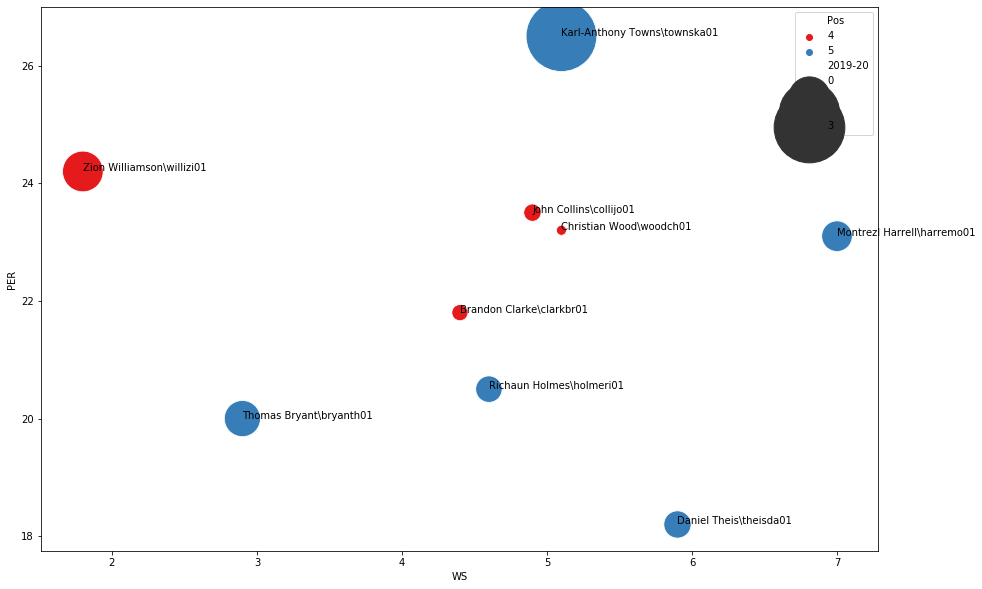

In [71]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Pos',size='2019-20',palette="Set1",sizes=(100,5000),data=advanced[advanced.Clusters == 11])

z = advanced[advanced.Clusters == 11].reset_index(drop=True).WS
y = advanced[advanced.Clusters == 11].reset_index(drop=True).PER
for i, txt in enumerate(advanced[advanced.Clusters == 11].reset_index(drop=True).Player):
    ax.annotate(txt, (z[i], y[i]))

In [72]:
advanced[advanced.Clusters == 12]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
8    Giannis Antetokounmpo\antetgi01    4   25  MIL  57  1763  31.6  0.608   
63            Jimmy Butler\butleji01    3   30  MIA  54  1851  23.4  0.583   
97           Anthony Davis\davisan02    4   26  LAL  55  1889  28.2  0.614   
108            Luka Dončić\doncilu01    1   20  DAL  54  1799  27.7  0.584   
160           James Harden\hardeja01    2   30  HOU  61  2241  28.4  0.616   
207           LeBron James\jamesle01    1   35  LAL  60  2094  26.0  0.582   
212           Nikola Jokić\jokicni01    5   24  DEN  65  2101  25.0  0.604   
240          Kawhi Leonard\leonaka01    3   28  LAC  51  1643  26.7  0.585   
243         Damian Lillard\lillada01    1   29  POR  58  2140  26.2  0.619   
319              Chris Paul\paulch01    1   34  OKC  63  2003  21.7  0.609   
359            Ben Simmons\simmobe01    1   23  PHI  54  1930  20.8  0.608   

      3PAr    FTr  ...  DWS    WS  WS/48  OBPM  DBPM   BPM  VORP     2019-20  \
8    0.238  0.500  ...  4.8  10.4  0.282   7.4   4.1  11.5   6.0  25842697.0   
63   0.162  0.679  ...  2.5   8.5  0.219   4.0   1.3   5.2   3.4  32742000.0   
97   0.195  0.460  ...  4.1  10.3  0.262   5.8   2.8   8.5   5.0  27093019.0   
108  0.442  0.442  ...  2.3   8.1  0.215   7.3   1.1   8.4   4.7   7683360.0   
160  0.555  0.519  ...  2.7  11.5  0.245   7.9   1.2   9.0   6.3  37800000.0   
207  0.324  0.292  ...  3.4   9.5  0.218   6.8   1.9   8.7   5.7  37436858.0   
212  0.233  0.277  ...  3.2   9.2  0.209   5.4   2.3   7.6   5.1  26573595.0   
240  0.287  0.344  ...  3.0   7.6  0.222   6.5   2.5   9.0   4.6  32742000.0   
243  0.493  0.377  ...  0.7   9.6  0.215   7.9  -0.7   7.2   5.0  29802321.0   
319  0.347  0.311  ...  2.5   8.1  0.194   3.1   1.2   4.3   3.2  38506482.0   
359  0.010  0.460  ...  3.2   7.0  0.174   1.4   2.4   3.9   2.9   8113930.0   

      Guaranteed  Clusters  
8     53370787.0        12  
63   103137300.0        12  
97    27093019.0        12  
108   15732720.0        12  
160  122472000.0        12  
207   76656423.0        12  
212  118104864.0        12  
240   67121100.0        12  
243  257429274.0        12  
319   79865296.0        12  
359  177763930.0        12  

[11 rows x 29 columns]

In [73]:
advanced[advanced.Clusters == 13]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
7              Kyle Anderson\anderky01    4   26  MEM  59  1140  13.0  0.542   
16                 Lonzo Ball\balllo01    1   22  NOP  56  1817  13.7  0.529   
22             Nicolas Batum\batumni01    3   31  CHO  22   505   9.2  0.463   
24             Kent Bazemore\bazemke01    3   30  TOT  64  1604   9.2  0.500   
30           DeAndre' Bembry\bembrde01    2   25  ATL  43   915   9.6  0.500   
54               Bruce Brown\brownbr01    2   23  DET  58  1634  11.9  0.518   
69              Jevon Carter\carteje01    1   24  PHO  50   754  10.4  0.535   
71   Michael Carter-Williams\cartemi01    2   28  ORL  42   773  15.7  0.539   
72               Alex Caruso\carusal01    1   25  LAL  58  1032  11.0  0.538   
114                 Kris Dunn\dunnkr01    1   25  CHI  51  1269  12.1  0.510   
131           Markelle Fultz\fultzma01    1   21  ORL  64  1813  14.4  0.523   
151           Draymond Green\greendr01    4   29  GSW  43  1222  12.6  0.489   
153            Javonte Green\greenja02    3   26  BOS  44   414  12.3  0.558   
161         Maurice Harkless\harklma01    3   26  TOT  62  1427   9.7  0.572   
163              Gary Harris\harriga01    2   25  DEN  56  1780   9.7  0.519   
166       Shaquille Harrison\harrish01    3   26  CHI  43   484  17.8  0.559   
194           Andre Iguodala\iguodan01    2   36  MIA  14   259  11.0  0.559   
202             Josh Jackson\jacksjo02    2   22  MEM  18   357  14.0  0.539   
210            James Johnson\johnsja01    4   32  TOT  32   619  14.8  0.572   
216              Cory Joseph\josepco01    1   28  SAC  64  1538  10.3  0.513   
258             Caleb Martin\martica02    3   24  CHO  18   317  12.0  0.595   
259              Cody Martin\martico01    3   24  CHO  48   903  10.5  0.505   
261            Patrick McCaw\mccawpa01    3   24  TOR  37   908   7.3  0.500   
263           T.J. McConnell\mccontj01    1   27  IND  63  1188  16.2  0.541   
274        De'Anthony Melton\meltode01    1   21  MEM  52  1011  14.6  0.525   
291          Dejounte Murray\murrade01    1   23  SAS  58  1447  17.1  0.535   
297           Shabazz Napier\napiesh01    1   28  TOT  51  1234  14.5  0.555   
298                 Raul Neto\netora01    1   27  PHI  49   565  11.5  0.562   
302          Frank Ntilikina\ntilila01    1   21  NYK  57  1187   9.8  0.497   
309               Elie Okobo\okoboel01    1   22  PHO  54   707  10.5  0.511   
310              Josh Okogie\okogijo01    2   21  MIN  62  1547  11.5  0.553   
314            Jabari Parker\parkeja01    4   24  TOT  33   852  17.0  0.561   
320            Elfrid Payton\paytoel01    1   25  NYK  45  1246  16.0  0.470   
340              Rajon Rondo\rondora01    1   33  LAL  48   984  12.4  0.494   
349         Tomáš Satoranský\satorto01    1   28  CHI  65  1878  13.5  0.533   
353          Thabo Sefolosha\sefolth01    4   35  HOU  41   436   9.5  0.487   
374         Matisse Thybulle\thybuma01    2   22  PHI  57  1110   9.8  0.530   
384         Denzel Valentine\valende01    3   26  CHI  36   488  13.0  0.511   
393           Brad Wanamaker\wanambr01    1   30  BOS  63  1215  11.8  0.560   
412           Thaddeus Young\youngth01    4   31  CHI  64  1591  13.3  0.521   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
7    0.221  0.236  ...  1.4  2.2  0.095  -1.3   1.9  0.6   0.7   9073050.0   
16   0.578  0.107  ...  1.9  2.6  0.068   0.4   0.6  1.0   1.3   8719320.0   
22   0.605  0.123  ...  0.4  0.6  0.055  -2.7   0.9 -1.9   0.0  25565217.0   
24   0.461  0.287  ...  1.5  0.7  0.020  -3.4   0.4 -3.0  -0.4  19269662.0   
30   0.285  0.211  ...  0.7  0.2  0.011  -3.5   1.0 -2.4  -0.1   2603982.0   
54   0.215  0.266  ...  1.4  2.1  0.062  -2.0   0.8 -1.2   0.3   1416852.0   
69   0.571  0.122  ...  0.7  1.1  0.068  -1.6   1.0 -0.6   0.3   1416852.0   
71   0.281  0.360  ...  1.1  1.9  0.116  -1.3   1.7  0.4   0.5   2028594.0   
72   0.412  0.292  ...  1.6  2.2  0.103  -2.4   2

In [74]:
advanced[advanced.Clusters == 14]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0         Steven Adams\adamsst01    5   26  OKC  58  1564  20.8  0.605  0.007   
1          Bam Adebayo\adebaba01    4   22  MIA  65  2235  20.6  0.606  0.018   
5        Jarrett Allen\allenja01    5   21  BRK  64  1647  20.3  0.658  0.012   
117        Joel Embiid\embiijo01    5   25  PHI  44  1329  26.0  0.593  0.230   
143        Rudy Gobert\goberru01    5   27  UTA  62  2142  21.7  0.700  0.000   
188      Dwight Howard\howardw01    5   34  LAL  62  1193  18.7  0.696  0.019   
189      Dwight Howard\howardw01    5   34  LAL  62  1193  18.7  0.696  0.019   
215     DeAndre Jordan\jordade01    5   31  BRK  56  1234  20.0  0.682  0.000   
266       JaVale McGee\mcgeeja01    5   32  LAL  61  1023  20.0  0.655  0.021   
300        Nerlens Noel\noelne01    5   25  OKC  55  1014  21.7  0.714  0.012   
339  Mitchell Robinson\robinmi01    5   21  NYK  61  1412  23.5  0.726  0.000   
346   Domantas Sabonis\sabondo01    5   23  IND  62  2159  20.7  0.586  0.079   
383  Jonas Valančiūnas\valanjo01    5   27  MEM  62  1630  22.3  0.631  0.120   
399   Hassan Whiteside\whiteha01    5   30  POR  61  1911  25.0  0.641  0.010   
416        Ivica Zubac\zubaciv01    5   22  LAC  64  1156  21.0  0.642  0.006   

       FTr  ...  DWS    WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0    0.413  ...  2.5   6.2  0.190   2.1   1.1  3.2   2.0  25842697.0   
1    0.476  ...  3.6   8.1  0.175   1.6   2.1  3.6   3.2   3454080.0   
5    0.574  ...  2.8   7.1  0.207   1.0   1.1  2.1   1.7   2376840.0   
117  0.545  ...  2.4   5.6  0.203   4.1   1.2  5.2   2.4  27504630.0   
143  0.725  ...  4.0  10.0  0.225   1.8   1.9  3.7   3.1  25008427.0   
188  0.700  ...  2.4   5.0  0.202  -0.8   1.4  0.5   0.8   3039097.0   
189  0.700  ...  2.4   5.0  0.202  -0.8   1.4  0.5   0.8   2564753.0   
215  0.425  ...  2.3   5.3  0.204   1.1   1.8  2.8   1.5   9881598.0   
266  0.265  ...  2.3   4.5  0.211  -0.3   2.3  2.1   1.1   4000000.0   
300  0.386  ...  2.1   4.8  0.225   0.5   3.4  4.0   1.5   2028594.0   
339  0.434  ...  2.0   6.8  0.230   1.6   1.3  3.0   1.8   1559712.0   
346  0.349  ...  3.3   7.6  0.168   2.1   1.1  3.2   2.9   3529555.0   
383  0.256  ...  2.4   6.2  0.182   2.2   0.0  2.3   1.8  16000000.0   
399  0.333  ...  3.0   8.1  0.204   2.5   0.7  3.2   2.5  27093018.0   
416  0.420  ...  2.0   5.6  0.231   1.5   1.0  2.5   1.3   6481482.0   

      Guaranteed  Clusters  
0     53370787.0        14  
1      8569572.0        14  
5      6286742.0        14  
117  122242800.0        14  
143   51533708.0        14  
188    3039097.0        14  
189    2564753.0        14  
215   39960716.0        14  
266    8200000.0        14  
300    2028594.0        14  
339    1559712.0        14  
346   80529555.0        14  
383   45000000.0        14  
399   27093018.0        14  
416   21000000.0        14  

[15 rows x 29 columns]

In [75]:
advanced[advanced.Clusters == 15]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
23           Aron Baynes\baynear01    5   33  PHO  42   934  15.1  0.581   
87       Pat Connaughton\connapa01    2   27  MIL  61  1119  11.2  0.558   
92           Jae Crowder\crowdja01    3   29  TOT  58  1695  12.1  0.532   
99         Terence Davis\daviste02    2   22  TOR  64  1087  14.5  0.598   
126  Dorian Finney-Smith\finnedo01    4   26  DAL  64  1898  12.2  0.597   
138               Rudy Gay\gayru01    4   33  SAS  60  1287  14.4  0.545   
145         Aaron Gordon\gordoaa01    4   24  ORL  58  1914  14.8  0.511   
152       JaMychal Green\greenja01    4   29  LAC  55  1130  10.8  0.554   
167             Josh Hart\hartjo01    3   24  NOP  57  1563  11.7  0.556   
193          Serge Ibaka\ibakase01    5   30  TOR  50  1377  18.0  0.593   
195       Ersan İlyasova\ilyaser01    4   32  MIL  56   895  15.2  0.591   
217       Frank Kaminsky\kaminfr01    5   26  PHO  32   718  14.5  0.554   
222          Maxi Kleber\klebima01    5   28  DAL  66  1695  13.8  0.603   
241       Meyers Leonard\leoname01    5   27  MIA  49   987  11.1  0.640   
252           Trey Lyles\lylestr01    4   24  SAS  63  1271  12.7  0.557   
257      Lauri Markkanen\markkla01    4   22  CHI  50  1492  14.3  0.560   
278         Paul Millsap\millspa01    4   34  DEN  44  1075  17.7  0.598   
312         Kelly Olynyk\olynyke01    5   28  MIA  59  1089  14.7  0.640   
327         Bobby Portis\portibo01    5   24  NYK  66  1393  14.6  0.530   
331        Julius Randle\randlju01    4   25  NYK  64  2080  17.5  0.538   
348          Dario Šarić\saricda01    4   25  PHO  58  1441  13.3  0.572   
382         Myles Turner\turnemy01    5   23  IND  55  1628  14.7  0.561   
395      P.J. Washington\washipj01    4   21  CHO  58  1759  12.4  0.547   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
23   0.441  0.197  ...  0.7  2.0  0.103  -0.2  -0.9 -1.1   0.2   5453280.0   
87   0.525  0.138  ...  2.1  3.0  0.130  -1.1   1.6  0.5   0.7   1723050.0   
92   0.692  0.236  ...  2.0  3.2  0.090  -0.9   0.3 -0.6   0.6   7815533.0   
99   0.568  0.133  ...  1.6  3.0  0.133   0.7   0.6  1.3   0.9    898310.0   
126  0.580  0.212  ...  1.6  4.5  0.114   0.0  -0.1 -0.2   0.9   4000000.0   
138  0.369  0.225  ...  0.9  1.5  0.054  -0.5  -1.0 -1.5   0.2  14000000.0   
145  0.311  0.280  ...  2.2  3.3  0.084  -0.3   0.1 -0.3   0.8  19863636.0   
152  0.675  0.146  ...  1.8  2.6  0.111  -1.4   0.6 -0.8   0.3   4767000.0   
167  0.676  0.189  ...  1.7  2.7  0.083  -1.2   0.6 -0.6   0.6   1934160.0   
193  0.266  0.191  ...  2.4  3.9  0.136   0.5  -0.1  0.4   0.9  23271604.0   
195  0.428  0.259  ...  1.9  3.4  0.180  -0.2   0.8  0.6   0.6   7000000.0   
217  0.401  0.315  ...  0.6  1.4  0.092   0.2  -0.3 -0.1   0.3   4767000.0   
222  0.614  0.172  ...  1.7  4.6  0.131   0.5   0.2  0.6   1.1   8000000.0   
241  0.534  0.117  ...  1.1  2.1  0.104  -1.0   0.4 -0.6   0.3  11286515.0   
252  0.490  0.131  ...  1.0  2.2  0.081  -0.5  -0.7 -1.2   0.2   5500000.0   
257  0.536  0.259  ...  1.6  2.6  0.084   0.2  -0.8 -0.5   0.5   5300400.0   
278  0.282  0.326  ...  1.4  3.4  0.151   0.6   0.0  0.6   0.7  30500000.0   
312  0.584  0.259  ...  1.5  3.2  0.140   0.1   1.0  1.1   0.8  11667885.0   
327  0.317  0.158  ...  1.0  1.9  0.064   0.1  -1.1 -1.0   0.3  15000000.0   
331  0.230  0.350  ...  1.7  2.7  0.062   0.7  -1.0 -0.3   0.9  18000000.0   
348  0.455  0.202  ...  1.2  2.7  0.091  -0.5  -0.4 -0.9   0.4   3481986.0   
382  0.443  0.279  ...  2.8  3.7  0.111  -0.9   1.1  0.2   0.9  18000000.0   
395  0.390  0.231  ...  1.4  2.0  0.054  -1.7   0.1 -1.6   0.2   3831840.0   

     Guaranteed  Clusters  
23    5453280.0        15  
87    1723050.0        15  
92    7815533.0        15  
99     898310.0        15  
126  12000000.0        15  
138  28000000.0        15  
145  54409091.0        15  
152   4767000.0        15  
167   5425319.0        15  
193  23271604.0        15  
195   7000000.0       

## Point Guards

In [197]:
pg.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0  Ryan Arcidiacono\arcidry01    1   25  CHI  58   930   9.0  0.551  0.627   
1     D.J. Augustin\augusdj01    1   32  ORL  49  1215  14.2  0.548  0.438   
2         Lonzo Ball\balllo01    1   22  NOP  56  1817  13.7  0.529  0.578   
3        J.J. Barea\bareajo01    1   35  DAL  26   391  14.9  0.519  0.425   
4  Patrick Beverley\beverpa01    1   31  LAC  48  1299  12.3  0.554  0.609   

     FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  Guaranteed  \
0  0.173  ...  0.7  1.4  0.070  -2.7  -0.1 -2.8  -0.2   3000000.0   6000000.0   
1  0.395  ...  0.8  2.6  0.101  -0.3  -1.0 -1.4   0.2   7250000.0   7250000.0   
2  0.107  ...  1.9  2.6  0.068   0.4   0.6  1.0   1.3   8719320.0  19723102.0   
3  0.101  ...  0.2  0.7  0.084   1.8  -2.7 -1.0   0.1   2564753.0   2564753.0   
4  0.126  ...  2.0  3.4  0.126  -0.5   2.6  2.1   1.3  12345679.0  40000000.0   

   Clusters  
0         5  
1        10  
2        13  
3         9  
4         2  

[5 rows x 29 columns]

In [198]:
pg_clust=pg.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [199]:
pg_clust.describe()

Age           MP        PER        TS%       3PAr        FTr  \
count  74.000000    74.000000  74.000000  74.000000  74.000000  74.000000   
mean   26.594595  1204.391892  14.741892   0.543378   0.389027   0.233932   
std     4.144377   573.355201   4.740643   0.045665   0.147388   0.097483   
min    20.000000   248.000000   6.800000   0.424000   0.010000   0.052000   
25%    23.000000   718.250000  11.125000   0.517000   0.305000   0.160250   
50%    26.000000  1233.000000  14.600000   0.538500   0.407000   0.219500   
75%    30.000000  1687.250000  17.400000   0.566500   0.464750   0.292000   
max    35.000000  2211.000000  27.700000   0.668000   0.784000   0.460000   

            ORB%       DRB%       TRB%       AST%  ...       USG%        OWS  \
count  74.000000  74.000000  74.000000  74.000000  ...  74.000000  74.000000   
mean    2.536486  11.206757   6.879730  25.908108  ...  20.991892   1.486486   
std     1.132167   3.604956   2.180736   9.008881  ...   5.968450   1.745234   
min     0.800000   5.200000   3.400000   8.600000  ...   8.100000  -1.300000   
25%     1.700000   8.750000   5.425000  19.325000  ...  17.200000   0.325000   
50%     2.350000  10.750000   6.550000  24.400000  ...  20.400000   1.100000   
75%     3.000000  12.550000   7.825000  33.150000  ...  24.250000   2.100000   
max     6.200000  24.700000  14.600000  49.700000  ...  37.000000   8.900000   

             DWS         WS      WS/48       OBPM       DBPM        BPM  \
count  74.000000  74.000000  74.000000  74.000000  74.000000  74.000000   
mean    1.087838   2.579730   0.090473   0.145946  -0.229730  -0.083784   
std     0.828260   2.314515   0.060620   2.818004   1.389661   3.099316   
min    -0.100000  -1.300000  -0.064000  -4.900000  -3.900000  -6.000000   
25%     0.400000   0.900000   0.065500  -1.975000  -1.275000  -1.700000   
50%     0.850000   2.300000   0.086000  -0.050000  -0.200000  -0.450000   
75%     1.600000   3.475000   0.114500   1.800000   0.675000   1.550000   
max     3.400000   9.600000   0.220000   7.900000   3.100000   8.700000   

            VORP   Clusters  
count  74.000000  74.000000  
mean    0.816216   8.418919  
std     1.281056   4.200479  
min    -1.700000   0.000000  
25%     0.100000   8.000000  
50%     0.450000   9.000000  
75%     1.400000  12.000000  
max     5.700000  13.000000  

[8 rows x 23 columns]

In [200]:
scaler = preprocessing.StandardScaler().fit(pg_clust)
dfNorm = scaler.transform(pg_clust)

In [201]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [202]:
print(sse)

[1263.4948248426924, 1086.1145625457975, 979.4969287807178, 889.7280056920464, 826.6121343924156, 769.34974423716, 737.043792804226, 699.9597814400336, 667.5620693656953, 638.1569855525688, 613.1829534876899, 571.5098448049764, 534.8996638597512, 514.3288611746522, 490.3607158770527, 471.9990094329766, 449.3744891523855, 428.5913852901915]


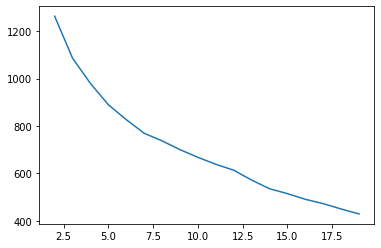

In [203]:
plt.plot(range(2,maxClusters),sse)

In [204]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [205]:
print(silh)

[0.2537213200313383, 0.14680459799522588, 0.13576208353019512, 0.12913957436761878, 0.135042679266331, 0.12051568379332309, 0.11593743028016998, 0.14982346838367996, 0.10821684484777022, 0.11567179702001974, 0.11532669406654769, 0.14023121120771684, 0.14885390293309467, 0.14952867404808934, 0.16189626003817587, 0.15967729389539187, 0.15597245711989804, 0.1600377098768781]


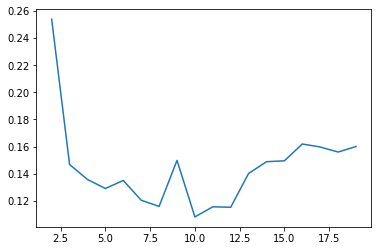

In [206]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 5 The average silhouette_score is : 0.12913957436761886
For n_clusters = 6 The average silhouette_score is : 0.135042679266331
For n_clusters = 8 The average silhouette_score is : 0.11593743028016998
For n_clusters = 9 The average silhouette_score is : 0.14982346838367994
For n_clusters = 10 The average silhouette_score is : 0.10821684484777028


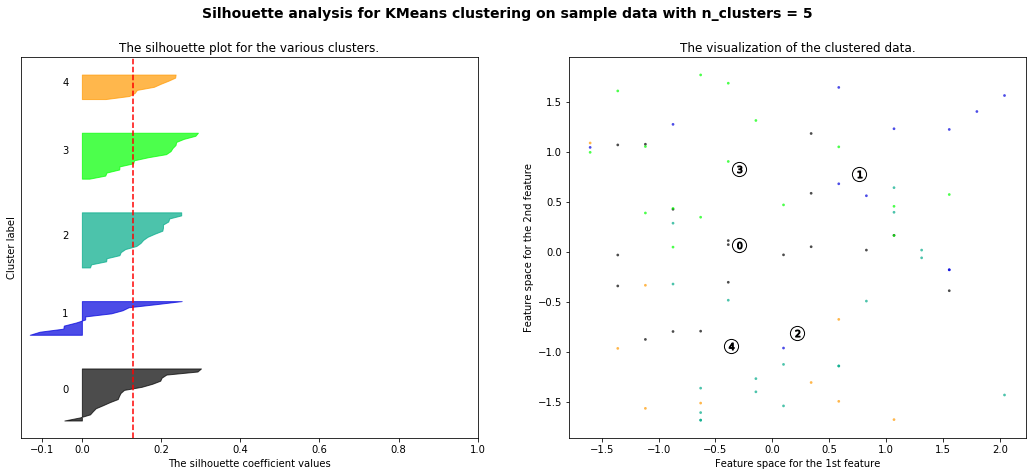

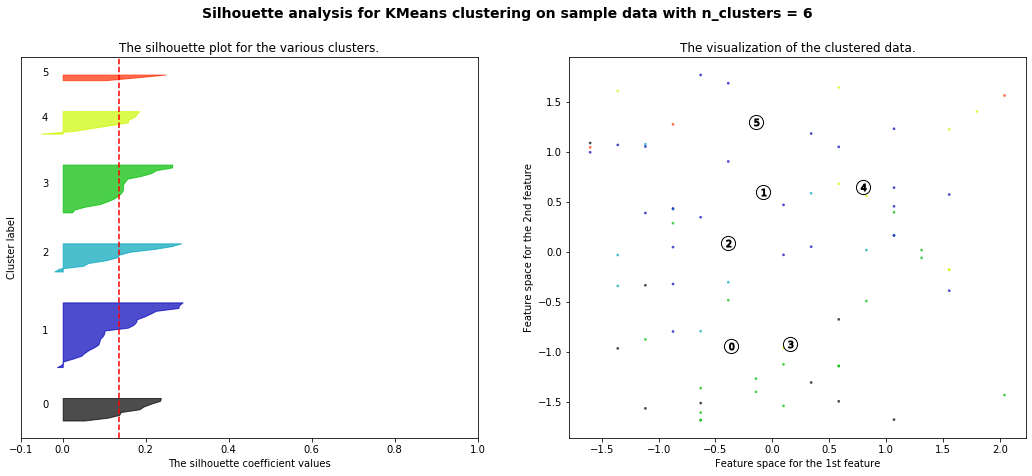

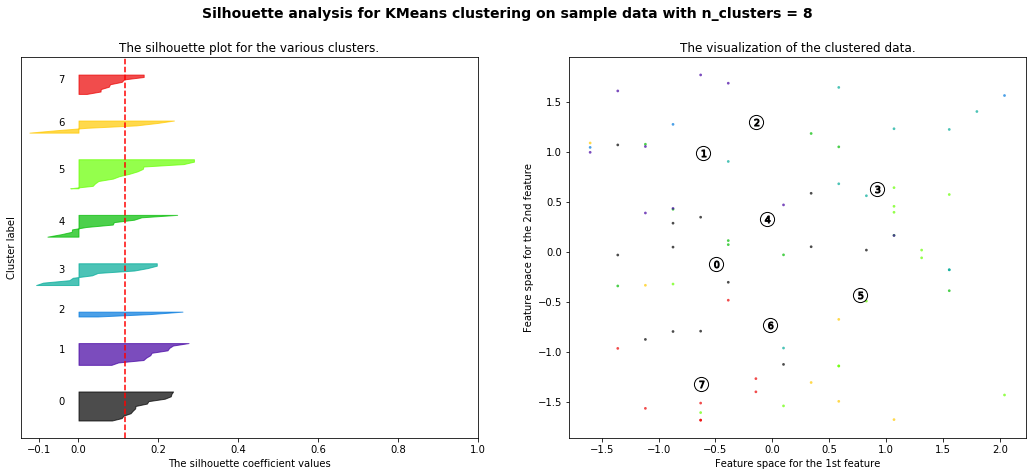

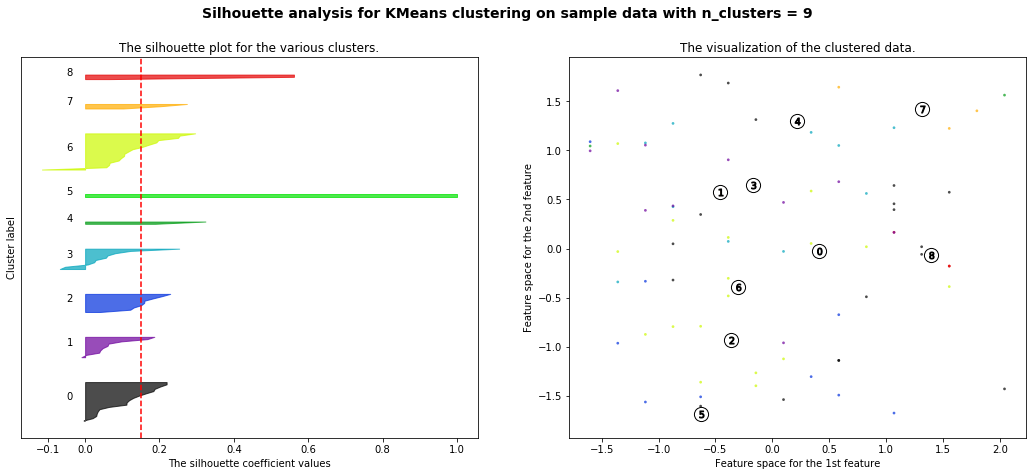

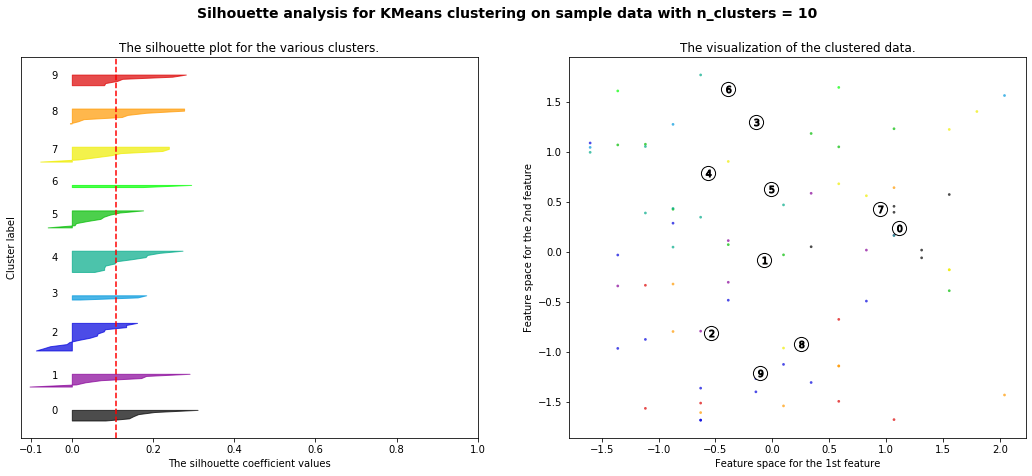

In [207]:
range_n_clusters = [5,6,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## PG Clustering

In [208]:
labels = KMeans(n_clusters=10, random_state=0).fit_predict(dfNorm)

In [210]:
pg_clust = pg_clust.drop(columns=['Clusters'])

In [211]:
pg_clust['Clusters'] = labels

In [212]:
pg['Clusters'] = labels

In [213]:
pg_clust['Clusters'].value_counts()

2    14
4    11
5     9
8     8
7     8
1     7
9     6
0     6
3     3
6     2
Name: Clusters, dtype: int64

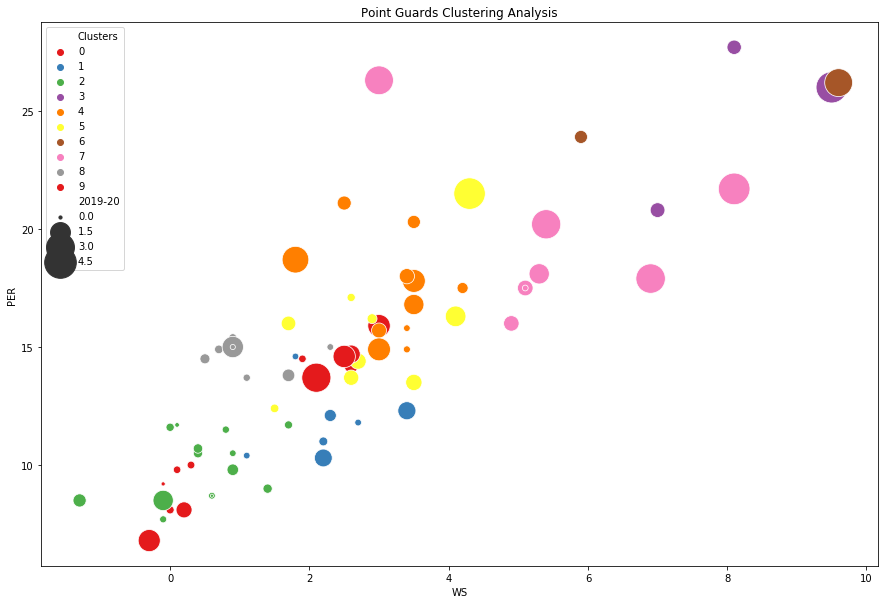

In [273]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x='WS',y='PER',hue='Clusters',size='2019-20',sizes=(10,1000),palette="Set1",data=pg)

#z = pg.WS
#y = pg.PER
#for i, txt in enumerate(pg.Player):
#    ax.annotate(txt, (z[i], y[i]))
    
plt.title('Point Guards Clustering Analysis')
plt.show()

In [229]:
pg_clust.groupby('Clusters').mean().sort_values(by=['PER'],ascending=False)

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
6         25.000000  2130.000000  25.050000  0.607000  0.474000  0.412500   
3         26.000000  1941.000000  24.833333  0.591333  0.258667  0.398000   
7         30.500000  1450.375000  19.400000  0.602875  0.435875  0.281000   
4         24.272727  1653.090909  17.409091  0.551182  0.339727  0.236182   
5         26.555556  1564.444444  15.677778  0.521667  0.259667  0.194778   
8         27.625000   683.375000  14.662500  0.545625  0.366750  0.191875   
0         31.166667  1340.833333  14.600000  0.557833  0.466667  0.316833   
1         26.285714  1159.714286  11.785714  0.533571  0.413714  0.217143   
2         24.357143   745.928571   9.935714  0.530500  0.488643  0.190500   
9         26.166667   517.000000   8.666667  0.461167  0.338667  0.178333   

              ORB%       DRB%       TRB%       AST%  ...       TOV%  \
Clusters                                             ...              
6         1.550000  11.000000   6.300000  39.850000  ...  13.600000   
3         4.466667  21.233333  13.000000  43.266667  ...  16.833333   
7         2.637500  11.587500   7.287500  27.387500  ...  12.475000   
4         2.000000  10.409091   6.190909  30.472727  ...  12.990909   
5         3.600000  14.444444   8.988889  32.444444  ...  17.577778   
8         2.825000  10.312500   6.587500  26.087500  ...  13.262500   
0         1.933333   8.850000   5.383333  24.866667  ...  13.916667   
1         2.828571  12.328571   7.571429  17.114286  ...  14.828571   
2         1.807143   8.857143   5.285714  17.428571  ...  13.957143   
9         2.733333  10.083333   6.366667  23.283333  ...  20.033333   

               USG%       OWS       DWS        WS     WS/48      OBPM  \
Clusters                                                                
6         32.550000  7.150000  0.600000  7.750000  0.174500  7.100000   
3         29.833333  5.233333  2.966667  8.200000  0.202333  5.166667   
7         23.037500  3.275000  2.175000  5.475000  0.186250  2.862500   
4         25.381818  2.027273  1.145455  3.200000  0.095000  1.872727   
5         20.733333  1.222222  1.677778  2.877778  0.087889 -0.211111   
8         21.887500  0.750000  0.375000  1.125000  0.085750  0.712500   
0         21.233333  1.650000  0.800000  2.450000  0.087333  0.350000   
1         14.771429  0.757143  1.457143  2.242857  0.091857 -2.057143   
2         17.421429  0.057143  0.400000  0.450000  0.040286 -2.214286   
9         16.483333 -0.250000  0.283333  0.033333 -0.000667 -3.816667   

              DBPM       BPM      VORP  
Clusters                                
6        -1.500000  5.600000  4.100000  
3         1.800000  7.000000  4.433333  
7         0.987500  3.837500  2.050000  
4        -1.000000  0.890909  1.172727  
5         0.300000  0.077778  0.822222  
8        -1.225000 -0.537500  0.225000  
0        -1.000000 -0.666667  0.466667  
1         1.771429 -0.257143  0.485714  
2        -0.842857 -3.071429 -0.278571  
9        -0.633333 -4.416667 -0.316667  

[10 rows x 22 columns]

In [230]:
pg[pg.Clusters == 6]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
37  Damian Lillard\lillada01    1   29  POR  58  2140  26.2  0.619  0.493   
73      Trae Young\youngtr01    1   21  ATL  60  2120  23.9  0.595  0.455   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
37  0.377  ...  0.7  9.6  0.215   7.9  -0.7  7.2   5.0  29802321.0   
73  0.448  ...  0.5  5.9  0.134   6.3  -2.3  4.0   3.2   6273000.0   

     Guaranteed  Clusters  
37  257429274.0         6  
73   12844800.0         6  

[2 rows x 29 columns]

In [231]:
pg[pg.Clusters == 3]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
15   Luka Dončić\doncilu01    1   20  DAL  54  1799  27.7  0.584  0.442   
32  LeBron James\jamesle01    1   35  LAL  60  2094  26.0  0.582  0.324   
60   Ben Simmons\simmobe01    1   23  PHI  54  1930  20.8  0.608  0.010   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
15  0.442  ...  2.3  8.1  0.215   7.3   1.1  8.4   4.7   7683360.0   
32  0.292  ...  3.4  9.5  0.218   6.8   1.9  8.7   5.7  37436858.0   
60  0.460  ...  3.2  7.0  0.174   1.4   2.4  3.9   2.9   8113930.0   

     Guaranteed  Clusters  
15   15732720.0         3  
32   76656423.0         3  
60  177763930.0         3  

[3 rows x 29 columns]

In [232]:
pg[pg.Clusters == 7]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
5    Eric Bledsoe\bledser01    1   30  MIL  56  1524  18.1  0.579  0.304   
25     George Hill\hillge01    1   33  MIL  52  1103  17.5  0.668  0.452   
26     George Hill\hillge01    1   33  MIL  52  1103  17.5  0.668  0.452   
28   Kyrie Irving\irvinky01    1   27  BRK  20   658  26.3  0.595  0.341   
38     Kyle Lowry\lowryky01    1   33  TOR  52  1901  17.9  0.589  0.583   
51      Chris Paul\paulch01    1   34  OKC  63  2003  21.7  0.609  0.347   
67  Fred VanVleet\vanvlfr01    1   25  TOR  48  1719  16.0  0.546  0.482   
68   Kemba Walker\walkeke02    1   29  BOS  50  1592  20.2  0.569  0.526   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
5   0.292  ...  2.9  5.3  0.168   1.1   1.1  2.2   1.6  15625000.0   
25  0.247  ...  1.9  5.1  0.220   1.8   1.4  3.2   1.5   9133907.0   
26  0.247  ...  1.9  5.1  0.220   1.8   1.4  3.2   1.5   1000000.0   
28  0.245  ...  0.8  3.0  0.216   6.6   1.0  7.6   1.6  31742000.0   
38  0.399  ...  2.8  6.9  0.173   2.5   0.7  3.2   2.5  33296296.0   
51  0.311  ...  2.5  8.1  0.194   3.1   1.2  4.3   3.2  38506482.0   
67  0.237  ...  2.7  4.9  0.136   1.0   1.3  2.3   1.8   9000000.0   
68  0.270  ...  1.9  5.4  0.163   5.0  -0.2  4.7   2.7  32742000.0   

     Guaranteed  Clusters  
5    54525000.0         7  
25   21000000.0         7  
26   21000000.0         7  
28  136490600.0         7  
38   63296296.0         7  
51   79865296.0         7  
67    9000000.0         7  
68  103137300.0         7  

[8 rows x 29 columns]

In [233]:
pg[pg.Clusters == 4]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
7    Malcolm Brogdon\brogdma01    1   27  IND  48  1472  17.8  0.537  0.296   
19        De'Aaron Fox\foxde01    1   22  SAC  45  1426  20.3  0.556  0.221   
24   Devonte' Graham\grahade01    1   24  CHO  63  2211  15.8  0.537  0.607   
34        Tyus Jones\jonesty01    1   23  MEM  65  1232  15.7  0.532  0.289   
42         Ja Morant\moranja01    1   20  MEM  59  1771  18.0  0.568  0.174   
43      Monte Morris\morrimo01    1   24  DEN  65  1402  14.9  0.537  0.298   
46      Jamal Murray\murraja01    1   22  DEN  55  1804  17.5  0.559  0.359   
54       Derrick Rose\rosede01    1   31  DET  50  1298  21.1  0.555  0.195   
55      Terry Rozier\roziete01    1   25  CHO  63  2164  14.9  0.553  0.450   
57  D'Angelo Russell\russeda01    1   23  TOT  45  1452  18.7  0.556  0.509   
59   Dennis Schröder\schrode01    1   26  OKC  63  1952  16.8  0.573  0.339   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
7   0.246  ...  1.4  3.5  0.113   2.2  -0.5  1.7   1.4  20000000.0   
19  0.442  ...  1.3  3.5  0.117   2.1  -0.3  1.8   1.4   6392760.0   
24  0.242  ...  0.9  3.4  0.073   2.6  -2.1  0.5   1.4   1416852.0   
34  0.135  ...  1.0  3.0  0.115   0.4   0.1  0.6   0.8   8408000.0   
42  0.331  ...  1.2  3.4  0.093   1.6  -1.3  0.4   1.1   8730240.0   
43  0.128  ...  1.2  3.4  0.117   0.2  -0.1  0.1   0.8   1588231.0   
46  0.209  ...  1.6  4.2  0.111   1.8  -0.7  1.1   1.4   4444746.0   
54  0.185  ...  0.6  2.5  0.093   4.0  -1.7  2.2   1.4   7317073.0   
55  0.202  ...  1.1  3.0  0.067   0.8  -1.3 -0.4   0.8  19894737.0   
57  0.235  ...  0.7  1.8  0.060   3.8  -1.9  1.9   1.4  27285000.0   
59  0.243  ...  1.6  3.5  0.086   1.1  -1.2 -0.1   1.0  15500000.0   

     Guaranteed  Clusters  
7    85000000.0         4  
19   14492387.0         4  
24    1416852.0         4  
34   23895300.0         4  
42   17897040.0         4  
43    1588231.0         4  
46  174094746.0         4  
54   15000000.0         4  
55   56700000.0         4  
57  117325500.0         4  
59   31000000.0         4  

[11 rows x 29 columns]

In [234]:
pg[pg.Clusters == 5]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
2           Lonzo Ball\balllo01    1   22  NOP  56  1817  13.7  0.529  0.578   
21     Markelle Fultz\fultzma01    1   21  ORL  64  1813  14.4  0.523  0.175   
39     T.J. McConnell\mccontj01    1   27  IND  63  1188  16.2  0.541  0.041   
45    Dejounte Murray\murrade01    1   23  SAS  58  1447  17.1  0.535  0.168   
52      Elfrid Payton\paytoel01    1   25  NYK  45  1246  16.0  0.470  0.157   
53        Rajon Rondo\rondora01    1   33  LAL  48   984  12.4  0.494  0.381   
56        Ricky Rubio\rubiori01    1   29  PHO  57  1802  16.3  0.531  0.308   
58   Tomáš Satoranský\satorto01    1   28  CHI  65  1878  13.5  0.533  0.361   
72  Russell Westbrook\westbru01    1   31  HOU  53  1905  21.5  0.539  0.168   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
2   0.107  ...  1.9  2.6  0.068   0.4   0.6  1.0   1.3   8719320.0   
21  0.209  ...  1.9  2.7  0.071  -1.9   0.2 -1.7   0.1   9745200.0   
39  0.099  ...  1.4  2.9  0.119   0.1   0.2  0.3   0.7   3500000.0   
45  0.175  ...  1.7  2.6  0.087  -0.5   1.5  1.0   1.1   2321735.0   
52  0.195  ...  1.2  1.7  0.065  -0.3   0.3  0.0   0.6   8000000.0   
53  0.125  ...  1.3  1.5  0.073  -1.1   0.0 -1.2   0.2   2564753.0   
56  0.334  ...  1.7  4.1  0.109   0.5   0.2  0.7   1.2  16190476.0   
58  0.220  ...  1.7  3.5  0.090  -1.0  -0.2 -1.2   0.4  10000000.0   
72  0.289  ...  2.3  4.3  0.109   1.9  -0.1  1.8   1.8  38178000.0   

     Guaranteed  Clusters  
2    19723102.0         5  
21   22033897.0         5  
39    4500000.0         5  
45   66321735.0         5  
52    9000000.0         5  
53    2564753.0         5  
56   51000000.0         5  
58   25000000.0         5  
72  123032000.0         5  

[9 rows x 29 columns]

In [235]:
pg[pg.Clusters == 8]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
3        J.J. Barea\bareajo01    1   35  DAL  26   391  14.9  0.519  0.425   
8     Jalen Brunson\brunsja01    1   23  DAL  57  1022  15.0  0.553  0.309   
9        Trey Burke\burketr01    1   27  PHI  25   329  15.4  0.545  0.299   
30   Reggie Jackson\jacksre01    1   29  TOT  23   556  15.0  0.533  0.440   
31   Reggie Jackson\jacksre01    1   29  TOT  23   556  15.0  0.533  0.440   
44  Emmanuel Mudiay\mudiaem01    1   23  UTA  48   752  13.7  0.550  0.263   
61        Ish Smith\smithis01    1   31  WAS  60  1570  13.8  0.512  0.258   
65    Allonzo Trier\trieral01    1   24  NYK  24   291  14.5  0.620  0.500   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
3   0.101  ...  0.2  0.7  0.084   1.8  -2.7 -1.0   0.1   2564753.0   
8   0.193  ...  0.7  2.3  0.108   0.1  -0.9 -0.8   0.3   1416582.0   
9   0.142  ...  0.2  0.9  0.129   0.7  -1.1 -0.5   0.1   2028594.0   
30  0.167  ...  0.3  0.9  0.077   1.8  -1.3  0.5   0.4  17286956.0   
31  0.167  ...  0.3  0.9  0.077   1.8  -1.3  0.5   0.4    734025.0   
44  0.239  ...  0.8  1.1  0.071  -1.2   0.1 -1.1   0.2   1737145.0   
61  0.120  ...  0.4  1.7  0.053  -0.3  -1.1 -1.4   0.2   5853659.0   
65  0.406  ...  0.1  0.5  0.087   1.0  -1.5 -0.5   0.1   3551100.0   

    Guaranteed  Clusters  
3    2564753.0         8  
8    3080443.0         8  
9    2028594.0         8  
30  17286956.0         8  
31    734025.0         8  
44   1737145.0         8  
61  12000000.0         8  
65   3551100.0         8  

[8 rows x 29 columns]

In [236]:
pg[pg.Clusters == 0]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
1    D.J. Augustin\augusdj01    1   32  ORL  49  1215  14.2  0.548  0.438   
12     Mike Conley\conlemi01    1   32  UTA  41  1171  13.7  0.527  0.438   
16    Goran Dragić\dragigo01    1   33  MIA  54  1531  15.9  0.571  0.472   
41     Patty Mills\millspa02    1   31  SAS  63  1430  14.7  0.589  0.675   
47  Shabazz Napier\napiesh01    1   28  TOT  51  1234  14.5  0.555  0.538   
63     Jeff Teague\teaguje01    1   31  TOT  59  1464  14.6  0.557  0.239   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
1   0.395  ...  0.8  2.6  0.101  -0.3  -1.0 -1.4   0.2   7250000.0   
12  0.241  ...  1.0  2.1  0.085   0.4  -0.4  0.0   0.6  32511623.0   
16  0.333  ...  1.1  3.0  0.095   1.4  -1.9 -0.5   0.6  19217900.0   
41  0.188  ...  0.5  2.6  0.086   1.1  -1.2 -0.1   0.7  12428571.0   
47  0.341  ...  0.8  1.9  0.075  -0.3  -0.2 -0.5   0.5   1882867.0   
63  0.403  ...  0.6  2.5  0.082  -0.2  -1.3 -1.5   0.2  19000000.0   

    Guaranteed  Clusters  
1    7250000.0         0  
12  54938006.0         0  
16  19217900.0         0  
41  25714285.0         0  
47   1882867.0         0  
63  19000000.0         0  

[6 rows x 29 columns]

In [237]:
pg[pg.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
4    Patrick Beverley\beverpa01    1   31  LAC  48  1299  12.3  0.554  0.609   
10       Jevon Carter\carteje01    1   24  PHO  50   754  10.4  0.535  0.571   
11        Alex Caruso\carusal01    1   25  LAL  58  1032  11.0  0.538  0.412   
17           Kris Dunn\dunnkr01    1   25  CHI  51  1269  12.1  0.510  0.327   
35        Cory Joseph\josepco01    1   28  SAC  64  1538  10.3  0.513  0.363   
40  De'Anthony Melton\meltode01    1   21  MEM  52  1011  14.6  0.525  0.331   
71     Brad Wanamaker\wanambr01    1   30  BOS  63  1215  11.8  0.560  0.283   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
4   0.126  ...  2.0  3.4  0.126  -0.5   2.6  2.1   1.3  12345679.0   
10  0.122  ...  0.7  1.1  0.068  -1.6   1.0 -0.6   0.3   1416852.0   
11  0.292  ...  1.6  2.2  0.103  -2.4   2.4  0.1   0.5   2750000.0   
17  0.158  ...  2.0  2.3  0.085  -3.7   3.1 -0.6   0.4   5348007.0   
35  0.157  ...  1.0  2.2  0.067  -2.1   0.3 -1.8   0.1  12000000.0   
40  0.300  ...  1.4  1.8  0.086  -1.6   1.8  0.3   0.6   1416852.0   
71  0.365  ...  1.5  2.7  0.108  -2.5   1.2 -1.3   0.2   1445697.0   

    Guaranteed  Clusters  
4   40000000.0         1  
10   1416852.0         1  
11   5500000.0         1  
17   5348007.0         1  
35  24600000.0         1  
40   1416852.0         1  
71   1445697.0         1  

[7 rows x 29 columns]

In [238]:
pg[pg.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0   Ryan Arcidiacono\arcidry01    1   25  CHI  58   930   9.0  0.551  0.627   
13         Quinn Cook\cookqu01    1   26  LAL  38   409  10.5  0.517  0.382   
18      Yogi Ferrell\ferreyo01    1   26  SAC  44   484  10.7  0.499  0.408   
22    Darius Garland\garlada01    1   20  CLE  59  1824   8.5  0.498  0.423   
23   Brandon Goodwin\goodwbr01    1   24  ATL  34   430  11.7  0.507  0.458   
27     Aaron Holiday\holidaa01    1   23  IND  58  1368  11.7  0.517  0.409   
29     Frank Jackson\jacksfr01    1   21  NOP  51   656   7.7  0.500  0.467   
36    Brandon Knight\knighbr03    1   28  TOT  25   462   8.5  0.503  0.784   
48          Raul Neto\netora01    1   27  PHI  49   565  11.5  0.562  0.406   
49   Frank Ntilikina\ntilila01    1   21  NYK  57  1187   9.8  0.497  0.411   
50        Elie Okobo\okoboel01    1   22  PHO  54   707  10.5  0.511  0.392   
64     Isaiah Thomas\thomais02    1   30  WAS  40   925  11.6  0.531  0.444   
69    Derrick Walton\waltode01    1   24  TOT  26   248   8.7  0.617  0.615   
70    Derrick Walton\waltode01    1   24  TOT  26   248   8.7  0.617  0.615   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0   0.173  ...  0.7  1.4  0.070  -2.7  -0.1 -2.8  -0.2   3000000.0   
13  0.052  ...  0.4  0.4  0.043  -2.3  -1.0 -3.3  -0.1   3000000.0   
18  0.219  ...  0.3  0.4  0.036  -2.1  -0.4 -2.5  -0.1   3150000.0   
22  0.103  ...  0.0 -1.3 -0.035  -2.7  -2.9 -5.6  -1.7   6400920.0   
23  0.158  ...  0.2  0.1  0.013  -1.5  -1.3 -2.9  -0.1    522738.0   
27  0.145  ...  1.4  1.7  0.060  -1.4  -0.3 -1.7   0.1   2239200.0   
29  0.249  ...  0.3 -0.1 -0.005  -4.0  -2.0 -6.0  -0.7   1618520.0   
36  0.204  ...  0.1 -0.1 -0.010  -1.8  -2.7 -4.4  -0.3  15643750.0   
48  0.177  ...  0.6  0.8  0.071  -1.8  -0.1 -1.9   0.0   1737145.0   
49  0.177  ...  0.8  0.9  0.037  -3.6   0.4 -3.2  -0.4   4855800.0   
50  0.370  ...  0.5  0.9  0.059  -2.0  -0.1 -2.1   0.0   1416852.0   
64  0.178  ... -0.1  0.0  0.001  -0.5  -3.9 -4.4  -0.6   2320044.0   
69  0.231  ...  0.2  0.6  0.112  -2.3   1.3 -1.1   0.1   1445697.0   
70  0.231  ...  0.2  0.6  0.112  -2.3   1.3 -1.1   0.1     81678.0   

    Guaranteed  Clusters  
0    6000000.0         2  
13   4000000.0         2  
18   3150000.0         2  
22  13121640.0         2  
23    522738.0         2  
27   4584840.0         2  
29   1618520.0         2  
36  15643750.0         2  
48   1737145.0         2  
49  11032378.0         2  
50   1416852.0         2  
64   2320044.0         2  
69   1445697.0         2  
70     81678.0         2  

[14 rows x 29 columns]

In [224]:
pg[pg.Clusters == 9]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
6             Ky Bowman\bowmaky01    1   22  GSW  45  1015   9.2  0.494   
14  Matthew Dellavedova\dellama01    1   29  CLE  57   821   8.1  0.463   
20          Tim Frazier\fraziti01    1   29  DET  27   355   9.8  0.464   
33            Ty Jerome\jeromty01    1   22  PHO  28   315   8.1  0.437   
62        Edmond Sumner\sumneed01    1   24  IND  25   345  10.0  0.485   
66          Evan Turner\turneev01    1   31  ATL  19   251   6.8  0.424   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
6   0.333  0.128  ...  0.6 -0.1 -0.003  -4.0  -0.3 -4.3  -0.6    350189.0   
14  0.520  0.211  ...  0.1  0.2  0.010  -3.6  -1.6 -5.2  -0.7   9607500.0   
20  0.319  0.255  ...  0.2  0.1  0.016  -2.9  -1.6 -4.5  -0.2   1882867.0   
33  0.443  0.132  ...  0.3  0.0 -0.002  -3.9   0.0 -3.8  -0.1   2193480.0   
62  0.342  0.135  ...  0.4  0.3  0.039  -3.6   0.4 -3.1  -0.1   2000000.0   
66  0.075  0.209  ...  0.1 -0.3 -0.064  -4.9  -0.7 -5.6  -0.2  18606557.0   

    Guaranteed  Clusters  
6     350189.0         9  
14   9607500.0         9  
20   1882867.0         9  
33   4496520.0         9  
62   4160000.0         9  
66  18606557.0         9  

[6 rows x 29 columns]

## Shooting Guard

In [97]:
sg.head()

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0  Nickeil Alexander-Walker\alexani01    2   21  NOP  41   501   7.6  0.441   
1             Grayson Allen\allengr01    2   24  MEM  30   498  11.4  0.577   
2              Dwayne Bacon\bacondw01    2   24  CHO  39   687   6.1  0.419   
3                RJ Barrett\barrerj01    2   19  NYK  56  1704  10.7  0.479   
4               Bradley Beal\bealbr01    2   26  WAS  57  2053  23.1  0.579   

    3PAr    FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.515  0.123  ... -0.7  0.4 -0.4 -0.034  -3.5  -1.4 -4.9  -0.4   2964840.0   
1  0.517  0.199  ...  0.5  0.3  0.7  0.070  -1.0  -1.5 -2.6  -0.1   2429400.0   
2  0.275  0.217  ... -1.2  0.4 -0.8 -0.053  -5.9  -0.9 -6.8  -0.8   1618520.0   
3  0.271  0.349  ... -1.6  1.1 -0.5 -0.015  -2.8  -1.5 -4.3  -1.0   7839960.0   
4  0.369  0.351  ...  4.6  0.5  5.1  0.119   5.3  -2.4  2.9   2.5  27093019.0   

   Guaranteed  
0   6078000.0  
1   4974720.0  
2   1618520.0  
3  16071720.0  
4  90346924.0  

[5 rows x 28 columns]

In [98]:
sg_clust=sg.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [99]:
sg_clust.describe()

Age           MP         PER         TS%        3PAr  \
count  103.000000   103.000000  103.000000  103.000000  103.000000   
mean    25.631068  1126.330097   11.966990    0.534631    0.492621   
std      3.816862   614.363362    4.069263    0.054651    0.146866   
min     19.000000   151.000000    5.200000    0.370000    0.215000   
25%     23.000000   536.500000    9.050000    0.507500    0.387000   
50%     25.000000  1186.000000   11.400000    0.538000    0.488000   
75%     28.000000  1591.000000   14.350000    0.567000    0.582000   
max     36.000000  2241.000000   28.400000    0.650000    0.864000   

              FTr        ORB%        DRB%        TRB%        AST%  ...  \
count  103.000000  103.000000  103.000000  103.000000  103.000000  ...   
mean     0.206291    2.481553   11.275728    6.875728   13.148544  ...   
std      0.095129    1.224484    2.993898    1.786302    6.684015  ...   
min      0.056000    0.500000    5.100000    3.500000    2.600000  ...   
25%      0.135500    1.650000    8.800000    5.500000    8.550000  ...   
50%      0.192000    2.300000   11.000000    6.600000   11.400000  ...   
75%      0.249500    3.100000   13.450000    7.900000   16.900000  ...   
max      0.519000    5.900000   21.700000   12.500000   35.600000  ...   

             TOV%        USG%         OWS         DWS          WS       WS/48  \
count  103.000000  103.000000  103.000000  103.000000  103.000000  103.000000   
mean    11.113592   19.346602    0.859223    0.946602    1.806796    0.064155   
std      3.296197    5.308406    1.468054    0.723122    1.920134    0.052779   
min      4.700000   10.500000   -1.600000    0.000000   -1.200000   -0.074000   
25%      9.100000   15.700000    0.000000    0.400000    0.350000    0.034000   
50%     11.100000   18.500000    0.400000    0.700000    1.300000    0.065000   
75%     12.800000   22.800000    1.600000    1.400000    3.000000    0.100000   
max     23.800000   36.400000    8.700000    3.100000   11.500000    0.245000   

             OBPM        DBPM         BPM        VORP  
count  103.000000  103.000000  103.000000  103.000000  
mean    -1.165049   -0.388350   -1.549515    0.356311  
std      2.461456    1.185145    2.670605    0.998987  
min     -6.900000   -2.900000   -7.100000   -1.500000  
25%     -2.800000   -1.300000   -3.100000   -0.200000  
50%     -1.200000   -0.600000   -1.700000    0.100000  
75%      0.300000    0.400000    0.400000    0.700000  
max      7.900000    3.100000    9.000000    6.300000  

[8 rows x 22 columns]

In [100]:
scaler = preprocessing.StandardScaler().fit(sg_clust)
dfNorm = scaler.transform(sg_clust)

In [101]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [102]:
print(sse)

[1714.6492602631308, 1500.4461298160134, 1316.0189598517165, 1225.6468689998967, 1137.698820540331, 1046.993120131827, 1015.2462012459474, 964.122817008145, 908.9161842761227, 875.1276450007263, 839.2268510100702, 794.4840105549099, 769.2512549516669, 749.2104525497576, 712.0834358123121, 691.6358378016721, 664.82445967868, 651.7516712671775]


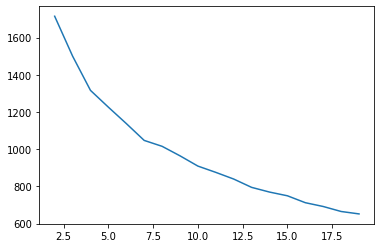

In [103]:
plt.plot(range(2,maxClusters),sse)

In [104]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [105]:
print(silh)

[0.22746195993888094, 0.1559608329476363, 0.16504402856907754, 0.14301005026417984, 0.1200943937226359, 0.13524813883300263, 0.12588697412987992, 0.1332374171855533, 0.12334779855838891, 0.12388229695160419, 0.12709565587931246, 0.13070403947447967, 0.12671170993917286, 0.12152382244817689, 0.1328099399624275, 0.11505367860506129, 0.12205087575588387, 0.12863037774304747]


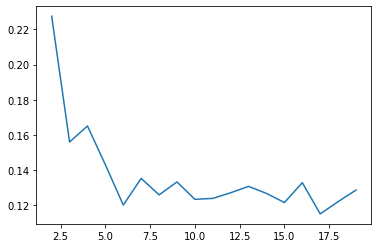

In [106]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 4 The average silhouette_score is : 0.16504402856907746
For n_clusters = 6 The average silhouette_score is : 0.12009439372263592
For n_clusters = 9 The average silhouette_score is : 0.13323741718555324
For n_clusters = 10 The average silhouette_score is : 0.12334779855838895


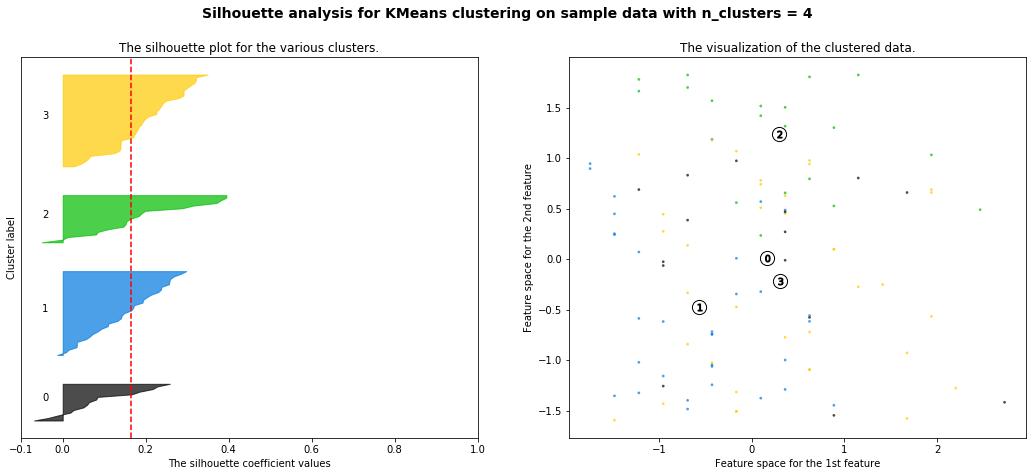

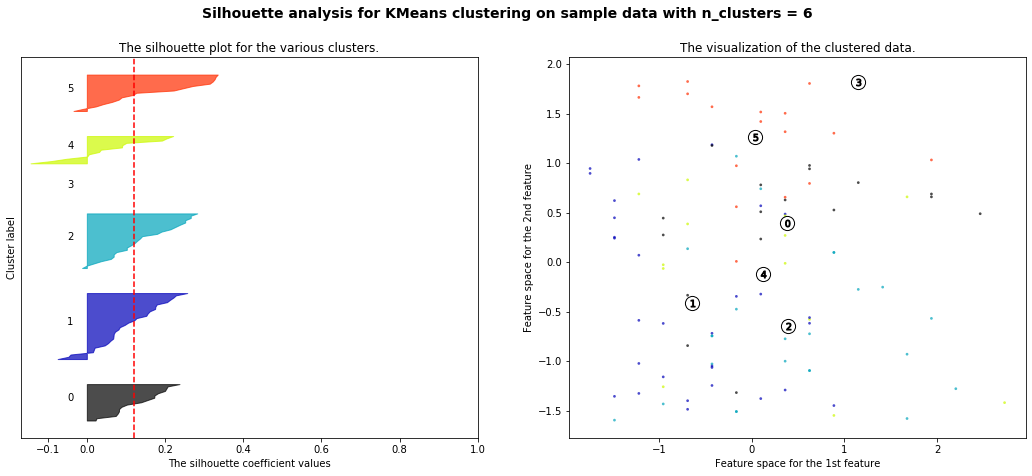

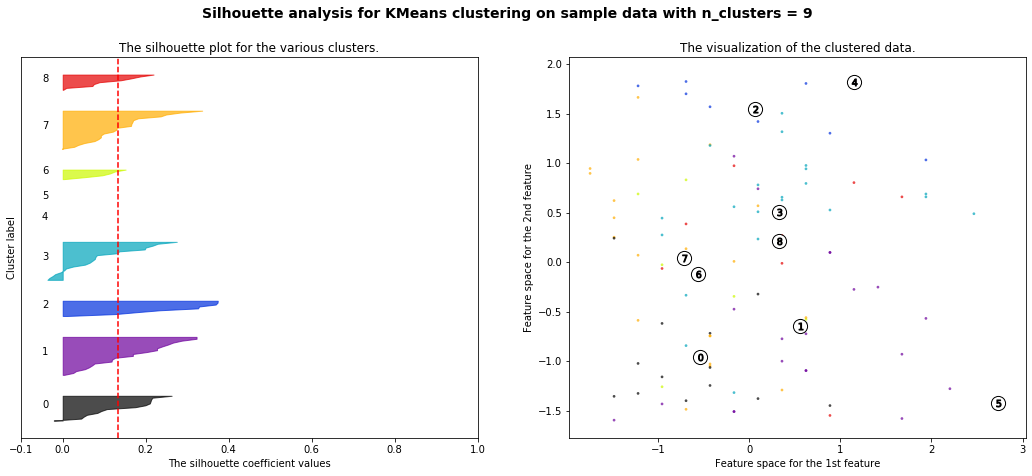

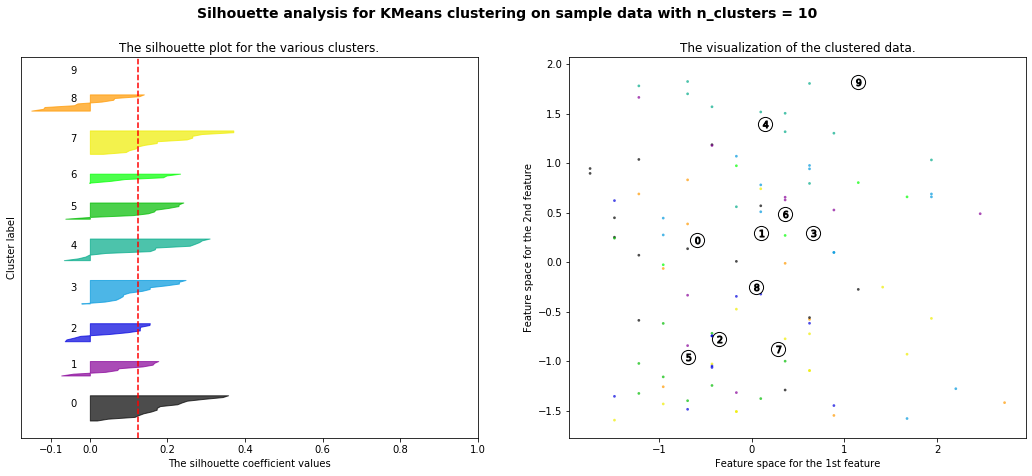

In [107]:
range_n_clusters = [4,6,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## SG Clustering

In [108]:
labels = KMeans(n_clusters=4, random_state=0).fit_predict(dfNorm)

In [109]:
sg_clust['Clusters'] = labels

In [110]:
sg['Clusters'] = labels

In [111]:
sg_clust['Clusters'].value_counts()

3    36
1    33
2    19
0    15
Name: Clusters, dtype: int64

In [112]:
sg_clust.groupby('Clusters').mean()

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
0         26.266667  1133.200000  13.046667  0.554867  0.497467  0.214000   
1         23.454545   834.303030   9.136364  0.485667  0.421000  0.215727   
2         26.736842  1882.578947  18.184211  0.580579  0.410579  0.288421   
3         26.777778   992.027778  10.830556  0.546833  0.599556  0.151083   

              ORB%       DRB%      TRB%       AST%  ...       TOV%       USG%  \
Clusters                                            ...                         
0         3.966667  14.060000  9.086667  13.226667  ...  13.380000  16.106667   
1         2.827273  11.978788  7.378788  12.124242  ...  12.648485  18.930303   
2         2.263158  11.184211  6.715789  20.831579  ...  11.468421  26.400000   
3         1.661111   9.519444  5.577778  10.000000  ...   8.575000  17.355556   

               OWS       DWS        WS     WS/48      OBPM      DBPM  \
Clusters                                                               
0         0.966667  1.593333  2.560000  0.106200 -0.946667  1.426667   
1        -0.296970  0.612121  0.306061  0.014152 -3.187879 -0.642424   
2         3.100000  1.421053  4.526316  0.115947  2.436842 -0.736842   
3         0.691667  0.733333  1.433333  0.065139 -1.302778 -0.727778   

               BPM      VORP  
Clusters                      
0         0.473333  0.726667  
1        -3.818182 -0.336364  
2         1.710526  1.805263  
3        -2.033333  0.072222  

[4 rows x 22 columns]

In [113]:
sg[sg.Clusters == 0]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
12            Ryan Broekhoff\broekry01    2   29  DAL  17   180  13.1  0.568   
14               Bruce Brown\brownbr01    2   23  DET  58  1634  11.9  0.518   
19   Michael Carter-Williams\cartemi01    2   28  ORL  42   773  15.7  0.539   
22           Pat Connaughton\connapa01    2   27  MIL  61  1119  11.2  0.558   
28             Terence Davis\daviste02    2   22  TOR  64  1087  14.5  0.598   
30          Donte DiVincenzo\divindo01    2   23  MIL  59  1362  15.0  0.570   
42               Danny Green\greenda02    2   32  LAL  61  1529  11.1  0.564   
49            Justin Holiday\holidju01    2   30  IND  65  1617  12.7  0.598   
51            Andre Iguodala\iguodan01    2   36  MIA  14   259  11.0  0.559   
52              Josh Jackson\jacksjo02    2   22  MEM  18   357  14.0  0.539   
57                Jeremy Lamb\lambje01    2   27  IND  46  1291  14.1  0.547   
80               Josh Okogie\okogijo01    2   21  MIN  62  1547  11.5  0.553   
94              Marcus Smart\smartma01    2   25  BOS  53  1721  14.0  0.519   
97          Matisse Thybulle\thybuma01    2   22  PHI  57  1110   9.8  0.530   
102             Delon Wright\wrighde01    2   27  DAL  65  1412  16.1  0.563   

      3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
12   0.864  0.136  ...  0.2  0.4  0.116   0.4   0.4  0.9   0.1   1443842.0   
14   0.215  0.266  ...  1.4  2.1  0.062  -2.0   0.8 -1.2   0.3   1416852.0   
19   0.281  0.360  ...  1.1  1.9  0.116  -1.3   1.7  0.4   0.5   2028594.0   
22   0.525  0.138  ...  2.1  3.0  0.130  -1.1   1.6  0.5   0.7   1723050.0   
28   0.568  0.133  ...  1.6  3.0  0.133   0.7   0.6  1.3   0.9    898310.0   
30   0.489  0.173  ...  3.1  4.5  0.158  -0.6   2.7  2.1   1.4   2905800.0   
42   0.704  0.104  ...  2.4  3.4  0.108  -0.8   1.7  0.9   1.1  14634146.0   
49   0.667  0.137  ...  2.2  4.0  0.117   0.0   1.7  1.6   1.5   4767000.0   
51   0.471  0.157  ...  0.4  0.4  0.078  -2.5   1.9 -0.7   0.1  17185185.0   
52   0.465  0.284  ...  0.4  0.5  0.062  -1.1   1.2  0.0   0.2   7059480.0   
57   0.330  0.230  ...  1.8  2.7  0.099  -1.1   0.7 -0.4   0.5  10500000.0   
80   0.387  0.480  ...  1.2  2.2  0.067  -2.4   0.0 -2.4  -0.1   2530680.0   
94   0.582  0.201  ...  2.4  4.1  0.115   0.2   1.3  1.6   1.5  12553471.0   
97   0.607  0.175  ...  1.8  1.9  0.084  -3.0   3.1  0.1   0.6   2582160.0   
102  0.307  0.236  ...  1.8  4.3  0.148   0.4   2.0  2.4   1.6   9473684.0   

     Guaranteed  Clusters  
12    1443842.0         0  
14    1416852.0         0  
19    2028594.0         0  
22    1723050.0         0  
28     898310.0         0  
30    5949960.0         0  
42   30000000.0         0  
49    4767000.0         0  
51   32185185.0         0  
52    7059480.0         0  
57   31500000.0         0  
80    5181720.0         0  
94   40339184.0         0  
97    5293440.0         0  
102  27000000.0         0  

[15 rows x 29 columns]

In [114]:
sg[sg.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0   Nickeil Alexander-Walker\alexani01    2   21  NOP  41   501   7.6  0.441   
2               Dwayne Bacon\bacondw01    2   24  CHO  39   687   6.1  0.419   
3                 RJ Barrett\barrerj01    2   19  NYK  56  1704  10.7  0.479   
7            DeAndre' Bembry\bembrde01    2   25  ATL  43   915   9.6  0.500   
13             Dillon Brooks\brookdi01    2   24  MEM  65  1851  11.1  0.508   
17             Deonte Burton\burtode02    2   26  OKC  34   284   5.9  0.426   
24            Jarrett Culver\culveja01    2   20  MIN  63  1506   9.6  0.467   
32            Carsen Edwards\edwarca01    2   21  BOS  35   316   6.5  0.446   
34               Jacob Evans\evansja02    2   22  TOT  29   418   5.5  0.436   
35                 Dante Exum\exumda01    2   24  TOT  35   485  10.4  0.576   
41            Treveon Graham\grahatr01    2   26  TOT  55   929   6.6  0.456   
43             Marko Guduric\gudurma01    2   24  MEM  42   476   8.8  0.515   
46               Tyler Herro\herroty01    2   20  MIA  47  1280  11.4  0.534   
53              Justin James\jamesju01    2   23  SAC  34   218  11.5  0.487   
54             Tyler Johnson\johnsty01    2   27  PHO  31   515   8.1  0.481   
58            Romeo Langford\langfro01    2   20  BOS  27   298   6.0  0.465   
61                  Damion Lee\leeda03    2   27  GSW  49  1423  12.7  0.548   
62              Caris LeVert\leverca01    2   25  BRK  39  1131  15.1  0.509   
63   Timothé Luwawu-Cabarrot\luwawti01    2   24  BRK  39   671   8.9  0.563   
64   Timothé Luwawu-Cabarrot\luwawti01    2   24  BRK  39   671   8.9  0.563   
65               Terance Mann\mannte01    2   23  LAC  35   271   7.1  0.472   
68           Rodney McGruder\mcgruro01    2   28  LAC  50   749   6.5  0.472   
70              Jordan McRae\mcraejo01    2   28  TOT  37   784  14.2  0.515   
74                 Malik Monk\monkma01    2   21  CHO  55  1169  12.7  0.530   
81            Victor Oladipo\oladivi01    2   27  IND  13   337  12.0  0.500   
82               Theo Pinson\pinsoth01    2   24  BRK  33   365   5.2  0.370   
83              Jordan Poole\poolejo01    2   20  GSW  57  1274   7.2  0.454   
86           Josh Richardson\richajo01    2   26  PHI  48  1474  12.1  0.526   
88           Jerome Robinson\robinje01    2   22  TOT  55   748   6.0  0.439   
92             Iman Shumpert\shumpim01    2   29  BRK  13   241   5.3  0.403   
93           Anfernee Simons\simonan01    2   20  POR  65  1400   9.3  0.506   
98             Lonnie Walker\walkelo01    2   21  SAS  53   767  11.0  0.515   
99                Coby White\whiteco01    2   19  CHI  65  1674  11.9  0.506   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0   0.515  0.123  ...  0.4 -0.4 -0.034  -3.5  -1.4 -4.9  -0.4   2964840.0   
2   0.275  0.217  ...  0.4 -0.8 -0.053  -5.9  -0.9 -6.8  -0.8   1618520.0   
3   0.271  0.349  ...  1.1 -0.5 -0.015  -2.8  -1.5 -4.3  -1.0   7839960.0   
7   0.285  0.211  ...  0.7  0.2  0.011  -3.5   1.0 -2.4  -0.1   2603982.0   
13  0.387  0.192  ...  1.3  1.0  0.025  -2.8  -1.5 -4.3  -1.1   1618520.0   
17  0.438  0.114  ...  0.3 -0.3 -0.046  -5.5  -0.4 -5.8  -0.3   1416852.0   
24  0.388  0.206  ...  1.1 -0.1 -0.004  -3.2  -0.8 -4.0  -0.8   5813640.0   
32  0.602  0.115  ...  0.4  0.1  0.012  -4.6  -0.3 -4.9  -0.2   1228026.0   
34  0.291  0.216  ...  0.2 -0.5 -0.056  -5.7  -1.3 -7.0  -0.5   1925880.0   
35  0.361  0.361  ...  0.2  0.4  0.043  -2.5  -0.4 -2.9  -0.1   9600000.0   
41  0.496  0.231  ...  0.4  0.2  0.009  -4.5  -1.1 -5.5  -0.8   1678854.0   
43  0.526  0.162  ...  0.4  0.1  0.012  -2.6  -0.8 -3.4  -0.2   2625000.0   
46  0.476  0.148  ...  1.1  0.9  0.033  -1.0  -1.3 -2.3  -0.1   3640200.0   
53  0.333  0.269  ...  0.2  0.2  0.037  -1.0   0.2 -0.7   0.1    898310.0   
54  0.485  0.187  ...  0.3  0.1  0.011  -3.0  -0.7 -3.7  -0.2  19245370.0   
58  0.359  0.359  ...  0.3  0.2  0.039  -4.5  -0.1 -4.6  -0.2   3458400.0   
61

In [115]:
sg[sg.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
4                Bradley Beal\bealbr01    2   26  WAS  57  2053  23.1  0.579   
9               Devin Booker\bookede01    2   23  PHO  62  2241  19.8  0.617   
16                Alec Burks\burksal01    2   28  TOT  59  1612  16.0  0.549   
20           Jordan Clarkson\clarkjo01    2   27  TOT  63  1527  17.9  0.583   
25                Seth Curry\curryse01    2   29  DAL  59  1448  16.2  0.650   
29         Spencer Dinwiddie\dinwisp01    2   26  BRK  64  1994  17.9  0.541   
37             Evan Fournier\fournev01    2   27  ORL  61  1931  16.7  0.599   
39   Shai Gilgeous-Alexander\gilgesh01    2   21  OKC  63  2214  17.8  0.566   
44              James Harden\hardeja01    2   30  HOU  61  2241  28.4  0.616   
47               Buddy Hield\hieldbu01    2   27  SAC  64  2045  16.3  0.566   
48              Jrue Holiday\holidjr01    2   29  NOP  55  1922  17.5  0.535   
59               Zach LaVine\lavinza01    2   24  CHI  60  2085  19.5  0.568   
67               CJ McCollum\mccolcj01    2   28  POR  62  2229  17.4  0.543   
73          Donovan Mitchell\mitchdo01    2   23  UTA  63  2165  19.1  0.560   
84             Norman Powell\powelno01    2   26  TOR  44  1269  17.4  0.629   
85               J.J. Redick\redicjj01    2   35  NOP  54  1425  15.1  0.639   
90             Collin Sexton\sextoco01    2   21  CLE  65  2143  16.3  0.560   
100            Derrick White\whitede01    2   25  SAS  61  1468  15.9  0.585   
101             Lou Williams\willilo02    2   33  LAC  60  1757  17.2  0.546   

      3PAr    FTr  ...  DWS    WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
4    0.369  0.351  ...  0.5   5.1  0.119   5.3  -2.4  2.9   2.5  27093019.0   
9    0.313  0.395  ...  1.2   6.0  0.129   3.1  -1.4  1.7   2.1  27250000.0   
16   0.389  0.358  ...  1.1   2.9  0.088   0.6  -0.7 -0.2   0.7   2320044.0   
20   0.469  0.193  ...  0.9   3.5  0.110   2.7  -1.1  1.6   1.4  13437500.0   
25   0.564  0.165  ...  0.9   4.3  0.144   2.0  -0.7  1.4   1.2   7441860.0   
29   0.392  0.437  ...  1.7   5.1  0.123   2.6  -0.8  1.7   1.9  10600000.0   
37   0.467  0.236  ...  1.7   4.4  0.110   1.5  -0.3  1.2   1.6  17000000.0   
39   0.237  0.339  ...  2.6   5.5  0.120   1.4   0.2  1.6   2.0   3952920.0   
44   0.555  0.519  ...  2.7  11.5  0.245   7.9   1.2  9.0   6.3  37800000.0   
47   0.582  0.123  ...  1.5   3.1  0.074   2.6  -1.3  1.4   1.7   4861208.0   
48   0.346  0.183  ...  1.8   4.0  0.099   1.9   0.3  2.3   2.1  26131111.0   
59   0.404  0.279  ...  2.2   4.0  0.092   3.3  -0.8  2.5   2.4  19500000.0   
67   0.378  0.135  ...  0.6   3.7  0.079   2.5  -1.7  0.9   1.6  27556959.0   
73   0.347  0.235  ...  2.2   5.2  0.115   2.4  -0.5  1.9   2.1   3635760.0   
84   0.457  0.252  ...  1.9   4.2  0.157   1.4   0.9  2.3   1.4  10116576.0   
85   0.618  0.292  ...  0.6   3.7  0.125   2.0  -1.6  0.4   0.9  13486300.0   
90   0.235  0.246  ...  0.3   2.5  0.057   0.3  -2.1 -1.8   0.1   4764960.0   
100  0.345  0.377  ...  0.9   3.4  0.110   0.7   0.2  0.9   1.1   1948080.0   
101  0.334  0.365  ...  1.7   3.9  0.107   2.1  -1.4  0.8   1.2   8000000.0   

      Guaranteed  Clusters  
4     90346924.0         2  
9    158050000.0         2  
16     2320044.0         2  
20    13437500.0         2  
25    32000000.0         2  
29    22000000.0         2  
37    17000000.0         2  
39     8094240.0         2  
44   122472000.0         2  
47    90861208.0         2  
48    52262222.0         2  
59    58500000.0         2  
67   156911111.0         2  
73     8831261.0         2  
84    20982528.0         2  
85    26500000.0         2  
90     9756840.0         2  
100    5464364.0         2  
101   16000000.0         2  

[19 rows x 29 columns]

In [116]:
sg[sg.Clusters == 3]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
1              Grayson Allen\allengr01    2   24  MEM  30   498  11.4  0.577   
5              Malik Beasley\beaslma01    2   23  TOT  55  1209  12.7  0.546   
6            Marco Belinelli\belinma01    2   33  SAS  52   779  10.2  0.521   
8          Bogdan Bogdanović\bogdabo01    2   27  SAC  53  1510  14.3  0.560   
10             Avery Bradley\bradlav01    2   29  LAL  49  1186   8.9  0.537   
11             Avery Bradley\bradlav01    2   29  LAL  49  1186   8.9  0.537   
15            Reggie Bullock\bullore01    2   28  NYK  29   684   9.3  0.502   
18  Kentavious Caldwell-Pope\caldwke01    2   26  LAL  63  1603  11.6  0.592   
21             Chris Clemons\clemoch01    2   22  HOU  29   251  12.6  0.546   
23              Allen Crabbe\crabbal01    2   27  TOT  37   653   6.0  0.470   
26              Troy Daniels\danietr01    2   28  TOT  42   457   8.9  0.524   
27              Troy Daniels\danietr01    2   28  TOT  42   457   8.9  0.524   
31            Damyean Dotson\dotsoda01    2   25  NYK  48   836  10.9  0.527   
33           Wayne Ellington\ellinwa01    2   32  NYK  36   558   8.5  0.509   
36               Bryn Forbes\forbebr01    2   26  SAS  63  1579  11.2  0.570   
38         Langston Galloway\gallola01    2   28  DET  66  1702  12.3  0.584   
40               Eric Gordon\gordoer01    2   31  HOU  34   972  10.5  0.511   
45               Gary Harris\harriga01    2   25  DEN  56  1780   9.7  0.519   
50             Kevin Huerter\huertke01    2   21  ATL  56  1760  11.5  0.536   
55              Luke Kennard\kennalu01    2   23  DET  28   922  14.4  0.589   
56            Furkan Korkmaz\korkmfu01    2   22  PHI  64  1398  11.7  0.571   
60                Courtney Lee\leeco01    2   34  DAL  24   345  10.9  0.629   
66           Wesley Matthews\matthwe02    2   33  MIL  62  1529   8.4  0.545   
69              Ben McLemore\mclembe01    2   26  HOU  63  1437  11.7  0.622   
71                C.J. Miles\milescj01    2   32  WAS  10   161  11.0  0.472   
72              Shake Milton\miltosh01    2   23  PHI  32   611  15.2  0.633   
75             E'Twaun Moore\mooreet01    2   30  NOP  51   958  11.1  0.509   
76             Mychal Mulder\muldemy01    2   25  GSW   7   204   7.8  0.533   
77             Mychal Mulder\muldemy01    2   25  GSW   7   204   7.8  0.533   
78             Jaylen Nowell\nowelja01    2   20  MIN  15   151  10.5  0.471   
79              Kendrick Nunn\nunnke01    2   24  MIA  62  1846  13.5  0.545   
87             Austin Rivers\riverau01    2   27  HOU  60  1402  10.3  0.538   
89              Terrence Ross\rosste01    2   28  ORL  63  1723  14.2  0.548   
91             Landry Shamet\shamela01    2   22  LAC  47  1294   9.2  0.599   
95            Garrett Temple\templga01    2   33  BRK  55  1547  10.3  0.507   
96               Matt Thomas\thomama02    2   25  TOR  33   321  13.6  0.650   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
1   0.517  0.199  ...  0.3  0.7  0.070  -1.0  -1.5 -2.6  -0.1   2429400.0   
5   0.517  0.124  ...  0.9  1.3  0.053  -0.7  -1.3 -2.0   0.0   2731714.0   
6   0.572  0.151  ...  0.1  0.6  0.035  -1.0  -1.9 -2.9  -0.2   5846154.0   
8   0.595  0.164  ...  1.1  2.4  0.075   0.7  -0.3  0.4   0.9   8529386.0   
10  0.452  0.063  ...  1.4  1.6  0.066  -2.9   0.5 -2.4  -0.1   4767000.0   
11  0.452  0.063  ...  1.4  1.6  0.066  -2.9   0.5 -2.4  -0.1   2000000.0   
15  0.496  0.094  ...  0.3  0.5  0.036  -2.7  -0.3 -3.0  -0.2   4000000.0   
18  0.474  0.204  ...  1.8  3.8  0.114  -0.8   0.5 -0.3   0.7   8089282.0   
21  0.746  0.056  ...  0.2  0.2  0.046   0.4  -1.7 -1.3   0.1    568422.0   
23  0.672  0.079  ...  0.1 -0.1 -0.007  -3.7  -1.5 -5.3  -0.5  17818456.0   
26  0.711  0.101  ...  0.4  0.7  0.070  -1.2  -1.0 -2.2   0.0   2028594.0   
27  0.711  0.101  ...  0.4  0.7  0.070  -1.2  -1.0 -2.2   0.0    481000.0   
31  0.562  0.114  ...  0.3  0.9  0.053  -0.9  -0.5 -1.4   0.1   161852

## Small Forward

In [117]:
sf.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0        OG Anunoby\anunoog01    3   22  TOR  63  1897  13.2  0.598  0.408   
1      Trevor Ariza\arizatr01    3   34  TOT  53  1493  11.0  0.593  0.639   
2       Will Barton\bartowi01    3   29  DEN  58  1916  15.7  0.549  0.390   
3  Keita Bates-Diop\bateske01    3   24  TOT  39   665  12.6  0.541  0.452   
4     Nicolas Batum\batumni01    3   31  CHO  22   505   9.2  0.463  0.605   

     FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.163  ...  1.8  3.3  5.1  0.130  -0.9   1.8  0.9   1.4   2281800.0   
1  0.228  ...  1.3  1.3  2.6  0.084  -1.5   0.9 -0.5   0.6  12200000.0   
2  0.180  ...  2.4  2.1  4.5  0.113   1.2  -0.1  1.2   1.5  12960000.0   
3  0.332  ...  0.6  0.5  1.1  0.081  -0.8  -0.1 -0.8   0.2   1416852.0   
4  0.123  ...  0.2  0.4  0.6  0.055  -2.7   0.9 -1.9   0.0  25565217.0   

   Guaranteed  
0   6154015.0  
1  14000000.0  
2  26880000.0  
3   1416852.0  
4  25565217.0  

[5 rows x 28 columns]

In [118]:
sf_clust=sf.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [119]:
sf_clust.describe()

Age           MP        PER        TS%       3PAr        FTr  \
count  72.000000    72.000000  72.000000  72.000000  72.000000  72.000000   
mean   26.472222  1072.611111  12.065278   0.549000   0.452028   0.233389   
std     4.593235   615.441775   4.168600   0.050161   0.175210   0.130210   
min    19.000000   220.000000   4.100000   0.440000   0.031000   0.034000   
25%    23.000000   521.500000   9.150000   0.513250   0.364000   0.156250   
50%    26.000000   928.500000  11.200000   0.549500   0.444000   0.207000   
75%    29.000000  1663.500000  13.250000   0.589750   0.539750   0.280500   
max    43.000000  2091.000000  26.700000   0.678000   0.886000   0.679000   

            ORB%       DRB%       TRB%       AST%  ...       TOV%       USG%  \
count  72.000000  72.000000  72.000000  72.000000  ...  72.000000  72.000000   
mean    3.762500  14.322222   9.051389  10.606944  ...  12.137500  16.972222   
std     1.990289   3.384522   2.246436   5.711178  ...   3.172569   4.962797   
min     0.500000   4.600000   3.500000   3.300000  ...   5.500000   7.700000   
25%     2.275000  12.375000   7.500000   7.075000  ...   9.900000  13.600000   
50%     3.350000  14.400000   9.100000   8.850000  ...  12.050000  16.150000   
75%     4.825000  16.700000  10.600000  12.675000  ...  13.600000  18.950000   
max    11.000000  21.400000  13.500000  28.100000  ...  20.500000  33.200000   

             OWS        DWS         WS      WS/48       OBPM       DBPM  \
count  72.000000  72.000000  72.000000  72.000000  72.000000  72.000000   
mean    0.920833   1.059722   1.984722   0.078931  -1.451389   0.204167   
std     1.422351   0.774898   2.031281   0.053907   2.308831   1.078658   
min    -1.200000   0.000000  -0.400000  -0.020000  -5.200000  -1.800000   
25%     0.000000   0.400000   0.450000   0.039500  -3.100000  -0.725000   
50%     0.400000   0.800000   1.350000   0.081000  -1.600000   0.200000   
75%     1.500000   1.600000   3.200000   0.112250  -0.475000   0.900000   
max     6.000000   3.300000   8.500000   0.222000   6.500000   2.900000   

             BPM       VORP  
count  72.000000  72.000000  
mean   -1.238889   0.376389  
std     2.766121   0.964072  
min    -6.700000  -1.400000  
25%    -2.900000  -0.100000  
50%    -1.200000   0.100000  
75%     0.200000   0.725000  
max     9.000000   4.600000  

[8 rows x 22 columns]

In [120]:
scaler = preprocessing.StandardScaler().fit(sf_clust)
dfNorm = scaler.transform(sf_clust)

In [121]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [122]:
print(sse)

[1171.642515276783, 1014.0097689971474, 893.8317027778285, 791.4744744663283, 747.4193825414918, 705.9729577311269, 667.2107759293444, 629.4097100545317, 597.3604148836694, 566.5762889228536, 528.656514957738, 496.34385538026083, 464.0499848189088, 456.0700180701715, 440.51536035366394, 418.9779135375965, 397.95331507377193, 386.59279930331763]


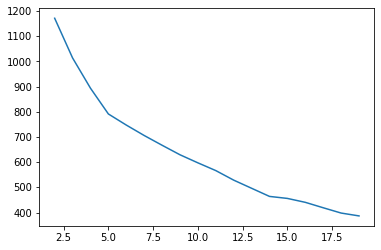

In [123]:
plt.plot(range(2,maxClusters),sse)

In [124]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [125]:
print(silh)

[0.2531509375320014, 0.15274019280437512, 0.16113540121000225, 0.16146140530911937, 0.15010924370373432, 0.16427473302749085, 0.15903651658120319, 0.16915477972209159, 0.15245205639476692, 0.15958062361357742, 0.17187172554766114, 0.17192158664660673, 0.18387479442446716, 0.17956993644387684, 0.17201934332053792, 0.1691055976391121, 0.17323877229505585, 0.18248776532148636]


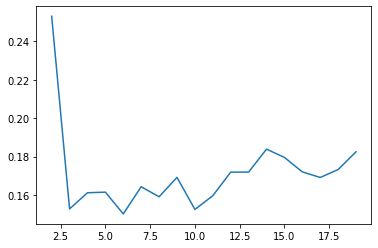

In [126]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 4 The average silhouette_score is : 0.16113540121000222
For n_clusters = 6 The average silhouette_score is : 0.15010924370373432
For n_clusters = 9 The average silhouette_score is : 0.1691547797220916


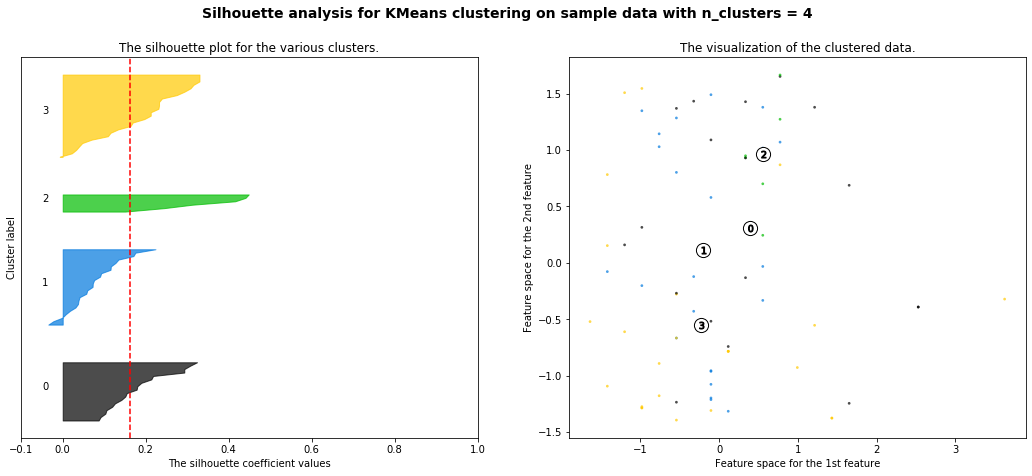

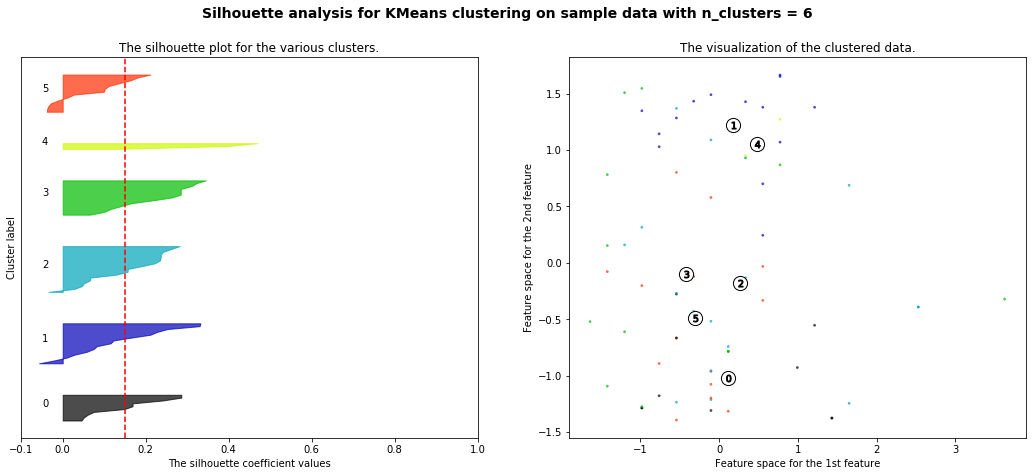

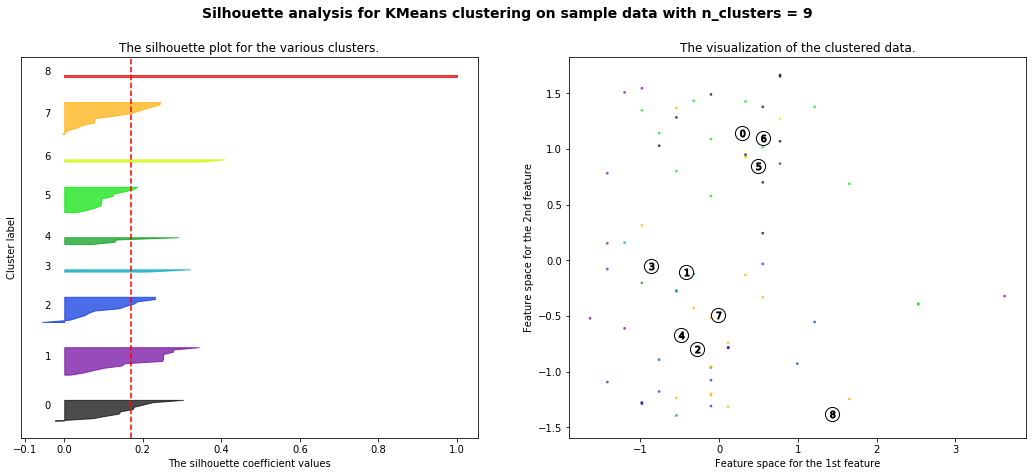

In [127]:
range_n_clusters = [4,6,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## SF Clustering

In [128]:
labels = KMeans(n_clusters=6, random_state=0).fit_predict(dfNorm)

In [129]:
sf_clust['Clusters'] = labels

In [130]:
sf['Clusters'] = labels

In [131]:
sf_clust['Clusters'].value_counts()

2    17
1    15
5    14
3    13
0    10
4     3
Name: Clusters, dtype: int64

In [132]:
sf_clust.groupby('Clusters').mean()

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
0         27.000000   446.500000   9.340000  0.508200  0.466900  0.265000   
1         27.266667  1817.266667  15.546667  0.588400  0.439533  0.228867   
2         27.705882   965.647059  10.535294  0.565647  0.588235  0.164706   
3         24.538462  1010.692308   8.523077  0.492538  0.440385  0.206077   
4         28.666667  1715.666667  23.833333  0.595667  0.274333  0.418000   
5         25.071429   771.571429  12.907143  0.558143  0.338286  0.284857   

              ORB%       DRB%       TRB%       AST%  ...       TOV%  \
Clusters                                             ...              
0         4.640000  18.020000  11.370000  13.160000  ...  17.130000   
1         2.900000  14.213333   8.626667  13.566667  ...  11.366667   
2         2.300000  10.776471   6.541176   9.600000  ...  11.370588   
3         3.946154  14.030769   8.923077   6.369231  ...  11.830769   
4         4.000000  17.300000  10.933333  25.366667  ...  10.900000   
5         5.614286  15.735714  10.614286   7.607143  ...  10.878571   

               USG%       OWS       DWS        WS     WS/48      OBPM  \
Clusters                                                                
0         15.310000 -0.060000  0.480000  0.440000  0.041300 -3.300000   
1         20.766667  2.413333  1.860000  4.266667  0.114000  0.866667   
2         14.352941  0.717647  0.794118  1.517647  0.079588 -1.482353   
3         16.907692 -0.423077  0.600000  0.200000  0.008077 -3.753846   
4         28.200000  4.966667  2.866667  7.833333  0.218333  4.633333   
5         14.928571  0.650000  0.978571  1.614286  0.103357 -1.742857   

              DBPM       BPM      VORP  
Clusters                                
0         0.220000 -3.070000 -0.080000  
1        -0.026667  0.860000  1.253333  
2         0.282353 -1.182353  0.147059  
3        -0.876923 -4.646154 -0.576923  
4         1.566667  6.200000  3.566667  
5         1.057143 -0.678571  0.242857  

[6 rows x 22 columns]

In [133]:
sf[sf.Clusters == 0]

Player  Pos  Age   Tm   G   MP   PER    TS%  \
4           Nicolas Batum\batumni01    3   31  CHO  22  505   9.2  0.463   
6           Dragan Bender\bendedr01    3   22  TOT  16  286  11.0  0.545   
7           Dragan Bender\bendedr01    3   22  TOT  16  286  11.0  0.545   
13         Sterling Brown\brownst02    3   24  MIL  45  665   9.3  0.478   
16        DeMarre Carroll\carrode01    3   33  TOT  21  231   8.5  0.523   
17        DeMarre Carroll\carrode01    3   33  TOT  21  231   8.5  0.523   
19        Wilson Chandler\chandwi01    3   32  BRK  35  734   7.4  0.531   
49            Cody Martin\martico01    3   24  CHO  48  903  10.5  0.505   
67  Juan Toscano-Anderson\toscaju01    3   26  GSW  13  272   9.4  0.529   
71        Justise Winslow\winslju01    3   23  MIA  11  352   8.6  0.440   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
4   0.605  0.123  ...  0.4  0.6  0.055  -2.7   0.9 -1.9   0.0  25565217.0   
6   0.467  0.152  ...  0.3  0.3  0.053  -3.0   0.1 -2.9  -0.1   1678854.0   
7   0.467  0.152  ...  0.3  0.3  0.053  -3.0   0.1 -2.9  -0.1    189702.0   
13  0.523  0.161  ...  1.3  1.0  0.071  -3.1   1.0 -2.0   0.0   1618520.0   
16  0.500  0.667  ...  0.1  0.1  0.026  -3.4  -1.1 -4.5  -0.1   6842307.0   
17  0.500  0.667  ...  0.1  0.1  0.026  -3.4  -1.1 -4.5  -0.1    811447.0   
19  0.661  0.126  ...  0.9  0.8  0.050  -3.9   1.0 -2.9  -0.2   2564753.0   
49  0.372  0.314  ...  0.8  1.0  0.052  -3.1   1.0 -2.1   0.0   1173310.0   
67  0.365  0.079  ...  0.2  0.2  0.030  -3.9   0.4 -3.5  -0.1    350189.0   
71  0.209  0.209  ...  0.4  0.0 -0.003  -3.5  -0.1 -3.5  -0.1  13000000.0   

    Guaranteed  Clusters  
4   25565217.0         0  
6    1678854.0         0  
7     189702.0         0  
13   1618520.0         0  
16  14262321.0         0  
17    811447.0         0  
19   2564753.0         0  
49   4473912.0         0  
67    350189.0         0  
71  26000000.0         0  

[10 rows x 29 columns]

In [134]:
sf[sf.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0         OG Anunoby\anunoog01    3   22  TOR  63  1897  13.2  0.598  0.408   
2        Will Barton\bartowi01    3   29  DEN  58  1916  15.7  0.549  0.390   
8   Bojan Bogdanović\bogdabo02    3   30  UTA  63  2083  15.7  0.603  0.489   
10     Mikal Bridges\bridgmi01    3   23  PHO  65  1772  13.0  0.623  0.391   
12      Jaylen Brown\brownja02    3   23  BOS  50  1702  17.1  0.589  0.364   
21       Jae Crowder\crowdja01    3   29  TOT  58  1695  12.1  0.532  0.692   
22     DeMar DeRozan\derozde01    3   30  SAS  61  2091  21.3  0.597  0.031   
28       Paul George\georgpa01    3   29  LAC  42  1222  20.5  0.582  0.494   
31        Joe Harris\harrijo01    3   28  BRK  63  1946  12.7  0.592  0.523   
34    Gordon Hayward\haywago01    3   29  BOS  45  1501  18.2  0.593  0.311   
41        Joe Ingles\inglejo01    3   32  UTA  64  1916  12.5  0.588  0.628   
55     Marcus Morris\morrima03    3   30  TOT  55  1727  14.8  0.567  0.432   
63   Duncan Robinson\robindu01    3   25  MIA  65  1949  12.8  0.678  0.886   
69       T.J. Warren\warretj01    3   26  IND  61  1984  17.2  0.599  0.212   
70    Andrew Wiggins\wiggian01    3   24  TOT  54  1858  16.4  0.536  0.342   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0   0.163  ...  3.3  5.1  0.130  -0.9   1.8  0.9   1.4   2281800.0   
2   0.180  ...  2.1  4.5  0.113   1.2  -0.1  1.2   1.5  12960000.0   
8   0.296  ...  1.6  4.3  0.099   1.6  -1.5  0.2   1.1  17000000.0   
10  0.258  ...  1.9  4.1  0.111  -0.7   1.5  0.8   1.3   4161000.0   
12  0.280  ...  2.3  4.5  0.126   1.0  -0.1  0.9   1.2   6534829.0   
21  0.236  ...  2.0  3.2  0.090  -0.9   0.3 -0.6   0.6   7815533.0   
22  0.419  ...  1.1  6.2  0.143   2.1  -0.5  1.6   1.9  27739975.0   
28  0.277  ...  2.0  3.9  0.153   3.4   1.1  4.5   2.0  33005556.0   
31  0.118  ...  1.7  3.8  0.094   0.0  -0.5 -0.5   0.8   7670000.0   
34  0.183  ...  1.9  5.0  0.160   2.6   0.3  2.9   1.8  32700690.0   
41  0.170  ...  2.0  4.3  0.108   0.0   0.7  0.7   1.3  11954546.0   
55  0.279  ...  1.2  3.2  0.088   0.9  -0.8  0.1   0.9  15000000.0   
63  0.086  ...  1.5  4.7  0.116   1.2  -0.9  0.3   1.1   1416852.0   
69  0.214  ...  2.2  5.3  0.129   0.4  -0.2  0.2   1.1  10810000.0   
70  0.274  ...  1.1  1.9  0.050   1.1  -1.5 -0.3   0.8  27504630.0   

     Guaranteed  Clusters  
0     6154015.0         1  
2    26880000.0         1  
8    73100000.0         1  
10    8520000.0         1  
12  109534829.0         1  
21    7815533.0         1  
22   27739975.0         1  
28   68455968.0         1  
31    7670000.0         1  
34   32700690.0         1  
41   36818183.0         1  
55   15000000.0         1  
63    1416852.0         1  
69   35250000.0         1  
70  122242800.0         1  

[15 rows x 29 columns]

In [135]:
sf[sf.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
1            Trevor Ariza\arizatr01    3   34  TOT  53  1493  11.0  0.593   
25           Jared Dudley\dudleja01    3   34  LAL  40   311   7.4  0.570   
27      Terrance Ferguson\fergute01    3   21  OKC  50  1170   4.1  0.504   
35            Solomon Hill\hillso01    3   28  TOT  54   992   9.8  0.542   
37             Rodney Hood\hoodro01    3   27  POR  21   619  12.2  0.625   
38           Danuel House\houseda01    3   26  HOU  58  1739  11.4  0.571   
43          Wesley Iwundu\iwundwe01    3   25  ORL  45   810   9.9  0.521   
45            Kyle Korver\korveky01    3   38  MIL  50   833  11.2  0.613   
46            Kyle Korver\korveky01    3   38  MIL  50   833  11.2  0.613   
48           Caleb Martin\martica02    3   24  CHO  18   317  12.0  0.595   
50          Patrick McCaw\mccawpa01    3   24  TOR  37   908   7.3  0.500   
57  Sviatoslav Mykhailiuk\mykhasv01    3   22  DET  56  1265  11.2  0.578   
58            Abdel Nader\naderab01    3   26  OKC  48   756  11.2  0.580   
60             Cedi Osman\osmande01    3   24  CLE  65  1910  10.7  0.552   
61            Otto Porter\porteot01    3   26  CHI  14   331  15.8  0.550   
66             Tony Snell\snellto01    3   28  DET  59  1641   9.7  0.598   
68       Denzel Valentine\valende01    3   26  CHI  36   488  13.0  0.511   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
1   0.639  0.228  ...  1.3  2.6  0.084  -1.5   0.9 -0.5   0.6  12200000.0   
25  0.680  0.040  ...  0.4  0.7  0.103  -2.7   2.0 -0.7   0.1   2564753.0   
27  0.779  0.095  ...  0.8  0.7  0.027  -4.5   0.3 -4.1  -0.6   2475840.0   
35  0.629  0.169  ...  0.9  1.3  0.064  -1.9   0.2 -1.6   0.1  13258781.0   
37  0.413  0.157  ...  0.2  1.1  0.087  -0.4  -0.5 -0.9   0.2   5718000.0   
38  0.645  0.176  ...  1.6  3.5  0.096  -0.6   0.1 -0.5   0.7   3540000.0   
43  0.345  0.392  ...  0.8  1.4  0.080  -3.1   0.2 -2.9  -0.2   1618520.0   
45  0.799  0.131  ...  1.4  2.2  0.125  -0.5   0.7  0.2   0.5   3440000.0   
46  0.799  0.131  ...  1.4  2.2  0.125  -0.5   0.7  0.2   0.5   2564753.0   
48  0.440  0.250  ...  0.2  0.5  0.081  -1.6   0.5 -1.0   0.1    898310.0   
50  0.438  0.111  ...  1.2  1.4  0.073  -3.6   1.8 -1.8   0.0   4000000.0   
57  0.704  0.173  ...  0.6  1.6  0.060  -0.7  -1.2 -1.8   0.0   1416852.0   
58  0.477  0.282  ...  0.7  1.1  0.072  -1.1   0.2 -0.8   0.2   1618520.0   
60  0.527  0.154  ...  0.5  1.6  0.040  -1.6  -0.9 -2.6  -0.3   2907143.0   
61  0.443  0.193  ...  0.4  0.8  0.112   0.9   0.2  1.0   0.3  27250576.0   
66  0.665  0.084  ...  0.5  2.6  0.076  -1.1  -0.6 -1.8   0.1  11392857.0   
68  0.578  0.034  ...  0.6  0.5  0.048  -0.7   0.2 -0.5   0.2   3377569.0   

    Guaranteed  Clusters  
1   14000000.0         2  
25   2564753.0         2  
27   6419853.0         2  
35  13258781.0         2  
37   5718000.0         2  
38  11151000.0         2  
43   1618520.0         2  
45   3440000.0         2  
46   2564753.0         2  
48    898310.0         2  
50   8000000.0         2  
57   1416852.0         2  
58   1618520.0         2  
60  27057143.0         2  
61  27250576.0         2  
66  11392857.0         2  
68   3377569.0         2  

[17 rows x 29 columns]

In [136]:
sf[sf.Clusters == 3]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
5       Kent Bazemore\bazemke01    3   30  TOT  64  1604   9.2  0.500  0.461   
11      Miles Bridges\bridgmi02    3   21  CHO  65  1995  12.1  0.520  0.398   
18       Vince Carter\cartevi01    3   43  ATL  60   876   7.6  0.470  0.664   
23     Hamidou Diallo\diallha01    3   21  OKC  38   699   8.4  0.488  0.160   
24    Sekou Doumbouya\doumbse01    3   19  DET  38   754   6.2  0.474  0.415   
39    De'Andre Hunter\huntede01    3   22  ATL  63  2018   8.6  0.521  0.445   
44          Kevin Knox\knoxke01    3   20  NYK  65  1166   8.4  0.470  0.496   
51   Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493  0.380   
52   Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493  0.380   
53   Alfonzo McKinnie\mckinal01    3   27  CLE  40   593   8.7  0.493  0.380   
56         Džanan Musa\musadz01    3   20  BRK  35   404   8.4  0.467  0.468   
62        Cam Reddish\reddica01    3   20  ATL  58  1551   9.0  0.500  0.451   
65  Admiral Schofield\schofad01    3   22  WAS  27   293   6.8  0.514  0.627   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
5   0.287  ...  1.5  0.7  0.020  -3.4   0.4 -3.0  -0.4  19269662.0   
11  0.174  ...  1.3  1.6  0.038  -1.5  -1.0 -2.5  -0.3   3755400.0   
18  0.095  ...  0.4 -0.2 -0.011  -3.1  -1.2 -4.3  -0.5   2564753.0   
23  0.205  ...  0.8  0.2  0.014  -5.0   0.3 -4.8  -0.5   1416852.0   
24  0.195  ...  0.5 -0.3 -0.020  -5.2  -1.5 -6.7  -0.9   3285120.0   
39  0.211  ...  0.5  0.1  0.001  -2.8  -1.8 -4.7  -1.4   7068360.0   
44  0.252  ...  0.7  0.2  0.006  -3.1  -1.1 -4.2  -0.6   4380120.0   
51  0.181  ...  0.3  0.2  0.014  -4.4  -0.9 -5.3  -0.5   1361046.0   
52  0.181  ...  0.3  0.2  0.014  -4.4  -0.9 -5.3  -0.5    708871.0   
53  0.181  ...  0.3  0.2  0.014  -4.4  -0.9 -5.3  -0.5    183114.0   
56  0.317  ...  0.4  0.0  0.006  -4.1  -0.7 -4.8  -0.3   1911600.0   
62  0.227  ...  0.8 -0.4 -0.011  -3.2  -1.0 -4.2  -0.9   4245720.0   
65  0.173  ...  0.0  0.1  0.020  -4.2  -1.1 -5.3  -0.2    898310.0   

    Guaranteed  Clusters  
5   19269662.0         3  
11   7689720.0         3  
18   2564753.0         3  
23   1416852.0         3  
24   6734520.0         3  
39  14490360.0         3  
44   8968800.0         3  
51   2253031.0         3  
52   2253031.0         3  
53   2253031.0         3  
56   3914400.0         3  
62   8703720.0         3  
65   4198912.0         3  

[13 rows x 29 columns]

In [137]:
sf[sf.Clusters == 4]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
14     Jimmy Butler\butleji01    3   30  MIA  54  1851  23.4  0.583  0.162   
47    Kawhi Leonard\leonaka01    3   28  LAC  51  1643  26.7  0.585  0.287   
54  Khris Middleton\middlkh01    3   28  MIL  55  1653  21.4  0.619  0.374   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
14  0.679  ...  2.5  8.5  0.219   4.0   1.3  5.2   3.4  32742000.0   
47  0.344  ...  3.0  7.6  0.222   6.5   2.5  9.0   4.6  32742000.0   
54  0.231  ...  3.1  7.4  0.214   3.4   0.9  4.4   2.7  30603448.0   

     Guaranteed  Clusters  
14  103137300.0         4  
47   67121100.0         4  
54  137103448.0         4  

[3 rows x 29 columns]

In [138]:
sf[sf.Clusters == 5]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
3          Keita Bates-Diop\bateske01    3   24  TOT  39   665  12.6  0.541   
9               Isaac Bonga\bongais01    3   20  WAS  58  1025  10.7  0.627   
15            Bruno Caboclo\cabocbr01    3   24  TOT  27   220  13.4  0.455   
20             Torrey Craig\craigto01    3   29  DEN  50   869  10.4  0.559   
26              James Ennis\ennisja01    3   29  TOT  61  1053  11.5  0.557   
29            Javonte Green\greenja02    3   26  BOS  44   414  12.3  0.558   
30         Maurice Harkless\harklma01    3   26  TOT  62  1427   9.7  0.572   
32       Shaquille Harrison\harrish01    3   26  CHI  43   484  17.8  0.559   
33                 Josh Hart\hartjo01    3   24  NOP  57  1563  11.7  0.556   
36  Rondae Hollis-Jefferson\holliro01    3   25  TOR  52   998  15.5  0.533   
40       Chandler Hutchison\hutchch01    3   23  CHI  28   527  12.4  0.521   
42           Jonathan Isaac\isaacjo01    3   22  ORL  32   949  16.9  0.542   
59              David Nwaba\nwabada01    3   27  BRK  20   268  14.0  0.627   
64           JaKarr Sampson\sampsja02    3   26  IND  26   340  11.8  0.607   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
3   0.452  0.332  ...  0.5  1.1  0.081  -0.8  -0.1 -0.8   0.2   1416852.0   
9   0.299  0.348  ...  0.4  1.7  0.081  -2.4   0.0 -2.4  -0.1   1416852.0   
15  0.364  0.065  ...  0.4  0.3  0.070  -2.5   1.1 -1.4   0.0   1845301.0   
20  0.524  0.149  ...  0.9  1.7  0.095  -2.4   0.1 -2.3  -0.1   2100000.0   
26  0.473  0.265  ...  1.2  2.1  0.096  -2.1  -0.3 -2.5  -0.1   1882867.0   
29  0.235  0.367  ...  0.7  1.0  0.112  -2.4   1.8 -0.6   0.1    898310.0   
30  0.346  0.233  ...  1.9  2.7  0.090  -2.6   1.9 -0.8   0.5  11511234.0   
32  0.255  0.303  ...  0.8  1.5  0.153   0.4   2.4  2.8   0.6    898310.0   
33  0.676  0.189  ...  1.7  2.7  0.083  -1.2   0.6 -0.6   0.6   1934160.0   
36  0.058  0.437  ...  1.8  3.2  0.153  -1.1   1.5  0.5   0.6   2500000.0   
40  0.217  0.446  ...  0.7  0.7  0.060  -2.7   0.1 -2.6  -0.1   2332320.0   
42  0.283  0.227  ...  1.9  2.3  0.114  -0.8   2.9  2.0   1.0   5806440.0   
59  0.394  0.380  ...  0.4  0.8  0.142  -1.1   2.0  1.0   0.2   1678854.0   
64  0.160  0.247  ...  0.4  0.8  0.117  -2.7   0.8 -1.8   0.0   1737145.0   

    Guaranteed  Clusters  
3    1416852.0         5  
9    1416852.0         5  
15   1845301.0         5  
20   2100000.0         5  
26   1882867.0         5  
29    898310.0         5  
30  11511234.0         5  
32    898310.0         5  
33   5425319.0         5  
36   2500000.0         5  
40   4775760.0         5  
42  13169006.0         5  
59   1678854.0         5  
64   1737145.0         5  

[14 rows x 29 columns]

## Power Forward

In [139]:
pf.head()

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0            Bam Adebayo\adebaba01    4   22  MIA  65  2235  20.6  0.606   
1        Al-Farouq Aminu\aminual01    4   29  ORL  18   380   7.6  0.395   
2          Kyle Anderson\anderky01    4   26  MEM  59  1140  13.0  0.542   
3  Giannis Antetokounmpo\antetgi01    4   25  MIL  57  1763  31.6  0.608   
4        Carmelo Anthony\anthoca01    4   35  POR  50  1623  12.2  0.517   

    3PAr    FTr  ...  OWS  DWS    WS  WS/48  OBPM  DBPM   BPM  VORP  \
0  0.018  0.476  ...  4.6  3.6   8.1  0.175   1.6   2.1   3.6   3.2   
1  0.419  0.337  ... -0.4  0.5   0.1  0.016  -4.5   1.4  -3.1  -0.1   
2  0.221  0.236  ...  0.9  1.4   2.2  0.095  -1.3   1.9   0.6   0.7   
3  0.238  0.500  ...  5.6  4.8  10.4  0.282   7.4   4.1  11.5   6.0   
4  0.286  0.197  ...  0.1  0.9   1.0  0.029  -1.9  -1.8  -3.7  -0.7   

      2019-20  Guaranteed  
0   3454080.0   8569572.0  
1   9258000.0  29162700.0  
2   9073050.0  28515300.0  
3  25842697.0  53370787.0  
4   2159029.0   2159029.0  

[5 rows x 28 columns]

In [140]:
pf_clust=pf.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [141]:
pf_clust.describe()

Age           MP        PER        TS%       3PAr        FTr  \
count  88.000000    88.000000  88.000000  88.000000  88.000000  88.000000   
mean   26.295455  1084.772727  13.681818   0.557750   0.424114   0.252466   
std     4.336849   581.727051   4.946392   0.055058   0.209507   0.116526   
min    19.000000   187.000000   4.200000   0.395000   0.000000   0.083000   
25%    23.000000   605.250000  10.300000   0.534000   0.289750   0.178250   
50%    25.000000  1011.000000  12.800000   0.568000   0.421000   0.229500   
75%    30.000000  1592.500000  16.425000   0.587000   0.541250   0.309000   
max    35.000000  2243.000000  31.600000   0.671000   0.851000   0.710000   

            ORB%       DRB%       TRB%       AST%  ...       TOV%       USG%  \
count  88.000000  88.000000  88.000000  88.000000  ...  88.000000  88.000000   
mean    5.760227  17.989773  11.879545  10.022727  ...  12.262500  17.923864   
std     3.177744   4.665428   3.219487   5.348579  ...   5.035787   5.544615   
min     1.400000   8.700000   6.000000   4.300000  ...   3.500000   8.600000   
25%     3.400000  14.500000   9.800000   6.700000  ...   9.300000  13.700000   
50%     5.300000  17.450000  11.200000   8.200000  ...  12.000000  17.650000   
75%     7.000000  20.325000  13.500000  12.600000  ...  14.075000  20.875000   
max    20.600000  34.500000  22.000000  33.900000  ...  40.400000  37.400000   

             OWS        DWS         WS      WS/48       OBPM       DBPM  \
count  88.000000  88.000000  88.000000  88.000000  88.000000  88.000000   
mean    1.186364   1.154545   2.338636   0.093398  -0.712500  -0.035227   
std     1.367957   0.899669   2.090341   0.055657   2.468413   1.152812   
min    -0.800000   0.200000  -0.200000  -0.037000  -6.600000  -2.600000   
25%     0.200000   0.500000   0.975000   0.055000  -2.125000  -0.900000   
50%     0.800000   0.900000   1.700000   0.089000  -1.100000  -0.050000   
75%     1.800000   1.525000   3.400000   0.120000   0.525000   0.600000   
max     6.200000   4.800000  10.400000   0.282000   7.400000   4.100000   

             BPM       VORP  
count  88.000000  88.000000  
mean   -0.747727   0.564773  
std     2.824441   1.067820  
min    -7.500000  -0.700000  
25%    -2.525000  -0.100000  
50%    -0.750000   0.300000  
75%     0.600000   0.725000  
max    11.500000   6.000000  

[8 rows x 22 columns]

In [142]:
scaler = preprocessing.StandardScaler().fit(pf_clust)
dfNorm = scaler.transform(pf_clust)

In [143]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [144]:
print(sse)

[1416.637139669635, 1250.1374337863958, 1094.3454685488505, 990.5716658029435, 918.3056150523396, 868.097018004689, 816.55041341955, 768.7600222495862, 727.4672668946902, 682.8928847673395, 662.5710131545436, 639.1777576651467, 613.2563255384912, 594.9709851243742, 565.3586760265414, 529.6738200269313, 505.57108570972264, 489.6841198779789]


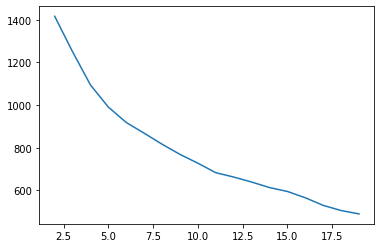

In [145]:
plt.plot(range(2,maxClusters),sse)

In [146]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [147]:
print(silh)

[0.2872963153526103, 0.19812663804378403, 0.15797015470654532, 0.1506249887801552, 0.13289669367192158, 0.13552266371379693, 0.14671250225357504, 0.15174885891831502, 0.1505950695338266, 0.15882136510387895, 0.1478494247039179, 0.13764232576102586, 0.1377523845752078, 0.15148286123958904, 0.14221830807575073, 0.1651978872294204, 0.17082693115858316, 0.18782441944957837]


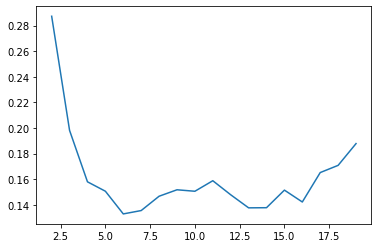

In [148]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 5 The average silhouette_score is : 0.1506249887801552
For n_clusters = 7 The average silhouette_score is : 0.13552266371379695
For n_clusters = 8 The average silhouette_score is : 0.14671250223645368
For n_clusters = 9 The average silhouette_score is : 0.151748858918315
For n_clusters = 11 The average silhouette_score is : 0.15882136510387895


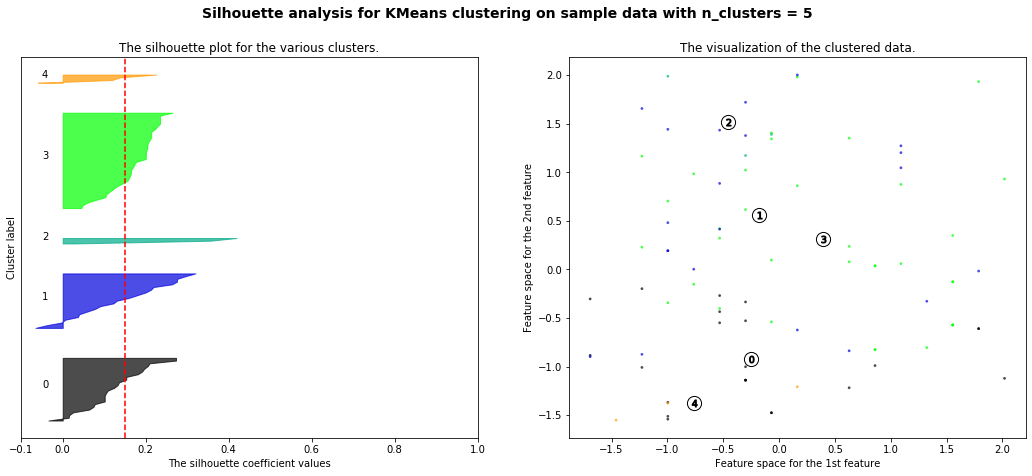

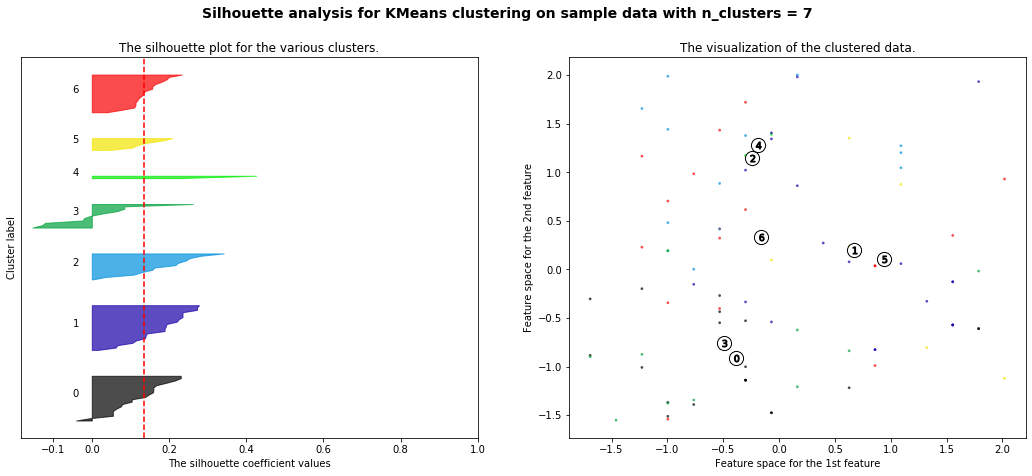

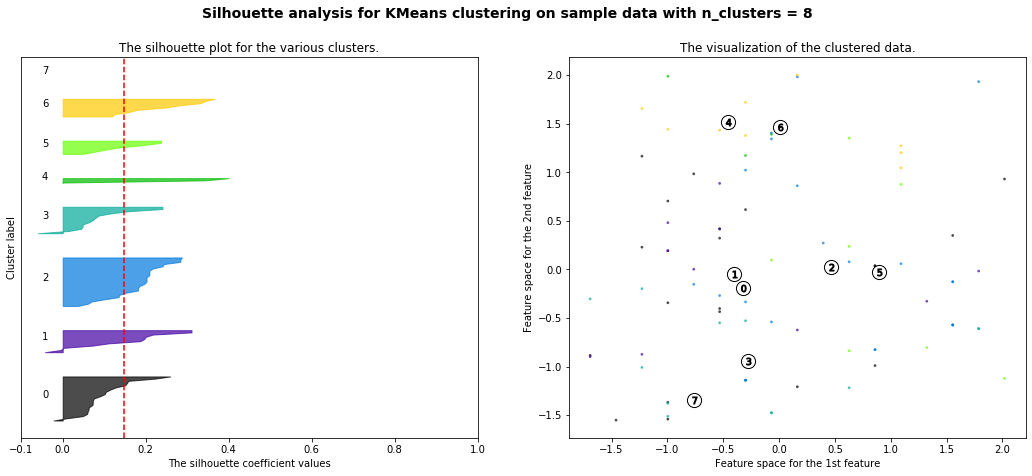

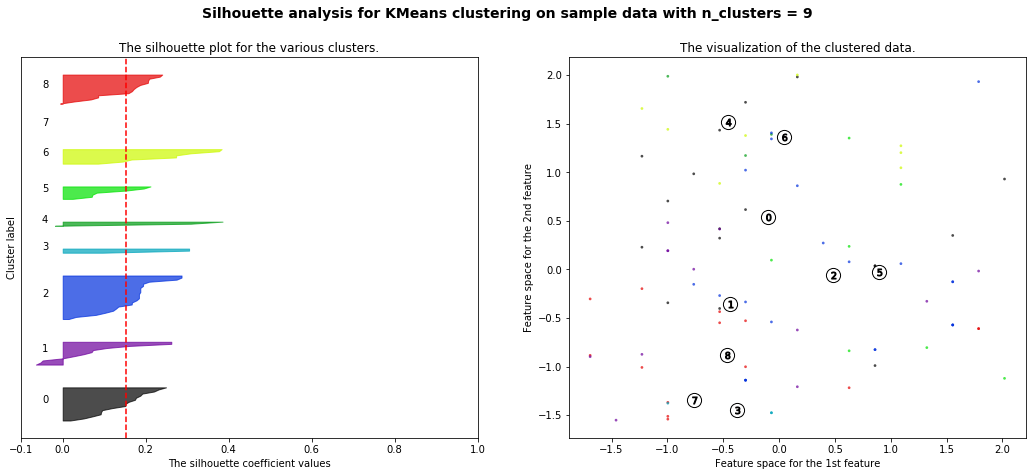

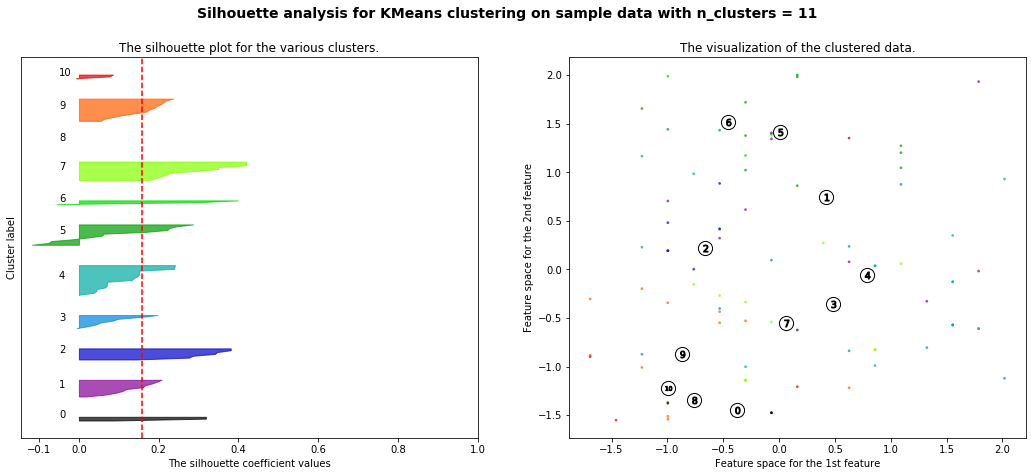

In [149]:
range_n_clusters = [5,7,8,9,11]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## PF Clustering

In [150]:
labels = KMeans(n_clusters=8, random_state=0).fit_predict(dfNorm)

In [151]:
pf_clust['Clusters'] = labels

In [152]:
pf['Clusters'] = labels

In [153]:
pf_clust['Clusters'].value_counts()

2    23
0    21
3    13
1    11
6     9
5     7
4     3
7     1
Name: Clusters, dtype: int64

In [154]:
pf_clust.groupby('Clusters').mean()

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
0         24.904762   976.333333  12.857143  0.549143  0.353762  0.255095   
1         24.545455  1054.636364  19.981818  0.609545  0.221000  0.341273   
2         28.304348  1100.217391  11.573913  0.572174  0.634739  0.179348   
3         25.076923   539.230769   7.415385  0.485385  0.464846  0.232923   
4         24.333333  1962.333333  26.800000  0.609333  0.150333  0.478667   
5         30.142857  1067.857143  13.400000  0.537143  0.411286  0.195143   
6         26.333333  1930.222222  17.800000  0.569333  0.384556  0.271222   
7         23.000000   307.000000  17.200000  0.663000  0.029000  0.710000   

               ORB%       DRB%       TRB%       AST%  ...       TOV%  \
Clusters                                              ...              
0          6.090476  17.352381  11.652381   8.947619  ...  11.952381   
1          8.909091  22.018182  15.445455  10.154545  ...  11.227273   
2          4.065217  14.217391   9.178261   6.813043  ...   8.569565   
3          5.553846  17.784615  11.738462   7.830769  ...  17.838462   
4          7.933333  27.200000  18.033333  24.033333  ...  13.566667   
5          4.871429  18.871429  11.757143  14.671429  ...  15.571429   
6          4.088889  20.588889  12.311111  15.433333  ...  11.155556   
7         20.600000  19.300000  19.900000  10.200000  ...  25.500000   

               USG%       OWS       DWS        WS     WS/48      OBPM  \
Clusters                                                                
0         18.714286  0.514286  0.714286  1.247619  0.064190 -1.338095   
1         21.327273  2.145455  1.363636  3.518182  0.160455  1.227273   
2         14.573913  1.286957  0.991304  2.278261  0.098913 -0.456522   
3         13.453846 -0.161538  0.546154  0.361538  0.024846 -4.261538   
4         29.300000  5.466667  4.166667  9.600000  0.239667  4.933333   
5         16.028571  0.357143  1.342857  1.685714  0.079000 -1.514286   
6         24.666667  2.544444  2.144444  4.677778  0.117556  1.888889   
7         17.500000  0.700000  0.500000  1.100000  0.178000 -3.400000   

              DBPM       BPM      VORP  
Clusters                                
0        -0.952381 -2.276190 -0.042857  
1         0.254545  1.481818  0.954545  
2        -0.300000 -0.769565  0.378261  
3         0.215385 -4.030769 -0.184615  
4         3.000000  7.866667  4.733333  
5         1.414286 -0.100000  0.514286  
6        -0.177778  1.711111  1.777778  
7         0.900000 -2.500000  0.000000  

[8 rows x 22 columns]

In [155]:
pf[pf.Clusters == 0]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
4     Carmelo Anthony\anthoca01    4   35  POR  50  1623  12.2  0.517  0.286   
16    Nicolas Claxton\claxtni01    4   20  BRK  15   187  14.9  0.577  0.146   
20  Cristiano Felício\feliccr01    4   27  CHI  22   386  12.8  0.671  0.037   
24             Rudy Gay\gayru01    4   33  SAS  60  1287  14.4  0.545  0.369   
33      Blake Griffin\griffbl01    4   30  DET  18   512  11.9  0.476  0.444   
34      Rui Hachimura\hachiru01    4   21  WAS  41  1217  13.9  0.543  0.160   
37   Juan Hernangómez\hernaju01    4   24  TOT  48   833  10.4  0.518  0.522   
47         Kyle Kuzma\kuzmaky01    4   24  LAL  54  1327  11.6  0.522  0.401   
48        Jake Layman\laymaja01    4   25  MIN  23   505  10.3  0.544  0.402   
49           T.J. Leaf\leaftj01    4   22  IND  25   193  13.8  0.485  0.203   
50      Nassir Little\littlna01    4   19  POR  48   573   9.7  0.505  0.391   
52         Trey Lyles\lylestr01    4   24  SAS  63  1271  12.7  0.557  0.490   
53    Lauri Markkanen\markkla01    4   22  CHI  50  1492  14.3  0.560  0.536   
54    Jalen McDaniels\mcdanja01    4   22  CHO  16   293  10.7  0.574  0.343   
57    Markieff Morris\morrima02    4   30  TOT  52  1106  12.4  0.568  0.494   
58    Markieff Morris\morrima02    4   30  TOT  52  1106  12.4  0.568  0.494   
62      Jabari Parker\parkeja01    4   24  TOT  33   852  17.0  0.561  0.291   
63      Eric Paschall\pascher01    4   23  GSW  60  1654  14.5  0.571  0.202   
68        Dario Šarić\saricda01    4   25  PHO  58  1441  13.3  0.572  0.455   
73     Omari Spellman\spellom01    4   22  GSW  49   886  14.4  0.551  0.373   
79    P.J. Washington\washipj01    4   21  CHO  58  1759  12.4  0.547  0.390   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
4   0.197  ...  0.9  1.0  0.029  -1.9  -1.8 -3.7  -0.7   2159029.0   
16  0.438  ...  0.2  0.5  0.124  -0.7   0.0 -0.7   0.1    898310.0   
20  0.426  ...  0.3  1.0  0.126  -1.4  -1.6 -3.0  -0.1   8156500.0   
24  0.225  ...  0.9  1.5  0.054  -0.5  -1.0 -1.5   0.2  14000000.0   
33  0.392  ...  0.2 -0.1 -0.012  -1.7  -2.6 -4.2  -0.3  34234964.0   
34  0.243  ...  0.4  1.7  0.066  -1.1  -1.9 -3.0  -0.3   4469160.0   
37  0.287  ...  0.7  1.0  0.055  -2.2  -1.1 -3.3  -0.3   3321030.0   
47  0.221  ...  1.6  1.4  0.052  -2.2  -1.3 -3.5  -0.5   1974600.0   
48  0.179  ...  0.3  0.3  0.029  -2.7  -1.0 -3.7  -0.2   3581986.0   
49  0.174  ...  0.3  0.4  0.088  -1.4  -0.1 -1.5   0.0   2813280.0   
50  0.291  ...  0.3  0.6  0.050  -2.9  -0.6 -3.5  -0.2   2105520.0   
52  0.131  ...  1.0  2.2  0.081  -0.5  -0.7 -1.2   0.2   5500000.0   
53  0.259  ...  1.6  2.6  0.084   0.2  -0.8 -0.5   0.5   5300400.0   
54  0.243  ...  0.2  0.5  0.078  -3.3   0.0 -3.3  -0.1    898310.0   
57  0.195  ...  0.8  1.2  0.053  -1.2  -0.9 -2.1   0.0   2241808.0   
58  0.195  ...  0.8  1.2  0.053  -1.2  -0.9 -2.1   0.0   1750000.0   
62  0.185  ...  0.7  1.2  0.066   0.2  -0.4 -0.1   0.4   6500000.0   
63  0.331  ...  0.5  2.1  0.062  -0.7  -2.0 -2.7  -0.3    898310.0   
68  0.202  ...  1.2  2.7  0.091  -0.5  -0.4 -0.9   0.4   3481986.0   
73  0.312  ...  0.7  1.2  0.065  -0.7  -1.0 -1.7   0.1   1897800.0   
79  0.231  ...  1.4  2.0  0.054  -1.7   0.1 -1.6   0.2   3831840.0   

    Guaranteed  Clusters  
4    2159029.0         0  
16   4198912.0         0  
20  15685520.0         0  
24  28000000.0         0  
33  70830960.0         0  
34   9162000.0         0  
37   3321030.0         0  
47   5536778.0         0  
48  11283255.0         0  
49   7140105.0         0  
50   4316160.0         0  
52   5500000.0         0  
53  12031908.0         0  
54    898310.0         0  
57   2241808.0         0  
58   1750000.0         0  
62   6500000.0         0  
63   4198912.0         0  
68   3481986.0         0  
73   3886080.0         0  
79   7855440.0         0  

[21 rows x 29 columns]

In [156]:
pf[pf.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
9        Chris Boucher\bouchch01    4   27  TOR  55   724  19.8  0.570  0.381   
10     Marquese Chriss\chrisma01    4   22  GSW  59  1196  19.4  0.604  0.101   
11     Marquese Chriss\chrisma01    4   22  GSW  59  1196  19.4  0.604  0.101   
15      Brandon Clarke\clarkbr01    4   23  MEM  50  1086  21.8  0.670  0.127   
17        John Collins\collijo01    4   22  ATL  41  1363  23.5  0.659  0.243   
25         Harry Giles\gilesha01    4   21  SAC  38   579  16.3  0.586  0.000   
39      Ersan İlyasova\ilyaser01    4   32  MIL  56   895  15.2  0.591  0.428   
56        Paul Millsap\millspa01    4   34  DEN  44  1075  17.7  0.598  0.282   
66  Kristaps Porziņģis\porzikr01    4   24  DAL  51  1597  19.3  0.540  0.447   
84     Zion Williamson\willizi01    4   19  NOP  19   565  24.2  0.624  0.045   
86       Christian Wood\woodch01    4   24  DET  62  1325  23.2  0.659  0.276   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
9   0.396  ...  1.5  3.2  0.214   0.4   1.0  1.4   0.6   1588231.0   
10  0.405  ...  1.3  3.4  0.136   0.1   0.5  0.6   0.8    758804.0   
11  0.405  ...  1.3  3.4  0.136   0.1   0.5  0.6   0.8    654468.0   
15  0.228  ...  1.3  4.4  0.192   2.8   0.7  3.5   1.5   2478840.0   
17  0.248  ...  1.1  4.9  0.174   3.7  -0.7  3.1   1.7   2686560.0   
25  0.208  ...  0.7  1.4  0.120  -2.2   1.1 -1.1   0.1   2578800.0   
39  0.259  ...  1.9  3.4  0.180  -0.2   0.8  0.6   0.6   7000000.0   
56  0.326  ...  1.4  3.4  0.151   0.6   0.0  0.6   0.7  30500000.0   
66  0.282  ...  2.6  4.3  0.129   1.2   0.3  1.5   1.4  27285000.0   
84  0.521  ...  0.4  1.8  0.149   3.5  -1.1  2.4   0.6   9757440.0   
86  0.476  ...  1.5  5.1  0.184   3.5  -0.3  3.1   1.7   1645357.0   

     Guaranteed  Clusters  
9     1588231.0         1  
10    2213272.0         1  
11    2213272.0         1  
15    5081760.0         1  
17    6823862.0         1  
25    2578800.0         1  
39    7000000.0         1  
56   30500000.0         1  
66  122236800.0         1  
84   20002920.0         1  
86    1645357.0         1  

[11 rows x 29 columns]

In [157]:
pf[pf.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
5       Harrison Barnes\barneha02    4   27  SAC  64  2231  13.3  0.575   
7         Dāvis Bertāns\bertada01    4   27  WAS  54  1583  15.5  0.628   
12           Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
13           Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
14           Gary Clark\clarkga01    4   25  TOT  35   425  10.3  0.534   
21  Dorian Finney-Smith\finnedo01    4   26  DAL  64  1898  12.2  0.597   
27         Jerami Grant\grantje01    4   25  DEN  64  1676  14.2  0.585   
29       JaMychal Green\greenja01    4   29  LAC  55  1130  10.8  0.554   
30           Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
31           Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
32           Jeff Green\greenje02    4   33  TOT  40   754  12.8  0.575   
41       Justin Jackson\jacksju01    4   24  DAL  58   929  10.0  0.498   
42      Cameron Johnson\johnsca02    4   23  PHO  49   996  12.2  0.576   
55       Doug McDermott\mcderdo01    4   28  IND  62  1242  14.3  0.626   
59        Georges Niang\niangge01    4   26  UTA  58   772  12.4  0.612   
60        Royce O'Neale\onealro01    4   26  UTA  64  1862   9.3  0.584   
61         Semi Ojeleye\ojelese01    4   25  BOS  61   891   7.6  0.557   
64    Patrick Patterson\pattepa01    4   30  LAC  51   607  11.7  0.576   
65    Patrick Patterson\pattepa01    4   30  LAC  51   607  11.7  0.576   
69           Mike Scott\scottmi01    4   31  PHI  63  1119  10.2  0.539   
78          P.J. Tucker\tuckepj01    4   34  HOU  64  2203   8.7  0.580   
82      Marvin Williams\willima02    4   33  TOT  52  1011  11.4  0.585   
83      Marvin Williams\willima02    4   33  TOT  52  1011  11.4  0.585   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
5   0.342  0.343  ...  1.1  4.2  0.091   0.0  -1.2 -1.2   0.5  24147727.0   
7   0.774  0.200  ...  0.5  3.5  0.106   2.7  -1.8  0.9   1.1   7000000.0   
12  0.851  0.089  ...  0.4  0.9  0.098  -1.1  -1.1 -2.2   0.0    708426.0   
13  0.851  0.089  ...  0.4  0.9  0.098  -1.1  -1.1 -2.2   0.0    555409.0   
14  0.851  0.089  ...  0.4  0.9  0.098  -1.1  -1.1 -2.2   0.0    163356.0   
21  0.580  0.212  ...  1.6  4.5  0.114   0.0  -0.1 -0.2   0.9   4000000.0   
27  0.394  0.308  ...  1.7  4.0  0.116  -0.1  -0.4 -0.4   0.7   9346153.0   
29  0.675  0.146  ...  1.8  2.6  0.111  -1.4   0.6 -0.8   0.3   4767000.0   
30  0.529  0.280  ...  0.8  1.4  0.089  -0.4   0.0 -0.5   0.3   2564753.0   
31  0.529  0.280  ...  0.8  1.4  0.089  -0.4   0.0 -0.5   0.3    695526.0   
32  0.529  0.280  ...  0.8  1.4  0.089  -0.4   0.0 -0.5   0.3    144901.0   
41  0.486  0.141  ...  0.6  1.3  0.066  -1.7  -1.2 -2.9  -0.2   3280920.0   
42  0.705  0.142  ...  0.7  1.8  0.086   0.5  -0.7 -0.2   0.5   4033440.0   
55  0.540  0.106  ...  0.9  3.0  0.115   1.5  -1.5  0.0   0.6   7333334.0   
59  0.698  0.083  ...  0.7  1.7  0.105   0.9  -0.4  0.5   0.5   1678854.0   
60  0.657  0.153  ...  2.2  4.0  0.104  -1.3   2.1  0.8   1.3   1618520.0   
61  0.616  0.176  ...  0.9  1.7  0.091  -2.1   0.5 -1.6   0.1   1618520.0   
64  0.755  0.181  ...  0.6  1.5  0.118   0.9  -0.5  0.4   0.4   2331593.0   
65  0.755  0.181  ...  0.6  1.5  0.118   0.9  -0.5  0.4   0.4    737067.0   
69  0.639  0.094  ...  1.1  2.1  0.089  -1.2  -1.1 -2.3  -0.1   4767000.0   
78  0.687  0.118  ...  2.2  3.9  0.086  -2.2   0.6 -1.6   0.2   8349039.0   
82  0.578  0.217  ...  1.0  2.1  0.099  -1.7   1.0 -0.7   0.3  15006250.0   
83  0.578  0.217  ...  1.0  2.1  0.099  -1.7   1.0 -0.7   0.3    956349.0   

    Guaranteed  Clusters  
5   85000000.0         2  
7    7000000.0         2  
12    708426.0         2  
13    718765.0         2  
14    718765.0         2  
21  12000000.0         2  
27   9346153.0         2  
29   4767000.0         2  
30   2564753.0         2  
31    840427.0         2  
32    840427.0         2  
41   8310570.0         2  
42   8268600.0         2  

In [158]:
pf[pf.Clusters == 3]

Player  Pos  Age   Tm   G   MP  PER    TS%  \
1          Al-Farouq Aminu\aminual01    4   29  ORL  18  380  7.6  0.395   
6            Darius Bazley\bazleda01    4   19  OKC  53  909  8.1  0.475   
22          Wenyen Gabriel\gabriwe01    4   22  TOT  28  210  9.6  0.547   
38           Mario Hezonja\hezonma01    4   24  POR  47  767  9.5  0.532   
44  Michael Kidd-Gilchrist\kiddgmi01    4   26  TOT  21  231  4.2  0.401   
45  Michael Kidd-Gilchrist\kiddgmi01    4   26  TOT  21  231  4.2  0.401   
46          Rodions Kurucs\kurucro01    4   21  BRK  39  501  8.4  0.554   
74          Caleb Swanigan\swanica01    4   22  TOT  27  288  7.6  0.597   
76        Anthony Tolliver\tollian01    4   34  TOT  47  732  6.6  0.497   
77        Anthony Tolliver\tollian01    4   34  TOT  47  732  6.6  0.497   
80          Grant Williams\willigr01    4   21  BOS  62  970  8.0  0.508   
81        Kenrich Williams\willike04    4   25  NOP  35  779  7.6  0.430   
85             D.J. Wilson\wilsodj01    4   23  MIL  31  280  8.4  0.476   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
1   0.419  0.337  ...  0.5  0.1  0.016  -4.5   1.4 -3.1  -0.1   9258000.0   
6   0.435  0.204  ...  1.2  0.4  0.019  -3.1   0.6 -2.5  -0.1   2284800.0   
22  0.435  0.435  ...  0.2  0.2  0.043  -3.9   0.0 -3.9  -0.1    898310.0   
38  0.339  0.270  ...  0.6  0.7  0.046  -3.1   0.2 -2.9  -0.2   1737145.0   
44  0.333  0.183  ...  0.2 -0.2 -0.037  -6.6  -0.9 -7.5  -0.3  13000000.0   
45  0.333  0.183  ...  0.2 -0.2 -0.037  -6.6  -0.9 -7.5  -0.3    810763.0   
46  0.485  0.209  ...  0.6  0.5  0.048  -3.9   0.9 -2.9  -0.1   1699236.0   
74  0.043  0.362  ...  0.2  0.0  0.007  -6.3   0.2 -6.0  -0.3   2033160.0   
76  0.781  0.161  ...  0.4  0.3  0.018  -3.1  -0.7 -3.8  -0.3   2419852.0   
77  0.781  0.161  ...  0.4  0.3  0.018  -3.1  -0.7 -3.8  -0.3    144901.0   
80  0.443  0.266  ...  1.3  1.5  0.075  -4.0   1.4 -2.6  -0.1   2379840.0   
81  0.671  0.168  ...  0.8  0.8  0.052  -3.3   1.0 -2.3  -0.1   1416852.0   
85  0.545  0.089  ...  0.5  0.3  0.055  -3.9   0.3 -3.6  -0.1   2961120.0   

    Guaranteed  Clusters  
1   29162700.0         3  
6    4683960.0         3  
22    898310.0         3  
38   3620012.0         3  
44  13000000.0         3  
45    810763.0         3  
46   3479388.0         3  
74   2033160.0         3  
76   2419852.0         3  
77    144901.0         3  
80   4878600.0         3  
81   1416852.0         3  
85   7509400.0         3  

[13 rows x 29 columns]

In [159]:
pf[pf.Clusters == 4]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
0             Bam Adebayo\adebaba01    4   22  MIA  65  2235  20.6  0.606   
3   Giannis Antetokounmpo\antetgi01    4   25  MIL  57  1763  31.6  0.608   
19          Anthony Davis\davisan02    4   26  LAL  55  1889  28.2  0.614   

     3PAr    FTr  ...  DWS    WS  WS/48  OBPM  DBPM   BPM  VORP     2019-20  \
0   0.018  0.476  ...  3.6   8.1  0.175   1.6   2.1   3.6   3.2   3454080.0   
3   0.238  0.500  ...  4.8  10.4  0.282   7.4   4.1  11.5   6.0  25842697.0   
19  0.195  0.460  ...  4.1  10.3  0.262   5.8   2.8   8.5   5.0  27093019.0   

    Guaranteed  Clusters  
0    8569572.0         4  
3   53370787.0         4  
19  27093019.0         4  

[3 rows x 29 columns]

In [160]:
pf[pf.Clusters == 5]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
2      Kyle Anderson\anderky01    4   26  MEM  59  1140  13.0  0.542  0.221   
18  Robert Covington\covinro01    4   29  TOT  62  1867  13.6  0.571  0.654   
28    Draymond Green\greendr01    4   29  GSW  43  1222  12.6  0.489  0.408   
36       John Henson\hensojo01    4   29  TOT  40   600  17.0  0.578  0.211   
43     James Johnson\johnsja01    4   32  TOT  32   619  14.8  0.572  0.423   
70   Thabo Sefolosha\sefolth01    4   35  HOU  41   436   9.5  0.487  0.593   
87    Thaddeus Young\youngth01    4   31  CHI  64  1591  13.3  0.521  0.369   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
2   0.236  ...  1.4  2.2  0.095  -1.3   1.9  0.6   0.7   9073050.0   
18  0.167  ...  2.4  3.3  0.085  -1.0   1.1  0.1   1.0  11301219.0   
28  0.263  ...  1.3  1.1  0.044  -2.0   1.9 -0.2   0.6  18539130.0   
36  0.269  ...  0.8  1.4  0.109  -1.1   2.1  1.0   0.5   9732396.0   
43  0.223  ...  0.8  1.2  0.089  -1.1   1.1  0.0   0.3  15349400.0   
70  0.088  ...  0.6  0.7  0.073  -2.7   1.6 -1.1   0.1   2564753.0   
87  0.120  ...  2.1  1.9  0.058  -1.4   0.2 -1.1   0.4  12900000.0   

    Guaranteed  Clusters  
2   28515300.0         5  
18  36415035.0         5  
28  90619267.0         5  
36   9732396.0         5  
43  15349400.0         5  
70   2564753.0         5  
87  32445000.0         5  

[7 rows x 29 columns]

In [161]:
pf[pf.Clusters == 6]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
8    Nemanja Bjelica\bjeline01    4   31  SAC  64  1821  15.6  0.597  0.488   
23  Danilo Gallinari\gallida01    4   31  OKC  55  1690  19.4  0.611  0.538   
26      Aaron Gordon\gordoaa01    4   24  ORL  58  1914  14.8  0.511  0.311   
35     Tobias Harris\harrito02    4   27  PHI  65  2243  16.8  0.557  0.309   
40    Brandon Ingram\ingrabr01    4   22  NOP  56  1919  19.2  0.590  0.352   
51         Kevin Love\loveke01    4   31  CLE  56  1780  17.9  0.599  0.536   
67     Julius Randle\randlju01    4   25  NYK  64  2080  17.5  0.538  0.230   
71     Pascal Siakam\siakapa01    4   25  TOR  53  1882  18.7  0.559  0.320   
75      Jayson Tatum\tatumja01    4   21  BOS  59  2043  20.3  0.562  0.377   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
8   0.121  ...  1.7  4.7  0.125   1.2   0.4  1.6   1.7   6825000.0   
23  0.352  ...  1.6  5.7  0.163   4.1  -0.9  3.2   2.2  22615559.0   
26  0.280  ...  2.2  3.3  0.084  -0.3   0.1 -0.3   0.8  19863636.0   
35  0.183  ...  2.6  5.6  0.120   1.0  -0.4  0.6   1.5  31034483.0   
40  0.328  ...  1.7  4.9  0.122   2.7  -0.3  2.4   2.1   7265485.0   
51  0.301  ...  1.2  3.8  0.102   2.6  -0.6  2.1   1.8  28900000.0   
67  0.350  ...  1.7  2.7  0.062   0.7  -1.0 -0.3   0.9  18000000.0   
71  0.275  ...  3.2  5.2  0.133   1.7   0.5  2.2   2.0   2351839.0   
75  0.251  ...  3.4  6.2  0.147   3.3   0.6  3.9   3.0   7830000.0   

     Guaranteed  Clusters  
8     6825000.0         6  
23   22615559.0         6  
26   54409091.0         6  
35  180000000.0         6  
40    7265485.0         6  
51  120400000.0         6  
67   40900000.0         6  
71  132271839.0         6  
75   17727120.0         6  

[9 rows x 29 columns]

In [162]:
pf[pf.Clusters == 7]

Player  Pos  Age   Tm   G   MP   PER    TS%   3PAr   FTr  \
72  Chris Silva\silvach01    4   23  MIA  41  307  17.2  0.663  0.029  0.71   

    ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP   2019-20  Guaranteed  \
72  ...  0.5  1.1  0.178  -3.4   0.9 -2.5   0.0  466918.0   1984899.0   

    Clusters  
72         7  

[1 rows x 29 columns]

## Centers

In [163]:
center.head()

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0       Steven Adams\adamsst01    5   26  OKC  58  1564  20.8  0.605  0.007   
1  LaMarcus Aldridge\aldrila01    5   34  SAS  53  1754  19.8  0.571  0.198   
2      Jarrett Allen\allenja01    5   21  BRK  64  1647  20.3  0.658  0.012   
3      Deandre Ayton\aytonde01    5   21  PHO  30   996  20.4  0.571  0.006   
4        Aron Baynes\baynear01    5   33  PHO  42   934  15.1  0.581  0.441   

     FTr  ...  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0  0.413  ...  3.7  2.5  6.2  0.190   2.1   1.1  3.2   2.0  25842697.0   
1  0.241  ...  3.1  1.4  4.4  0.122   1.8  -0.5  1.3   1.5  26000000.0   
2  0.574  ...  4.3  2.8  7.1  0.207   1.0   1.1  2.1   1.7   2376840.0   
3  0.168  ...  1.1  1.3  2.4  0.117   0.8  -0.4  0.5   0.6   9562920.0   
4  0.197  ...  1.3  0.7  2.0  0.103  -0.2  -0.9 -1.1   0.2   5453280.0   

   Guaranteed  
0  53370787.0  
1  50000000.0  
2   6286742.0  
3  19581120.0  
4   5453280.0  

[5 rows x 28 columns]

In [164]:
c_clust=center.drop(['Player','Pos','Tm','G','2019-20','Guaranteed'], axis=1)

In [165]:
c_clust.describe()

Age           MP      PER        TS%       3PAr        FTr  \
count  80.000000    80.000000  80.0000  80.000000  80.000000  80.000000   
mean   26.462500  1005.800000  17.2600   0.601750   0.175187   0.339900   
std     4.109094   520.221774   4.2474   0.065059   0.198261   0.155569   
min    19.000000   178.000000   7.3000   0.403000   0.000000   0.112000   
25%    23.000000   565.000000  14.4000   0.558750   0.011500   0.222750   
50%    26.000000   988.500000  17.6000   0.596500   0.087500   0.305000   
75%    29.000000  1350.000000  20.3250   0.645250   0.299750   0.424250   
max    37.000000  2159.000000  26.5000   0.726000   0.755000   0.736000   

            ORB%       DRB%       TRB%       AST%  ...       TOV%      USG%  \
count  80.000000  80.000000  80.000000  80.000000  ...  80.000000  80.00000   
mean    9.972500  22.675000  16.312500   9.975000  ...  13.807500  17.46250   
std     3.540542   5.655702   4.050484   5.131647  ...   3.820225   4.67859   
min     2.700000  10.200000   8.300000   3.500000  ...   6.600000   6.00000   
25%     7.750000  19.025000  13.175000   6.475000  ...  11.750000  14.65000   
50%    10.150000  22.950000  16.250000   9.200000  ...  13.100000  16.40000   
75%    12.150000  26.575000  19.000000  11.225000  ...  15.700000  19.42500   
max    19.300000  37.500000  26.000000  34.300000  ...  25.200000  32.60000   

             OWS        DWS         WS      WS/48       OBPM       DBPM  \
count  80.000000  80.000000  80.000000  80.000000  80.000000  80.000000   
mean    1.788750   1.393750   3.178750   0.140875  -0.273750   0.628750   
std     1.492173   0.963294   2.266916   0.053377   2.272775   1.211881   
min    -1.000000   0.200000   0.000000   0.005000  -7.100000  -1.700000   
25%     0.700000   0.575000   1.375000   0.103750  -1.200000  -0.225000   
50%     1.450000   1.100000   2.750000   0.130000  -0.200000   0.550000   
75%     2.625000   2.150000   4.650000   0.190250   0.925000   1.325000   
max     6.000000   4.000000  10.000000   0.242000   7.000000   4.400000   

             BPM      VORP  
count  80.000000  80.00000  
mean    0.355000   0.80000  
std     2.624032   0.98199  
min    -5.800000  -0.70000  
25%    -1.325000   0.10000  
50%     0.450000   0.50000  
75%     2.100000   1.22500  
max     7.800000   5.10000  

[8 rows x 22 columns]

In [166]:
scaler = preprocessing.StandardScaler().fit(c_clust)
dfNorm = scaler.transform(c_clust)

In [167]:
maxClusters = 20
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [168]:
print(sse)

[1301.6037785611838, 1140.5260959458951, 1020.5833446785223, 927.3597983544595, 877.1132246251104, 819.2338762649856, 782.5420383175244, 741.3940222884029, 697.2168826352175, 673.8749963445152, 645.3434914496936, 619.96565969936, 602.4735786953191, 575.949323349176, 557.0693479517232, 532.862120760044, 515.0466325174923, 493.17184884358164]


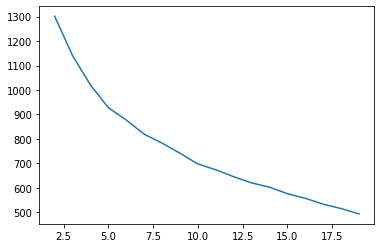

In [169]:
plt.plot(range(2,maxClusters),sse)

In [170]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [171]:
print(silh)

[0.23628946758631625, 0.1747664492106819, 0.1610827767696324, 0.1392544757199436, 0.12571099901906063, 0.12071902923898326, 0.13257780163657895, 0.13135036761497224, 0.13170013061280622, 0.14665109299868634, 0.1345360247969539, 0.1297805174811483, 0.11479274373751362, 0.09494524778674515, 0.09422485719817905, 0.11931238743645327, 0.12326443579161399, 0.12231868947326516]


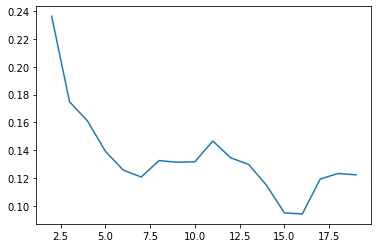

In [172]:
plt.plot(range(2,maxClusters),silh)

For n_clusters = 5 The average silhouette_score is : 0.13925447571994357
For n_clusters = 6 The average silhouette_score is : 0.12571099901906063
For n_clusters = 7 The average silhouette_score is : 0.12071902923898326
For n_clusters = 10 The average silhouette_score is : 0.13170013061280628
For n_clusters = 14 The average silhouette_score is : 0.11479274373751361
For n_clusters = 15 The average silhouette_score is : 0.09494524778674515


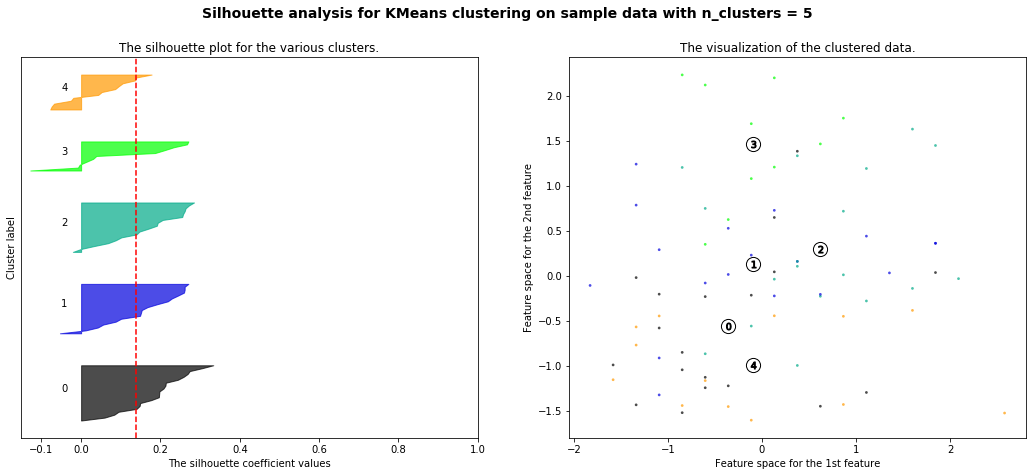

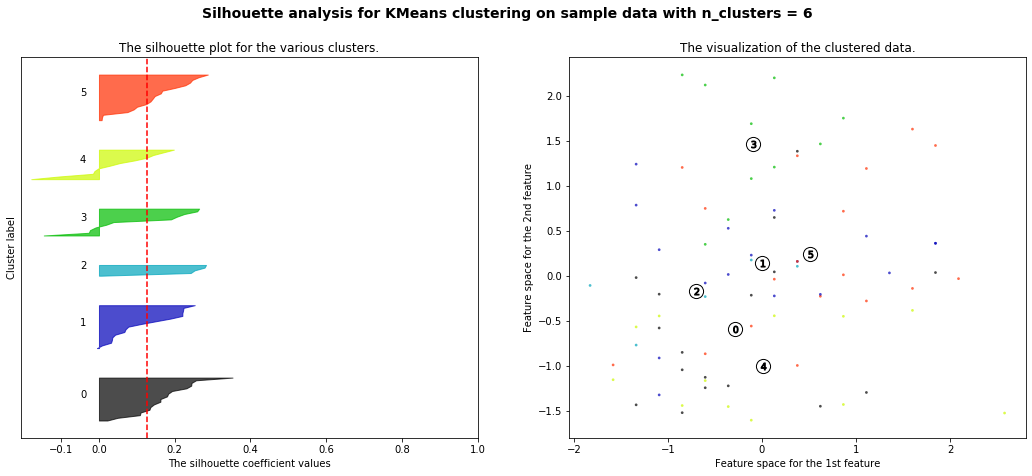

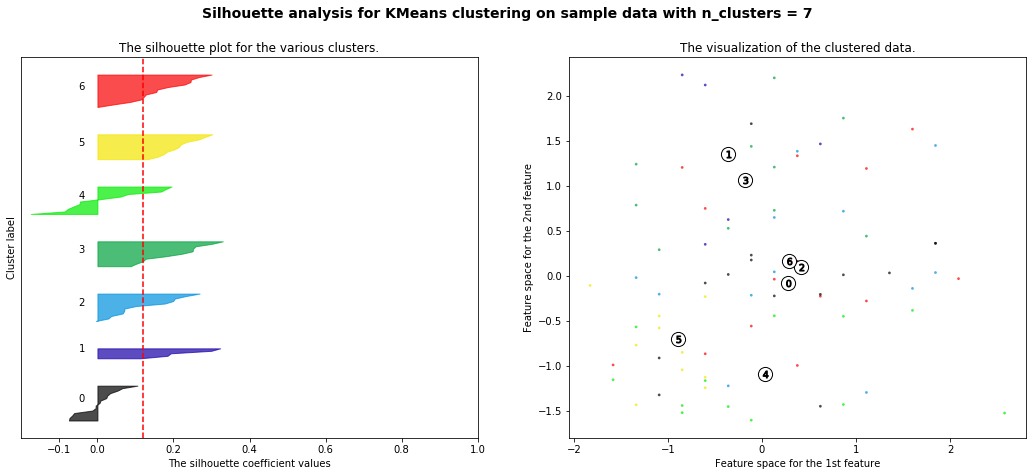

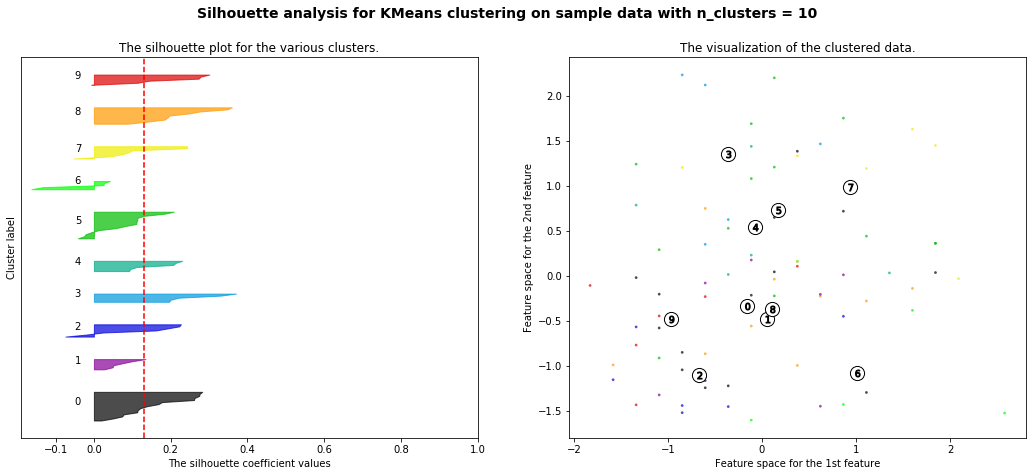

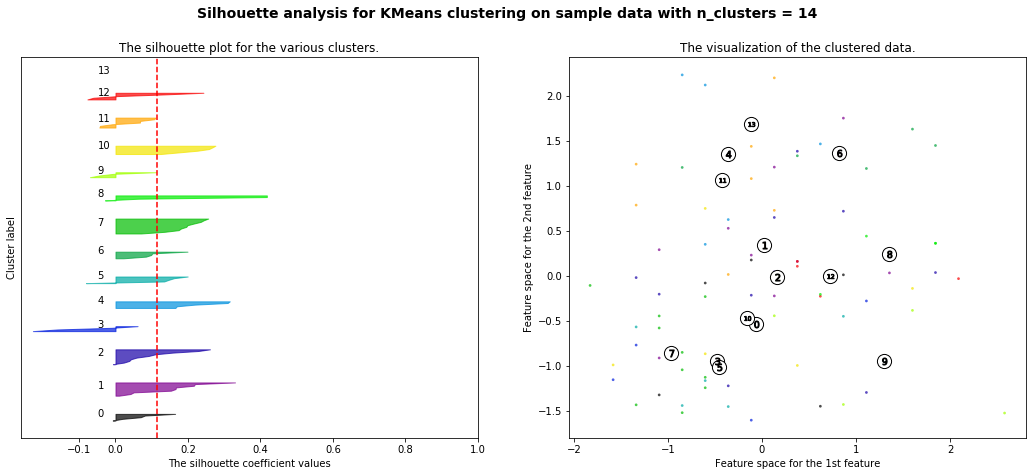

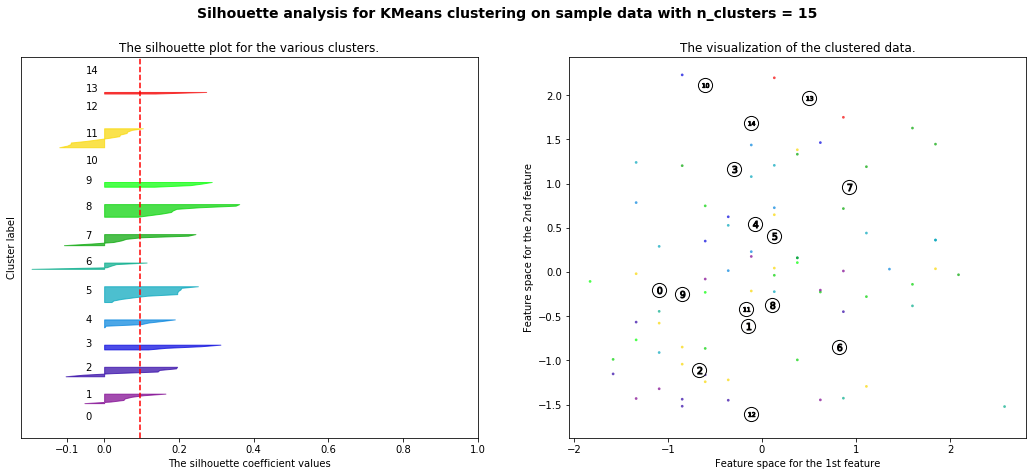

In [173]:
range_n_clusters = [5,6,7,10,14,15]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm, kmeans.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## C Clustering

In [174]:
labels = KMeans(n_clusters=7, random_state=0).fit_predict(dfNorm)

In [175]:
c_clust['Clusters'] = labels

In [176]:
center['Clusters'] = labels

In [177]:
c_clust['Clusters'].value_counts()

0    15
6    14
4    12
2    12
5    11
3    11
1     5
Name: Clusters, dtype: int64

In [178]:
c_clust.groupby('Clusters').mean()

Age           MP        PER       TS%      3PAr       FTr  \
Clusters                                                                    
0         27.600000   966.466667  19.680000  0.632200  0.061333  0.367200   
1         25.000000  1707.800000  23.960000  0.593000  0.252200  0.338800   
2         28.166667  1057.083333  18.566667  0.586833  0.147000  0.291833   
3         25.727273  1555.090909  21.509091  0.649727  0.035364  0.414273   
4         26.583333   440.916667  11.525000  0.534500  0.116083  0.379250   
5         22.818182   643.545455  16.327273  0.654545  0.111364  0.429364   
6         27.642857  1090.500000  13.464286  0.563500  0.504500  0.189786   

               ORB%       DRB%       TRB%       AST%  ...       TOV%  \
Clusters                                              ...              
0         12.800000  26.046667  19.440000   9.846667  ...  15.286667   
1          8.740000  29.000000  18.760000  23.220000  ...  12.880000   
2         11.333333  22.975000  17.041667   9.858333  ...  12.266667   
3         12.627273  26.363636  19.636364   8.663636  ...  12.563636   
4         10.050000  21.275000  15.591667   6.491667  ...  17.508333   
5          9.236364  18.863636  13.963636   8.600000  ...  15.109091   
6          4.642857  17.842857  11.314286  10.578571  ...  10.657143   

               USG%       OWS       DWS        WS     WS/48      OBPM  \
Clusters                                                                
0         16.240000  1.833333  1.686667  3.513333  0.180533  0.060000   
1         27.440000  4.020000  2.560000  6.600000  0.187000  4.400000   
2         20.933333  1.641667  1.008333  2.641667  0.124250  0.383333   
3         17.209091  4.118182  2.536364  6.654545  0.205182  1.609091   
4         14.100000  0.116667  0.475000  0.591667  0.068917 -3.816667   
5         15.181818  1.290909  0.627273  1.909091  0.141636 -1.227273   
6         17.107143  1.064286  1.485714  2.542857  0.106714 -0.557143   

              DBPM       BPM      VORP  
Clusters                                
0         1.706667  1.766667  0.880000  
1         1.200000  5.560000  3.200000  
2        -0.725000 -0.341667  0.450000  
3         1.054545  2.681818  1.863636  
4         0.141667 -3.675000 -0.191667  
5         0.545455 -0.681818  0.227273  
6         0.578571  0.021429  0.621429  

[7 rows x 22 columns]

In [179]:
center[center.Clusters == 0]

Player  Pos  Age   Tm   G    MP   PER    TS%  \
9          Tony Bradley\bradlto01    5   22  UTA  50   535  21.8  0.675   
12  Willie Cauley-Stein\caulewi01    5   26  TOT  54  1097  17.0  0.589   
17         Gorgui Dieng\dienggo01    5   30  TOT  58  1012  17.4  0.564   
18       Andre Drummond\drumman01    5   26  TOT  57  1879  22.0  0.553   
20       Derrick Favors\favorde01    5   28  NOP  45  1089  19.0  0.624   
30       Richaun Holmes\holmeri01    5   26  SAC  39  1125  20.5  0.685   
32        Dwight Howard\howardw01    5   34  LAL  62  1193  18.7  0.696   
33        Dwight Howard\howardw01    5   34  LAL  62  1193  18.7  0.696   
39          Enes Kanter\kanteen01    5   27  BOS  51   891  22.0  0.594   
51         JaVale McGee\mcgeeja01    5   32  LAL  61  1023  20.0  0.655   
54          Nerlens Noel\noelne01    5   25  OKC  55  1014  21.7  0.714   
55         Kyle O'Quinn\oquinky01    5   29  PHI  26   258  18.1  0.541   
60        Mason Plumlee\plumlma01    5   29  DEN  53   900  19.1  0.615   
61          Jakob Pöltl\poeltja01    5   24  SAS  58   965  19.6  0.611   
76      Robert Williams\williro04    5   22  BOS  23   323  19.6  0.671   

     3PAr    FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
9   0.006  0.258  ...  0.9  2.7  0.242   0.9   0.4  1.3   0.4   1962360.0   
12  0.003  0.219  ...  1.5  3.0  0.129  -1.2   1.7  0.5   0.7   2177483.0   
17  0.414  0.242  ...  1.6  2.7  0.128   0.0   1.8  1.8   0.9  16229213.0   
18  0.045  0.375  ...  3.6  4.3  0.109  -0.1   1.1  1.0   1.4  27093019.0   
20  0.023  0.203  ...  1.4  3.8  0.168   0.8   0.4  1.2   0.9  17650000.0   
30  0.000  0.312  ...  1.5  4.6  0.198   0.6   0.9  1.5   1.0   4767000.0   
32  0.019  0.700  ...  2.4  5.0  0.202  -0.8   1.4  0.5   0.8   3039097.0   
33  0.019  0.700  ...  2.4  5.0  0.202  -0.8   1.4  0.5   0.8   2564753.0   
39  0.023  0.286  ...  1.7  3.8  0.207   1.6  -0.1  1.5   0.8   4767000.0   
51  0.021  0.265  ...  2.3  4.5  0.211  -0.3   2.3  2.1   1.1   4000000.0   
54  0.012  0.386  ...  2.1  4.8  0.225   0.5   3.4  4.0   1.5   2028594.0   
55  0.319  0.264  ...  0.5  0.8  0.155  -0.7   2.2  1.5   0.2   2028594.0   
60  0.016  0.556  ...  1.3  3.0  0.162   0.2   2.0  2.2   1.0  14041096.0   
61  0.000  0.339  ...  1.3  3.3  0.165   0.8   2.3  3.1   1.2   3754886.0   
76  0.000  0.403  ...  0.8  1.4  0.205  -0.6   4.4  3.8   0.5   1937520.0   

    Guaranteed  Clusters  
9    5504420.0         0  
12   2177483.0         0  
17  33516853.0         0  
18  27093019.0         0  
20  17650000.0         0  
30   9772350.0         0  
32   3039097.0         0  
33   2564753.0         0  
39   4767000.0         0  
51   8200000.0         0  
54   2028594.0         0  
55   2028594.0         0  
60  14041096.0         0  
61   3754886.0         0  
76   3967440.0         0  

[15 rows x 29 columns]

In [180]:
center[center.Clusters == 1]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
19         Joel Embiid\embiijo01    5   25  PHI  44  1329  26.0  0.593  0.230   
35        Nikola Jokić\jokicni01    5   24  DEN  65  2101  25.0  0.604  0.233   
66    Domantas Sabonis\sabondo01    5   23  IND  62  2159  20.7  0.586  0.079   
69  Karl-Anthony Towns\townska01    5   24  MIN  35  1187  26.5  0.642  0.445   
73      Nikola Vučević\vucevni01    5   29  ORL  54  1763  21.6  0.540  0.274   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
19  0.545  ...  2.4  5.6  0.203   4.1   1.2  5.2   2.4  27504630.0   
35  0.277  ...  3.2  9.2  0.209   5.4   2.3  7.6   5.1  26573595.0   
66  0.349  ...  3.3  7.6  0.168   2.1   1.1  3.2   2.9   3529555.0   
69  0.363  ...  1.3  5.1  0.205   7.0   0.8  7.8   2.9  27250000.0   
73  0.160  ...  2.6  5.5  0.150   3.4   0.6  4.0   2.7  28000000.0   

     Guaranteed  Clusters  
19  122242800.0         1  
35  118104864.0         1  
66   80529555.0         1  
69  155870000.0         1  
73  100000000.0         1  

[5 rows x 29 columns]

In [181]:
center[center.Clusters == 2]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
1   LaMarcus Aldridge\aldrila01    5   34  SAS  53  1754  19.8  0.571  0.198   
3       Deandre Ayton\aytonde01    5   21  PHO  30   996  20.4  0.571  0.006   
4         Aron Baynes\baynear01    5   33  PHO  42   934  15.1  0.581  0.441   
8     Bismack Biyombo\biyombi01    5   27  CHO  53  1029  16.1  0.570  0.000   
10      Thomas Bryant\bryanth01    5   22  WAS  38   901  20.0  0.659  0.176   
24         Taj Gibson\gibsota01    5   34  NYK  62  1025  16.1  0.610  0.049   
29  Willy Hernangómez\hernawi01    5   25  CHO  31   375  19.2  0.576  0.158   
34        Serge Ibaka\ibakase01    5   30  TOR  50  1377  18.0  0.593  0.266   
43             Alex Len\lenal01    5   26  TOT  49   895  18.0  0.596  0.185   
50   Boban Marjanović\marjabo01    5   31  DAL  37   337  24.5  0.599  0.087   
68   Tristan Thompson\thomptr01    5   28  CLE  57  1721  16.8  0.540  0.041   
77        Cody Zeller\zelleco01    5   27  CHO  58  1341  18.8  0.576  0.157   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
1   0.241  ...  1.4  4.4  0.122   1.8  -0.5  1.3   1.5  26000000.0   
3   0.168  ...  1.3  2.4  0.117   0.8  -0.4  0.5   0.6   9562920.0   
4   0.197  ...  0.7  2.0  0.103  -0.2  -0.9 -1.1   0.2   5453280.0   
8   0.543  ...  0.9  2.4  0.113  -1.8  -0.7 -2.5  -0.1  17000000.0   
10  0.309  ...  0.5  2.9  0.153   2.1  -1.2  0.9   0.7   7936508.0   
24  0.196  ...  0.8  2.6  0.120  -0.7  -0.4 -1.1   0.2   9800000.0   
29  0.424  ...  0.4  0.8  0.107   0.6  -0.5  0.1   0.2   1676735.0   
34  0.191  ...  2.4  3.9  0.136   0.5  -0.1  0.4   0.9  23271604.0   
43  0.301  ...  0.9  2.3  0.122  -0.2  -0.2 -0.5   0.3   4160000.0   
50  0.272  ...  0.5  1.3  0.184   1.7  -1.7  0.0   0.2   3500000.0   
68  0.286  ...  1.1  3.1  0.085  -0.2  -1.3 -1.5   0.2  18539130.0   
77  0.374  ...  1.2  3.6  0.129   0.2  -0.8 -0.6   0.5  14471910.0   

    Guaranteed  Clusters  
1   50000000.0         2  
3   19581120.0         2  
4    5453280.0         2  
8   17000000.0         2  
10  25000000.0         2  
24   9800000.0         2  
29   1676735.0         2  
34  23271604.0         2  
43   4160000.0         2  
50   7000000.0         2  
68  18539130.0         2  
77  29887640.0         2  

[12 rows x 29 columns]

In [182]:
center[center.Clusters == 3]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0        Steven Adams\adamsst01    5   26  OKC  58  1564  20.8  0.605  0.007   
2       Jarrett Allen\allenja01    5   21  BRK  64  1647  20.3  0.658  0.012   
11       Clint Capela\capelca01    5   25  HOU  39  1279  20.7  0.626  0.000   
25        Rudy Gobert\goberru01    5   27  UTA  62  2142  21.7  0.700  0.000   
26   Montrezl Harrell\harremo01    5   26  LAC  63  1749  23.1  0.607  0.022   
37     DeAndre Jordan\jordade01    5   31  BRK  56  1234  20.0  0.682  0.000   
65  Mitchell Robinson\robinmi01    5   21  NYK  61  1412  23.5  0.726  0.000   
67       Daniel Theis\theisda01    5   27  BOS  58  1382  18.2  0.629  0.212   
71  Jonas Valančiūnas\valanjo01    5   27  MEM  62  1630  22.3  0.631  0.120   
75   Hassan Whiteside\whiteha01    5   30  POR  61  1911  25.0  0.641  0.010   
79        Ivica Zubac\zubaciv01    5   22  LAC  64  1156  21.0  0.642  0.006   

      FTr  ...  DWS    WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
0   0.413  ...  2.5   6.2  0.190   2.1   1.1  3.2   2.0  25842697.0   
2   0.574  ...  2.8   7.1  0.207   1.0   1.1  2.1   1.7   2376840.0   
11  0.268  ...  2.1   5.0  0.186   1.1   0.4  1.5   1.1  16456522.0   
25  0.725  ...  4.0  10.0  0.225   1.8   1.9  3.7   3.1  25008427.0   
26  0.432  ...  2.5   7.0  0.193   2.4   0.5  2.9   2.2   6000000.0   
37  0.425  ...  2.3   5.3  0.204   1.1   1.8  2.8   1.5   9881598.0   
65  0.434  ...  2.0   6.8  0.230   1.6   1.3  3.0   1.8   1559712.0   
67  0.277  ...  2.3   5.9  0.205   0.4   1.8  2.3   1.5   5000000.0   
71  0.256  ...  2.4   6.2  0.182   2.2   0.0  2.3   1.8  16000000.0   
75  0.333  ...  3.0   8.1  0.204   2.5   0.7  3.2   2.5  27093018.0   
79  0.420  ...  2.0   5.6  0.231   1.5   1.0  2.5   1.3   6481482.0   

    Guaranteed  Clusters  
0   53370787.0         3  
2    6286742.0         3  
11  72086957.0         3  
25  51533708.0         3  
26   6000000.0         3  
37  39960716.0         3  
65   1559712.0         3  
67   5000000.0         3  
71  45000000.0         3  
75  27093018.0         3  
79  21000000.0         3  

[11 rows x 29 columns]

In [183]:
center[center.Clusters == 4]

Player  Pos  Age   Tm   G   MP   PER    TS%   3PAr  \
5         Jordan Bell\belljo01    5   25  TOT  29  256  13.9  0.577  0.179   
6         Khem Birch\birchkh01    5   27  ORL  40  777  10.1  0.529  0.009   
7       Goga Bitadze\bitadgo01    5   20  IND  49  410  12.2  0.530  0.279   
13    Tyson Chandler\chandty01    5   37  HOU  26  219  10.8  0.717  0.000   
14          Ed Davis\davised01    5   30  UTA  25  268   7.3  0.425  0.000   
15    Dewayne Dedmon\dedmode01    5   30  TOT  44  774   9.4  0.473  0.420   
21    Bruno Fernando\fernabr01    5   21  ATL  56  713  11.9  0.542  0.186   
45      Kevon Looney\looneke01    5   23  GSW  20  262   9.4  0.403  0.177   
48       Ian Mahinmi\mahinia01    5   33  WAS  38  808  14.1  0.545  0.124   
58  Anžejs Pasečņiks\pasecan01    5   24  WAS  24  405  11.6  0.555  0.019   
59      Norvel Pelle\pelleno01    5   26  PHI  20  178  11.2  0.521  0.000   
78        Ante Žižić\zizican01    5   23  CLE  22  221  16.4  0.597  0.000   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
5   0.463  ...  0.2  0.4  0.070  -1.4  -1.1 -2.5   0.0   1620564.0   
6   0.583  ...  0.8  1.5  0.092  -3.3   0.3 -3.0  -0.2   3000000.0   
7   0.256  ...  0.7  0.6  0.069  -4.0   1.5 -2.5   0.0   2816760.0   
13  0.722  ...  0.3  0.6  0.130  -2.5   1.1 -1.4   0.0   2564753.0   
14  0.324  ...  0.5  0.4  0.074  -5.5   1.7 -3.9  -0.1   4767000.0   
15  0.141  ...  1.1  0.1  0.006  -5.8   0.0 -5.8  -0.7  13333334.0   
21  0.256  ...  0.4  0.8  0.055  -3.2  -1.0 -4.1  -0.4   1400000.0   
45  0.152  ...  0.2  0.0  0.005  -4.8  -0.8 -5.5  -0.2   4464286.0   
48  0.538  ...  0.7  1.4  0.082  -2.7   0.0 -2.7  -0.2  15450051.0   
58  0.509  ...  0.2  0.5  0.056  -3.8  -1.6 -5.4  -0.3    482144.0   
59  0.343  ...  0.4  0.3  0.082  -7.1   3.1 -4.1  -0.1    350189.0   
78  0.264  ...  0.2  0.5  0.106  -1.7  -1.5 -3.2  -0.1   2281800.0   

    Guaranteed  Clusters  
5    1620564.0         4  
6    6000000.0         4  
7    5774280.0         4  
13   2564753.0         4  
14   9772350.0         4  
15  40000000.0         4  
21   4700602.0         4  
45   9285715.0         4  
48  15450051.0         4  
58    482144.0         4  
59    350189.0         4  
78   2281800.0         4  

[12 rows x 29 columns]

In [184]:
center[center.Clusters == 5]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
16       Cheick Diallo\diallch01    5   23  PHO  44   467  16.3  0.688  0.015   
22      Daniel Gafford\gaffoda01    5   21  CHI  43   609  16.2  0.686  0.000   
27  Isaiah Hartenstein\harteis01    5   21  HOU  23   266  18.7  0.674  0.075   
28        Jaxson Hayes\hayesja02    5   19  NOP  56   951  17.8  0.675  0.017   
36        Damian Jones\jonesda03    5   24  ATL  55   887  15.5  0.712  0.051   
42     Skal Labissière\labissk01    5   23  POR  33   567  15.4  0.588  0.088   
49          Thon Maker\makerth01    5   22  DET  60   776  13.7  0.582  0.332   
56       Jahlil Okafor\okafoja01    5   24  NOP  28   424  17.8  0.631  0.014   
63       Dwight Powell\poweldw01    5   28  DAL  40  1061  16.0  0.677  0.170   
72         Noah Vonleh\vonleno01    5   24  TOT  33   364  15.6  0.621  0.169   
74       Moritz Wagner\wagnemo01    5   22  WAS  37   707  16.6  0.666  0.294   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
16  0.270  ...  0.5  1.3  0.129  -1.1  -0.3 -1.4   0.1   1678854.0   
22  0.448  ...  0.8  1.8  0.146  -2.8   1.5 -1.3   0.1    898310.0   
27  0.418  ...  0.4  1.1  0.191  -0.9   1.3  0.4   0.2   1416852.0   
28  0.736  ...  1.0  3.5  0.176  -0.8   0.8  0.1   0.5   4862040.0   
36  0.472  ...  0.6  2.8  0.152  -1.6   0.1 -1.4   0.1   2305057.0   
42  0.224  ...  0.4  1.4  0.122  -1.5   0.3 -1.3   0.1   2338847.0   
49  0.570  ...  0.8  1.5  0.096  -2.0   0.7 -1.4   0.1   3569643.0   
56  0.403  ...  0.4  1.1  0.129  -0.8   0.6 -0.2   0.2   1702486.0   
63  0.485  ...  1.1  3.7  0.169   0.4   1.0  1.4   0.9  10259375.0   
72  0.337  ...  0.4  1.0  0.126  -1.2   0.3 -0.8   0.1   2000000.0   
74  0.360  ...  0.5  1.8  0.122  -1.2  -0.3 -1.6   0.1   2063520.0   

    Guaranteed  Clusters  
16   1678854.0         5  
22   2416291.0         5  
27   1416852.0         5  
28   9967200.0         5  
36   2305057.0         5  
42   2338847.0         5  
49   3569643.0         5  
56   1702486.0         5  
63  43259375.0         5  
72   2000000.0         5  
74   4225440.0         5  

[11 rows x 29 columns]

In [185]:
center[center.Clusters == 6]

Player  Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
23      Marc Gasol\gasolma01    5   35  TOR  36   990  11.9  0.546  0.538   
31      Al Horford\horfoal01    5   33  PHI  60  1848  15.6  0.526  0.404   
38  Frank Kaminsky\kaminfr01    5   26  PHO  32   718  14.5  0.554  0.401   
40     Maxi Kleber\klebima01    5   28  DAL  66  1695  13.8  0.603  0.614   
41     Luke Kornet\kornelu01    5   24  CHI  36   559  12.7  0.539  0.578   
44  Meyers Leonard\leoname01    5   27  MIA  49   987  11.1  0.640  0.534   
46     Brook Lopez\lopezbr01    5   31  MIL  61  1622  14.0  0.537  0.497   
47     Robin Lopez\lopezro01    5   31  MIL  60   862  11.1  0.565  0.352   
52    Nicolò Melli\mellini01    5   29  NOP  52   889  12.3  0.583  0.647   
53    Mike Muscala\muscami01    5   28  OKC  41   492  12.2  0.560  0.755   
57    Kelly Olynyk\olynyke01    5   28  MIA  59  1089  14.7  0.640  0.584   
62    Bobby Portis\portibo01    5   24  NYK  66  1393  14.6  0.530  0.317   
64         Naz Reid\reidna01    5   20  MIN  30   495  15.3  0.505  0.399   
70    Myles Turner\turnemy01    5   23  IND  55  1628  14.7  0.561  0.443   

      FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     2019-20  \
23  0.153  ...  1.8  2.7  0.128  -0.9   2.7  1.8   0.9  25595700.0   
31  0.112  ...  2.5  5.0  0.130   1.1   1.1  2.2   2.0  28000000.0   
38  0.315  ...  0.6  1.4  0.092   0.2  -0.3 -0.1   0.3   4767000.0   
40  0.172  ...  1.7  4.6  0.131   0.5   0.2  0.6   1.1   8000000.0   
41  0.150  ...  0.5  1.1  0.091  -0.9  -0.2 -1.1   0.1   2195122.0   
44  0.117  ...  1.1  2.1  0.104  -1.0   0.4 -0.6   0.3  11286515.0   
46  0.212  ...  3.9  4.6  0.137  -1.1   2.8  1.8   1.5  12093024.0   
47  0.158  ...  1.5  1.7  0.095  -2.4   0.5 -1.9   0.0   4767000.0   
52  0.216  ...  0.8  1.8  0.095  -0.9   0.3 -0.6   0.3   3902439.0   
53  0.138  ...  0.5  1.0  0.102  -0.1  -0.1 -0.2   0.2   2028594.0   
57  0.259  ...  1.5  3.2  0.140   0.1   1.0  1.1   0.8  11667885.0   
62  0.158  ...  1.0  1.9  0.064   0.1  -1.1 -1.0   0.3  15000000.0   
64  0.218  ...  0.6  0.8  0.074  -1.6  -0.3 -1.9   0.0    898310.0   
70  0.279  ...  2.8  3.7  0.111  -0.9   1.1  0.2   0.9  18000000.0   

    Guaranteed  Clusters  
23  25595700.0         6  
31  97000000.0         6  
38   9772350.0         6  
40  25000000.0         6  
41   4500000.0         6  
44  11286515.0         6  
46  52000000.0         6  
47   4767000.0         6  
52   8000000.0         6  
53   2028594.0         6  
57  11667885.0         6  
62  15000000.0         6  
64    898310.0         6  
70  72000000.0         6  

[14 rows x 29 columns]